In [1]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("WANDB_API") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m016 (da24m016-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---- Dataset Definition with special tokens ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        df = pd.read_csv(tsv_file, sep='\t', header=None,
                         names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
        # Fix the pandas warning by using a copy
        df = df.copy()
        df['native'] = df['native'].fillna('')
        df['roman'] = df['roman'].fillna('')
        self.pairs = list(zip(df['roman'], df['native']))
        print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
        
        # Print a few examples
        if len(self.pairs) > 0:
            print("Sample examples:")
            for i in range(min(3, len(self.pairs))):
                print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder with bidirectional support ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder with attention and teacher forcing ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # input: [batch_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights

# ---- Complete Seq2Seq Model with Teacher Forcing ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]
        
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        # For bidirectional LSTM, we need to initialize the decoder hidden state properly
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            # If encoder is bidirectional, we need to handle the hidden state
            if self.encoder.bidirectional:
                # Split the bidirectional layers
                # hidden_state: [num_layers*2, batch_size, hidden_size]
                # We need to reshape to [num_layers, batch_size, hidden_size*2]
                
                # Initialize new hidden_state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                
                # For each decoder layer
                for i in range(self.decoder.num_layers):
                    # If encoder has enough layers, use the corresponding layers
                    if i < self.encoder.num_layers:
                        # Concatenate forward and backward directions from encoder
                        # Forward: hidden_state[i*2]
                        # Backward: hidden_state[i*2+1]
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        # Copy to decoder hidden state, possibly with projection if sizes don't match
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            # Simple projection by truncation/padding
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                # Update hidden state
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                # Similar approach as LSTM but with only one hidden state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token (already embedded in tgt)
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = random.random() < self.teacher_forcing_ratio
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs
    
    # For inference (no teacher forcing)
    def decode(self, src, max_len=100):
        # src: [batch_size, src_len]
        
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder - same as in forward method
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Metrics & Utils ----
def compute_exact_match_accuracy(preds, targets, tgt_vocab):
    """Compute exact match accuracy between predictions and targets"""
    batch_size = preds.size(0)
    correct = 0
    
    # Convert ids to strings
    id_to_char = {v: k for k, v in tgt_vocab.items() if k not in ['<pad>', '<sos>', '<eos>', '<unk>']}
    
    for i in range(batch_size):
        # Extract character sequences (removing special tokens)
        pred_seq = ''.join([id_to_char.get(idx.item(), '') for idx in preds[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]])  # Skip <pad>, <unk>, <eos>, <sos>
        
        # For target, skip first token (<sos>) and stop at <eos> or <pad>
        tgt_seq = ''
        for idx in targets[i, 1:]:  # Skip first token
            token_id = idx.item()
            if token_id in [0, 2]:  # <pad> or <eos>
                break
            if token_id not in [1, 3]:  # Skip <unk> and <sos>
                tgt_seq += id_to_char.get(token_id, '')
        
        # Check for exact match
        if pred_seq == tgt_seq:
            correct += 1
    
    return correct / batch_size

def compute_char_accuracy(logits, targets):
    """Compute character-level accuracy between logits and targets"""
    preds = logits.argmax(dim=-1)
    mask = (targets != 0)  # Ignore padding
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

# ---- Training & Evaluation Functions ----
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    
    for src, tgt in tqdm(dataloader, desc="Training"):
        batch_size = src.size(0)
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt)
        
        # Flatten output and target tensors for loss calculation
        # Ignore the first token in target (<sos>)
        output_flat = output.reshape(-1, output.shape[-1])
        target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Calculate metrics
        char_acc = compute_char_accuracy(output, tgt[:, 1:])
        
        # Decode for exact match accuracy
        with torch.no_grad():
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
        
        # Accumulate metrics
        epoch_loss += loss.item() * batch_size
        epoch_char_acc += char_acc * batch_size
        epoch_exact_match_acc += exact_match_acc * batch_size
        total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            batch_size = src.size(0)
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass (use teacher forcing for loss calculation)
            output = model(src, tgt)
            
            # Flatten output and target tensors for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
            
            # Calculate loss
            loss = criterion(output_flat, target_flat)
            
            # Calculate metrics
            char_acc = compute_char_accuracy(output, tgt[:, 1:])
            
            # Decode for exact match accuracy (no teacher forcing)
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
            
            # Count exact matches for reporting
            correct_batch = int(exact_match_acc * batch_size)
            correct_predictions += correct_batch
            total_predictions += batch_size
            
            # Accumulate metrics
            epoch_loss += loss.item() * batch_size
            epoch_char_acc += char_acc * batch_size
            epoch_exact_match_acc += exact_match_acc * batch_size
            total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches,
        'correct': correct_predictions,
        'total': total_predictions
    }

# ---- WandB Sweep Configuration for Attention Model ----
sweep_config_attention = {
    "name": "Seq2Seq_Attention",
    "method": "bayes",
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'cell_type': {
            'values': ['lstm', 'gru']
        },
        'dropout': {
            'values': [0, 0.1, 0.2]
        },
        'embedding_size': {
            'values': [256, 512]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'hidden_size': {
            'values': [256, 512]
        },
        'bidirectional': {
            'values': [True]  # Fixed to True for attention model for better results
        },
        'learning_rate': {
            "values": [0.0005, 0.001, 0.002]
        },
        'epochs': {
            'values': [15, 20]
        },
        'optim': {
            "values": ['adam', 'nadam']
        },
        'teacher_forcing': {
            "values": [0.5, 0.7, 0.9]
        }
    }
}

# ---- WandB Sweep Function for Attention Model ----
def sweep_run_attention():
    # Initialize WandB run
    run = wandb.init()
    
    # Get hyperparameters from sweep
    config = wandb.config
    
    # Create run name
    run_name = f"attn-{config.cell_type}-e{config.embedding_size}-h{config.hidden_size}-n{config.num_layers}-d{config.dropout}-tf{config.teacher_forcing}-lr{config.learning_rate}-bs{config.batch_size}-{config.optim}"
    wandb.run.name = run_name
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data paths - use the correct paths based on your error
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    vocab_dir = '/kaggle/working/vocab_attention'
    model_dir = '/kaggle/working/models_attention'
    
    # Create directories
    os.makedirs(vocab_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    
    # Load or build vocabulary
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config.embedding_size,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout,
        bidirectional=config.bidirectional,
        cell_type=config.cell_type
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config.hidden_size * 2 if config.bidirectional else config.hidden_size
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config.embedding_size,
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout,
        cell_type=config.cell_type
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config.teacher_forcing)
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    if config.optim == 'nadam':
        try:
            optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
        except AttributeError:
            print("NAdam optimizer not available, falling back to Adam")
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Training loop
    best_val_acc = 0
    
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")
        
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Convert exact match to percentage for wandb
        val_accuracy_percent = val_metrics['exact_match_acc'] * 100
        
        # Log to WandB
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_metrics['loss'],
            'train_char_accuracy': train_metrics['char_acc'],
            'train_exact_match': train_metrics['exact_match_acc'],
            'val_loss': val_metrics['loss'],
            'val_char_accuracy': val_metrics['char_acc'],
            'val_exact_match': val_metrics['exact_match_acc'],
            'validation_accuracy': val_accuracy_percent  # This matches the metric name in sweep_config
        })
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            
            # Save model
            model_path = os.path.join(model_dir, f"{run_name}_best.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': {k: v for k, v in config.__dict__.items() if not k.startswith('_')}
            }, model_path)
            
            # Create a new artifact for this model
            artifact_name = f"attention-model-{run.id}-epoch{epoch+1}"
            artifact = wandb.Artifact(artifact_name, type="model")
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")

# ---- Run the sweep ----


In [7]:
def main():
    # Initialize wandb
    wandb.login()
    
    # Create the sweep
    sweep_id = wandb.sweep(sweep_config_attention, project="dakshina-transliteration-attention")
    
    # Start the sweep agent
    wandb.agent(sweep_id, sweep_run_attention, count=20)  # Adjust count as needed

if __name__ == "__main__":
    main()

Create sweep with ID: 2mfomt77
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/dakshina-transliteration-attention/sweeps/2mfomt77


wandb: Agent Starting Run: iq9yblcn with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	embedding_size: 512
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 3
wandb: 	optim: adam
wandb: 	teacher_forcing: 0.9


Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Model has 5,654,851 parameters (5,654,851 trainable)

Epoch 1/20


Training:  23%|██▎       | 106/458 [00:49<02:16,  2.58it/s]

In [ ]:
# attn-gru-e512-h512-n1-d0-tf0.7-lr0.0005-bs128-nadam

In [4]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import necessary classes and functions from your provided code
# Since they're already defined in your files, I'll reference them directly

def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters based on previous sweep results
    best_config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 15,
        'teacher_forcing': 0.7,
        'optim': 'nadam',
    }
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate and save some example translations
    generate_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    return model, test_metrics

def generate_examples(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=10):
    """Generate and save example translations to visualize model performance"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    examples = []
    
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Only use a few examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations
            outputs, attentions = model.decode(src)
            
            # Convert tensors to strings
            for i in range(min(num_examples, src.size(0))):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                examples.append({
                    'source': src_text,
                    'target': tgt_text,
                    'prediction': pred_text,
                    'correct': pred_text == tgt_text
                })
            
            break  # Only process one batch
    
    # Save examples
    with open(os.path.join(save_dir, "examples.json"), 'w', encoding='utf-8') as f:
        json.dump(examples, f, ensure_ascii=False, indent=2)
    
    print(f"Saved {len(examples)} example translations to {os.path.join(save_dir, 'examples.json')}")

def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics = train_and_evaluate_best_model(save_dir)
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")



In [6]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
import csv

# Import necessary classes and functions from your provided code
# Since they're already defined in your files, I'll reference them directly

def save_test_predictions_csv(model, dataloader, save_dir, device, src_vocab, tgt_vocab):
    """Save all test predictions to a CSV file in the required format"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create predictions directory if it doesn't exist
    predictions_dir = os.path.join(save_dir, 'predictions_vanilla')
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Prepare CSV file
    csv_path = os.path.join(predictions_dir, 'test_predictions.csv')
    
    all_predictions = []
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Generating predictions"):
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations
            outputs, _ = model.decode(src)
            
            # Convert tensors to strings
            for i in range(src.size(0)):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                # Add to list
                all_predictions.append({
                    'Source': src_text,
                    'Target': tgt_text,
                    'Prediction': pred_text,
                    'Correct': pred_text == tgt_text
                })
    
    # Save to CSV
    df = pd.DataFrame(all_predictions)
    df.to_csv(csv_path, index=False)
    
    print(f"Saved all test predictions to {csv_path}")
    return csv_path

def generate_creative_examples(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=15):
    """Generate and save example translations with detailed visualization metrics"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    examples = []
    
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Only use a few examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations
            outputs, attentions = model.decode(src)
            
            # Convert tensors to strings
            for i in range(min(num_examples, src.size(0))):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                # Calculate character-level metrics
                correct_chars = sum(1 for a, b in zip(tgt_text, pred_text) if a == b)
                total_chars = max(len(tgt_text), len(pred_text))
                char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
                
                # Character-level comparison
                char_comparison = []
                for j, (t_char, p_char) in enumerate(zip(tgt_text.ljust(len(pred_text)), 
                                                    pred_text.ljust(len(tgt_text)))):
                    char_comparison.append({
                        'position': j,
                        'target': t_char,
                        'prediction': p_char,
                        'correct': t_char == p_char
                    })
                
                examples.append({
                    'source': src_text,
                    'target': tgt_text,
                    'prediction': pred_text,
                    'correct': pred_text == tgt_text,
                    'char_accuracy': char_accuracy,
                    'char_comparison': char_comparison
                })
            
            break  # Only process one batch
    
    # Save detailed examples
    with open(os.path.join(save_dir, "detailed_examples.json"), 'w', encoding='utf-8') as f:
        json.dump(examples, f, ensure_ascii=False, indent=2)
    
    # Also save a more readable format for visualization
    visual_examples = []
    for ex in examples:
        visual_row = {
            'Source (Latin)': ex['source'],
            'Target (Telugu)': ex['target'],
            'Prediction': ex['prediction'],
            'Status': '✓ Correct' if ex['correct'] else '✗ Incorrect',
            'Character Accuracy': f"{ex['char_accuracy']:.2%}"
        }
        visual_examples.append(visual_row)
    
    # Save as CSV for easy visualization
    visual_df = pd.DataFrame(visual_examples)
    visual_csv_path = os.path.join(save_dir, "visual_examples.csv")
    visual_df.to_csv(visual_csv_path, index=False)
    
    print(f"Saved {len(examples)} detailed example translations to {os.path.join(save_dir, 'detailed_examples.json')}")
    print(f"Saved visual examples to {visual_csv_path}")
    
    return examples

def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights and predictions
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters based on previous sweep results
    best_config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 15,
        'teacher_forcing': 0.7,
        'optim': 'nadam',
    }
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    return model, test_metrics, examples, predictions_csv

def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics, examples, predictions_csv = train_and_evaluate_best_model(save_dir)
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")
    print(f"All test predictions saved to: {predictions_csv}")
    
    # Create a visualization of some sample predictions
    print("\nSample Test Predictions:")
    print("=" * 80)
    for i, example in enumerate(examples[:5]):  # Show first 5 examples
        print(f"Example {i+1}:")
        print(f"  Source (Latin): {example['source']}")
        print(f"  Target (Telugu): {example['target']}")
        print(f"  Prediction:     {example['prediction']}")
        print(f"  Status:         {'✓ Correct' if example['correct'] else '✗ Incorrect'}")
        print(f"  Char Accuracy:  {example['char_accuracy']:.2%}")
        print("-" * 80)



In [7]:
if __name__ == "__main__":
    main()

Model and results will be saved to: -f
Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Model has 7,275,075 parameters (7,275,075 trainable)

Epoch 1/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.49it/s]


Train - Loss: 0.6749, Char Acc: 0.8180, Exact Match: 0.4080
Val - Loss: 0.4540, Char Acc: 0.8787, Exact Match: 0.5140 (2921/5683)
Saved new best model with validation accuracy: 0.5140

Epoch 2/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.51it/s]


Train - Loss: 0.2951, Char Acc: 0.9231, Exact Match: 0.6333
Val - Loss: 0.3908, Char Acc: 0.8959, Exact Match: 0.5654 (3213/5683)
Saved new best model with validation accuracy: 0.5654

Epoch 3/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]


Train - Loss: 0.2220, Char Acc: 0.9432, Exact Match: 0.7090
Val - Loss: 0.2928, Char Acc: 0.9209, Exact Match: 0.5881 (3342/5683)
Saved new best model with validation accuracy: 0.5881

Epoch 4/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.49it/s]


Train - Loss: 0.1760, Char Acc: 0.9558, Exact Match: 0.7608
Val - Loss: 0.3881, Char Acc: 0.9014, Exact Match: 0.5543 (3150/5683)

Epoch 5/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]


Train - Loss: 0.1498, Char Acc: 0.9627, Exact Match: 0.7974
Val - Loss: 0.3901, Char Acc: 0.9042, Exact Match: 0.4304 (2446/5683)

Epoch 6/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.49it/s]


Train - Loss: 0.1237, Char Acc: 0.9692, Exact Match: 0.8286
Val - Loss: 0.3577, Char Acc: 0.9126, Exact Match: 0.6095 (3464/5683)
Saved new best model with validation accuracy: 0.6095

Epoch 7/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]


Train - Loss: 0.1108, Char Acc: 0.9727, Exact Match: 0.8494
Val - Loss: 0.4302, Char Acc: 0.8993, Exact Match: 0.5613 (3190/5683)

Epoch 8/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]


Train - Loss: 0.0932, Char Acc: 0.9774, Exact Match: 0.8504
Val - Loss: 0.3269, Char Acc: 0.9185, Exact Match: 0.5787 (3289/5683)

Epoch 9/15


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.50it/s]


Train - Loss: 0.0906, Char Acc: 0.9780, Exact Match: 0.8621
Val - Loss: 0.3591, Char Acc: 0.9141, Exact Match: 0.6064 (3446/5683)
Early stopping after 3 epochs without improvement


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.46it/s]



Test Results:
Loss: 0.3800, Char Acc: 0.9077, Exact Match: 0.5860 (3368/5747)
Saved test results to -f/test_results.json
Saved 15 detailed example translations to -f/detailed_examples.json
Saved visual examples to -f/visual_examples.csv


Generating predictions: 100%|██████████| 45/45 [00:12<00:00,  3.63it/s]

Saved all test predictions to -f/predictions_vanilla/test_predictions.csv
Done! Best model saved to -f
Test exact match accuracy: 58.60%
Correctly predicted 3368 out of 5747 test examples
All test predictions saved to: -f/predictions_vanilla/test_predictions.csv

Sample Test Predictions:
Example 1:
  Source (Latin): amkamlo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
--------------------------------------------------------------------------------
Example 2:
  Source (Latin): ankamlo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
--------------------------------------------------------------------------------
Example 3:
  Source (Latin): ankamloo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
--------------------------------------------------------------------------------
Example 4:
  Source (Latin): amkitamai
  

In [8]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---- Dataset Definition with special tokens ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        df = pd.read_csv(tsv_file, sep='\t', header=None,
                         names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
        # Fix the pandas warning by using a copy
        df = df.copy()
        df['native'] = df['native'].fillna('')
        df['roman'] = df['roman'].fillna('')
        self.pairs = list(zip(df['roman'], df['native']))
        print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
        
        # Print a few examples
        if len(self.pairs) > 0:
            print("Sample examples:")
            for i in range(min(3, len(self.pairs))):
                print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder with bidirectional support ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder with attention and teacher forcing ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # input: [batch_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights

# ---- Complete Seq2Seq Model with Teacher Forcing ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]
        
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        # For bidirectional LSTM, we need to initialize the decoder hidden state properly
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            # If encoder is bidirectional, we need to handle the hidden state
            if self.encoder.bidirectional:
                # Split the bidirectional layers
                # hidden_state: [num_layers*2, batch_size, hidden_size]
                # We need to reshape to [num_layers, batch_size, hidden_size*2]
                
                # Initialize new hidden_state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                
                # For each decoder layer
                for i in range(self.decoder.num_layers):
                    # If encoder has enough layers, use the corresponding layers
                    if i < self.encoder.num_layers:
                        # Concatenate forward and backward directions from encoder
                        # Forward: hidden_state[i*2]
                        # Backward: hidden_state[i*2+1]
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        # Copy to decoder hidden state, possibly with projection if sizes don't match
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            # Simple projection by truncation/padding
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                # Update hidden state
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                # Similar approach as LSTM but with only one hidden state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token (already embedded in tgt)
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = random.random() < self.teacher_forcing_ratio
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs
    
    # For inference (no teacher forcing)
    def decode(self, src, max_len=100):
        # src: [batch_size, src_len]
        
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder - same as in forward method
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Metrics & Utils ----
def compute_exact_match_accuracy(preds, targets, tgt_vocab):
    """Compute exact match accuracy between predictions and targets"""
    batch_size = preds.size(0)
    correct = 0
    
    # Convert ids to strings
    id_to_char = {v: k for k, v in tgt_vocab.items() if k not in ['<pad>', '<sos>', '<eos>', '<unk>']}
    
    for i in range(batch_size):
        # Extract character sequences (removing special tokens)
        pred_seq = ''.join([id_to_char.get(idx.item(), '') for idx in preds[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]])  # Skip <pad>, <unk>, <eos>, <sos>
        
        # For target, skip first token (<sos>) and stop at <eos> or <pad>
        tgt_seq = ''
        for idx in targets[i, 1:]:  # Skip first token
            token_id = idx.item()
            if token_id in [0, 2]:  # <pad> or <eos>
                break
            if token_id not in [1, 3]:  # Skip <unk> and <sos>
                tgt_seq += id_to_char.get(token_id, '')
        
        # Check for exact match
        if pred_seq == tgt_seq:
            correct += 1
    
    return correct / batch_size

def compute_char_accuracy(logits, targets):
    """Compute character-level accuracy between logits and targets"""
    preds = logits.argmax(dim=-1)
    mask = (targets != 0)  # Ignore padding
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

# ---- Training & Evaluation Functions ----
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    
    for src, tgt in tqdm(dataloader, desc="Training"):
        batch_size = src.size(0)
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt)
        
        # Flatten output and target tensors for loss calculation
        # Ignore the first token in target (<sos>)
        output_flat = output.reshape(-1, output.shape[-1])
        target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Calculate metrics
        char_acc = compute_char_accuracy(output, tgt[:, 1:])
        
        # Decode for exact match accuracy
        with torch.no_grad():
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
        
        # Accumulate metrics
        epoch_loss += loss.item() * batch_size
        epoch_char_acc += char_acc * batch_size
        epoch_exact_match_acc += exact_match_acc * batch_size
        total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            batch_size = src.size(0)
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass (use teacher forcing for loss calculation)
            output = model(src, tgt)
            
            # Flatten output and target tensors for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
            
            # Calculate loss
            loss = criterion(output_flat, target_flat)
            
            # Calculate metrics
            char_acc = compute_char_accuracy(output, tgt[:, 1:])
            
            # Decode for exact match accuracy (no teacher forcing)
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
            
            # Count exact matches for reporting
            correct_batch = int(exact_match_acc * batch_size)
            correct_predictions += correct_batch
            total_predictions += batch_size
            
            # Accumulate metrics
            epoch_loss += loss.item() * batch_size
            epoch_char_acc += char_acc * batch_size
            epoch_exact_match_acc += exact_match_acc * batch_size
            total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches,
        'correct': correct_predictions,
        'total': total_predictions
    }

# ---- WandB Sweep Configuration for Attention Model ----
sweep_config_attention = {
    "name": "Seq2Seq_Attention",
    "method": "bayes",
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'cell_type': {
            'values': ['lstm', 'gru']
        },
        'dropout': {
            'values': [0, 0.1, 0.2]
        },
        'embedding_size': {
            'values': [256, 512]
        },
        'num_layers': {
            'values': [1, 2, 3]
        },
        'batch_size': {
            'values': [64, 128]
        },
        'hidden_size': {
            'values': [256, 512]
        },
        'bidirectional': {
            'values': [True]  # Fixed to True for attention model for better results
        },
        'learning_rate': {
            "values": [0.0005, 0.001, 0.002]
        },
        'epochs': {
            'values': [15, 20]
        },
        'optim': {
            "values": ['adam', 'nadam']
        },
        'teacher_forcing': {
            "values": [0.5, 0.7, 0.9]
        }
    }
}

# ---- WandB Sweep Function for Attention Model ----
def sweep_run_attention():
    # Initialize WandB run
    run = wandb.init()
    
    # Get hyperparameters from sweep
    config = wandb.config
    
    # Create run name
    run_name = f"attn-{config.cell_type}-e{config.embedding_size}-h{config.hidden_size}-n{config.num_layers}-d{config.dropout}-tf{config.teacher_forcing}-lr{config.learning_rate}-bs{config.batch_size}-{config.optim}"
    wandb.run.name = run_name
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data paths - use the correct paths based on your error
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    vocab_dir = '/kaggle/working/vocab_attention'
    model_dir = '/kaggle/working/models_attention'
    
    # Create directories
    os.makedirs(vocab_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    
    # Load or build vocabulary
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config.embedding_size,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout,
        bidirectional=config.bidirectional,
        cell_type=config.cell_type
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config.hidden_size * 2 if config.bidirectional else config.hidden_size
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config.embedding_size,
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout,
        cell_type=config.cell_type
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config.teacher_forcing)
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    if config.optim == 'nadam':
        try:
            optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
        except AttributeError:
            print("NAdam optimizer not available, falling back to Adam")
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Training loop
    best_val_acc = 0
    
    for epoch in range(config.epochs):
        print(f"\nEpoch {epoch+1}/{config.epochs}")
        
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Convert exact match to percentage for wandb
        val_accuracy_percent = val_metrics['exact_match_acc'] * 100
        
        # Log to WandB
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_metrics['loss'],
            'train_char_accuracy': train_metrics['char_acc'],
            'train_exact_match': train_metrics['exact_match_acc'],
            'val_loss': val_metrics['loss'],
            'val_char_accuracy': val_metrics['char_acc'],
            'val_exact_match': val_metrics['exact_match_acc'],
            'validation_accuracy': val_accuracy_percent  # This matches the metric name in sweep_config
        })
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            
            # Save model
            model_path = os.path.join(model_dir, f"{run_name}_best.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': {k: v for k, v in config.__dict__.items() if not k.startswith('_')}
            }, model_path)
            
            # Create a new artifact for this model
            artifact_name = f"attention-model-{run.id}-epoch{epoch+1}"
            artifact = wandb.Artifact(artifact_name, type="model")
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")

# ---- Run the sweep ----


In [ ]:
if __name__ == "__main__":
    # Use your existing sweep ID
    sweep_id = "0mu492dj"
    
    # Include project and entity parameters
    entity = "da24m016-indian-institute-of-technology-madras"
    project = "dakshina-transliteration-attention"
    
    # Start the sweep agent with all required parameters
    wandb.agent(
        sweep_id, 
        sweep_run_attention, 
        entity=entity,
        project=project,
        count=15
    )
    
    print("Additional sweep runs completed!")

wandb: Agent Starting Run: 1wl88rvp with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0.2
wandb: 	embedding_size: 512
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optim: nadam
wandb: 	teacher_forcing: 0.5


Using device: cuda
Building new vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Vocab sizes -> src: 30, tgt: 67
Saved vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Model has 2,499,907 parameters (2,499,907 trainable)

Epoch 1/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.55it/s]


Train - Loss: 0.8266, Char Acc: 0.7692, Exact Match: 0.4318
Val - Loss: 0.4810, Char Acc: 0.8672, Exact Match: 0.4573 (2599/5683)
Saved new best model with validation accuracy: 0.4573

Epoch 2/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.66it/s]


Train - Loss: 0.3596, Char Acc: 0.9045, Exact Match: 0.7362
Val - Loss: 0.4229, Char Acc: 0.8816, Exact Match: 0.4017 (2283/5683)

Epoch 3/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.53it/s]


Train - Loss: 0.2912, Char Acc: 0.9241, Exact Match: 0.8063
Val - Loss: 0.5264, Char Acc: 0.8574, Exact Match: 0.4830 (2745/5683)
Saved new best model with validation accuracy: 0.4830

Epoch 4/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.63it/s]


Train - Loss: 0.2408, Char Acc: 0.9378, Exact Match: 0.8443
Val - Loss: 0.4402, Char Acc: 0.8866, Exact Match: 0.5386 (3061/5683)
Saved new best model with validation accuracy: 0.5386

Epoch 5/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.60it/s]


Train - Loss: 0.2206, Char Acc: 0.9434, Exact Match: 0.8704
Val - Loss: 0.3672, Char Acc: 0.9027, Exact Match: 0.5680 (3228/5683)
Saved new best model with validation accuracy: 0.5680

Epoch 6/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.59it/s]


Train - Loss: 0.1980, Char Acc: 0.9496, Exact Match: 0.8804
Val - Loss: 0.4458, Char Acc: 0.8875, Exact Match: 0.5383 (3059/5683)

Epoch 7/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.62it/s]


Train - Loss: 0.1785, Char Acc: 0.9547, Exact Match: 0.8854
Val - Loss: 0.4701, Char Acc: 0.8843, Exact Match: 0.5485 (3117/5683)

Epoch 8/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.65it/s]


Train - Loss: 0.1625, Char Acc: 0.9587, Exact Match: 0.8916
Val - Loss: 0.4281, Char Acc: 0.8915, Exact Match: 0.5599 (3182/5683)

Epoch 9/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.66it/s]


Train - Loss: 0.1564, Char Acc: 0.9607, Exact Match: 0.9007
Val - Loss: 0.4720, Char Acc: 0.8868, Exact Match: 0.5272 (2996/5683)

Epoch 10/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.62it/s]


Train - Loss: 0.1453, Char Acc: 0.9635, Exact Match: 0.9064
Val - Loss: 0.4415, Char Acc: 0.8951, Exact Match: 0.5594 (3179/5683)

Epoch 11/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.64it/s]


Train - Loss: 0.1412, Char Acc: 0.9644, Exact Match: 0.8950
Val - Loss: 0.3791, Char Acc: 0.9068, Exact Match: 0.5714 (3247/5683)
Saved new best model with validation accuracy: 0.5714

Epoch 12/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.63it/s]


Train - Loss: 0.1313, Char Acc: 0.9674, Exact Match: 0.8642
Val - Loss: 0.4841, Char Acc: 0.8879, Exact Match: 0.5040 (2864/5683)

Epoch 13/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.65it/s]


Train - Loss: 0.1208, Char Acc: 0.9696, Exact Match: 0.8935
Val - Loss: 0.4369, Char Acc: 0.8999, Exact Match: 0.5775 (3282/5683)
Saved new best model with validation accuracy: 0.5775

Epoch 14/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.68it/s]


Train - Loss: 0.1163, Char Acc: 0.9710, Exact Match: 0.8937
Val - Loss: 0.4779, Char Acc: 0.8925, Exact Match: 0.5745 (3265/5683)

Epoch 15/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.61it/s]


Train - Loss: 0.1111, Char Acc: 0.9723, Exact Match: 0.8919
Val - Loss: 0.4899, Char Acc: 0.8890, Exact Match: 0.5458 (3102/5683)

Epoch 16/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.60it/s]


Train - Loss: 0.1108, Char Acc: 0.9724, Exact Match: 0.9067
Val - Loss: 0.5375, Char Acc: 0.8856, Exact Match: 0.5640 (3205/5683)

Epoch 17/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.45it/s]


Train - Loss: 0.1091, Char Acc: 0.9729, Exact Match: 0.8866
Val - Loss: 0.4711, Char Acc: 0.8948, Exact Match: 0.5318 (3022/5683)

Epoch 18/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.60it/s]


Train - Loss: 0.1058, Char Acc: 0.9737, Exact Match: 0.8664
Val - Loss: 0.4682, Char Acc: 0.8945, Exact Match: 0.5356 (3044/5683)

Epoch 19/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.65it/s]


Train - Loss: 0.1006, Char Acc: 0.9748, Exact Match: 0.8966
Val - Loss: 0.5094, Char Acc: 0.8901, Exact Match: 0.5780 (3285/5683)
Saved new best model with validation accuracy: 0.5780

Epoch 20/20


Evaluating: 100%|██████████| 45/45 [00:06<00:00,  6.55it/s]

Train - Loss: 0.0936, Char Acc: 0.9767, Exact Match: 0.8898
Val - Loss: 0.4593, Char Acc: 0.9013, Exact Match: 0.5337 (3033/5683)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_char_accuracy,▁▆▆▇▇▇▇▇▇███████████
train_exact_match,▁▅▇▇▇██████▇█████▇██
train_loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▂▄▁▅▇▅▅▆▅▆█▅▇▆▅▅▆▆▆▇
val_exact_match,▃▁▄▆█▆▇▇▆▇█▅██▇▇▆▆█▆
val_loss,▆▃█▄▁▄▅▄▅▄▁▆▄▆▆█▅▅▇▅
validation_accuracy,▃▁▄▆█▆▇▇▆▇█▅██▇▇▆▆█▆
epoch,20
train_char_accuracy,0.97671
train_exact_match,0.88979


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fi5nflnh with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 1
wandb: 	optim: nadam
wandb: 	teacher_forcing: 0.5


Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Model has 6,053,443 parameters (6,053,443 trainable)

Epoch 1/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.23it/s]


Train - Loss: 0.6874, Char Acc: 0.8069, Exact Match: 0.5164
Val - Loss: 0.4283, Char Acc: 0.8857, Exact Match: 0.5284 (3003/5683)
Saved new best model with validation accuracy: 0.5284

Epoch 2/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.19it/s]


Train - Loss: 0.3071, Char Acc: 0.9189, Exact Match: 0.7701
Val - Loss: 0.3785, Char Acc: 0.8975, Exact Match: 0.5330 (3029/5683)
Saved new best model with validation accuracy: 0.5330

Epoch 3/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.2192, Char Acc: 0.9436, Exact Match: 0.8205
Val - Loss: 0.3825, Char Acc: 0.8983, Exact Match: 0.5893 (3349/5683)
Saved new best model with validation accuracy: 0.5893

Epoch 4/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.1784, Char Acc: 0.9547, Exact Match: 0.8635
Val - Loss: 0.4031, Char Acc: 0.8924, Exact Match: 0.5699 (3239/5683)

Epoch 5/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.18it/s]


Train - Loss: 0.1473, Char Acc: 0.9630, Exact Match: 0.8266
Val - Loss: 0.3881, Char Acc: 0.8976, Exact Match: 0.5761 (3274/5683)

Epoch 6/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.1179, Char Acc: 0.9701, Exact Match: 0.8201
Val - Loss: 0.4226, Char Acc: 0.9006, Exact Match: 0.5576 (3169/5683)

Epoch 7/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.18it/s]


Train - Loss: 0.0991, Char Acc: 0.9750, Exact Match: 0.8015
Val - Loss: 0.4583, Char Acc: 0.8967, Exact Match: 0.5446 (3095/5683)

Epoch 8/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.0822, Char Acc: 0.9791, Exact Match: 0.8231
Val - Loss: 0.4197, Char Acc: 0.8997, Exact Match: 0.5312 (3019/5683)

Epoch 9/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.22it/s]


Train - Loss: 0.0807, Char Acc: 0.9799, Exact Match: 0.7858
Val - Loss: 0.4484, Char Acc: 0.8994, Exact Match: 0.4313 (2451/5683)

Epoch 10/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.0746, Char Acc: 0.9813, Exact Match: 0.7602
Val - Loss: 0.4418, Char Acc: 0.9014, Exact Match: 0.5418 (3079/5683)

Epoch 11/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.24it/s]


Train - Loss: 0.0622, Char Acc: 0.9846, Exact Match: 0.7705
Val - Loss: 0.4828, Char Acc: 0.8978, Exact Match: 0.5379 (3057/5683)

Epoch 12/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.23it/s]


Train - Loss: 0.0601, Char Acc: 0.9851, Exact Match: 0.7997
Val - Loss: 0.4967, Char Acc: 0.8982, Exact Match: 0.5488 (3119/5683)

Epoch 13/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.20it/s]


Train - Loss: 0.0518, Char Acc: 0.9870, Exact Match: 0.8045
Val - Loss: 0.5090, Char Acc: 0.8981, Exact Match: 0.5070 (2881/5683)

Epoch 14/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.0622, Char Acc: 0.9847, Exact Match: 0.7858
Val - Loss: 0.4729, Char Acc: 0.9003, Exact Match: 0.4755 (2702/5683)

Epoch 15/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.22it/s]


Train - Loss: 0.0555, Char Acc: 0.9862, Exact Match: 0.8126
Val - Loss: 0.4905, Char Acc: 0.9011, Exact Match: 0.5615 (3191/5683)

Epoch 16/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.19it/s]


Train - Loss: 0.0487, Char Acc: 0.9878, Exact Match: 0.7950
Val - Loss: 0.5364, Char Acc: 0.8963, Exact Match: 0.4580 (2603/5683)

Epoch 17/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.19it/s]


Train - Loss: 0.0474, Char Acc: 0.9882, Exact Match: 0.7885
Val - Loss: 0.5538, Char Acc: 0.8946, Exact Match: 0.5029 (2858/5683)

Epoch 18/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.0480, Char Acc: 0.9882, Exact Match: 0.8407
Val - Loss: 0.5289, Char Acc: 0.8998, Exact Match: 0.5450 (3097/5683)

Epoch 19/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]


Train - Loss: 0.0505, Char Acc: 0.9876, Exact Match: 0.7975
Val - Loss: 0.5053, Char Acc: 0.8993, Exact Match: 0.5506 (3129/5683)

Epoch 20/20


Evaluating: 100%|██████████| 89/89 [00:14<00:00,  6.21it/s]

Train - Loss: 0.0423, Char Acc: 0.9895, Exact Match: 0.7794
Val - Loss: 0.4617, Char Acc: 0.9070, Exact Match: 0.4899 (2784/5683)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_char_accuracy,▁▅▆▇▇▇▇█████████████
train_exact_match,▁▆▇█▇▇▇▇▆▆▆▇▇▆▇▇▆█▇▆
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁▅▅▃▅▆▅▆▅▆▅▅▅▆▆▄▄▆▅█
val_exact_match,▅▆█▇▇▇▆▅▁▆▆▆▄▃▇▂▄▆▆▄
val_loss,▃▁▁▂▁▃▄▃▄▄▅▆▆▅▅▇█▇▆▄
validation_accuracy,▅▆█▇▇▇▆▅▁▆▆▆▄▃▇▂▄▆▆▄
epoch,20
train_char_accuracy,0.98947
train_exact_match,0.77939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nydnczlq with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	embedding_size: 512
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam
wandb: 	teacher_forcing: 0.9


Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Model has 9,375,299 parameters (9,375,299 trainable)

Epoch 1/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s]


Train - Loss: 0.5138, Char Acc: 0.8579, Exact Match: 0.3660
Val - Loss: 0.3417, Char Acc: 0.9088, Exact Match: 0.4283 (2434/5683)
Saved new best model with validation accuracy: 0.4283

Epoch 2/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.35it/s]


Train - Loss: 0.2119, Char Acc: 0.9430, Exact Match: 0.5683
Val - Loss: 0.3084, Char Acc: 0.9147, Exact Match: 0.5036 (2862/5683)
Saved new best model with validation accuracy: 0.5036

Epoch 3/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s]


Train - Loss: 0.1648, Char Acc: 0.9568, Exact Match: 0.6878
Val - Loss: 0.3169, Char Acc: 0.9207, Exact Match: 0.5849 (3324/5683)
Saved new best model with validation accuracy: 0.5849

Epoch 4/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]


Train - Loss: 0.1355, Char Acc: 0.9654, Exact Match: 0.7177
Val - Loss: 0.2488, Char Acc: 0.9312, Exact Match: 0.5629 (3199/5683)

Epoch 5/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s]


Train - Loss: 0.1001, Char Acc: 0.9736, Exact Match: 0.7506
Val - Loss: 0.3219, Char Acc: 0.9215, Exact Match: 0.5325 (3026/5683)

Epoch 6/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


Train - Loss: 0.0912, Char Acc: 0.9761, Exact Match: 0.7814
Val - Loss: 0.3368, Char Acc: 0.9189, Exact Match: 0.5626 (3197/5683)

Epoch 7/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]


Train - Loss: 0.0785, Char Acc: 0.9797, Exact Match: 0.7311
Val - Loss: 0.2854, Char Acc: 0.9305, Exact Match: 0.5986 (3402/5683)
Saved new best model with validation accuracy: 0.5986

Epoch 8/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s]


Train - Loss: 0.0668, Char Acc: 0.9826, Exact Match: 0.7690
Val - Loss: 0.3597, Char Acc: 0.9211, Exact Match: 0.5064 (2878/5683)

Epoch 9/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


Train - Loss: 0.0591, Char Acc: 0.9844, Exact Match: 0.7458
Val - Loss: 0.2775, Char Acc: 0.9313, Exact Match: 0.3245 (1844/5683)

Epoch 10/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


Train - Loss: 0.0512, Char Acc: 0.9861, Exact Match: 0.7512
Val - Loss: 0.3134, Char Acc: 0.9289, Exact Match: 0.4146 (2356/5683)

Epoch 11/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


Train - Loss: 0.0611, Char Acc: 0.9843, Exact Match: 0.7408
Val - Loss: 0.3420, Char Acc: 0.9244, Exact Match: 0.4647 (2641/5683)

Epoch 12/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.37it/s]


Train - Loss: 0.0572, Char Acc: 0.9858, Exact Match: 0.7175
Val - Loss: 0.3400, Char Acc: 0.9221, Exact Match: 0.4081 (2319/5683)

Epoch 13/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]


Train - Loss: 0.0498, Char Acc: 0.9871, Exact Match: 0.7431
Val - Loss: 0.3241, Char Acc: 0.9300, Exact Match: 0.5926 (3368/5683)

Epoch 14/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.38it/s]


Train - Loss: 0.0420, Char Acc: 0.9896, Exact Match: 0.8566
Val - Loss: 0.3367, Char Acc: 0.9302, Exact Match: 0.5404 (3071/5683)

Epoch 15/15


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.39it/s]

Train - Loss: 0.0409, Char Acc: 0.9899, Exact Match: 0.7384
Val - Loss: 0.3792, Char Acc: 0.9256, Exact Match: 0.4973 (2826/5683)


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_char_accuracy,▁▆▆▇▇▇▇████████
train_exact_match,▁▄▆▆▆▇▆▇▆▆▆▆▆█▆
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_char_accuracy,▁▃▅█▅▄█▅█▇▆▅██▆
val_exact_match,▄▆█▇▆▇█▆▁▃▅▃█▇▅
val_loss,▆▄▅▁▅▆▃▇▃▄▆▆▅▆█
validation_accuracy,▄▆█▇▆▇█▆▁▃▅▃█▇▅
epoch,15
train_char_accuracy,0.98988
train_exact_match,0.73839


wandb: Agent Starting Run: 2n5l300j with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dropout: 0.1
wandb: 	embedding_size: 256
wandb: 	epochs: 20
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2
wandb: 	optim: nadam
wandb: 	teacher_forcing: 0.5


Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Model has 3,445,571 parameters (3,445,571 trainable)

Epoch 1/20


Training:  85%|████████▍ | 388/458 [02:25<00:23,  2.96it/s]

In [ ]:
def main():
    # Initialize wandb
    wandb.login()
    
    # Create the sweep
    sweep_id = wandb.sweep(sweep_config_attention, project="dakshina-transliteration-attention")
    
    # Start the sweep agent
    wandb.agent(sweep_id, sweep_run_attention, count=20)  # Adjust count as needed

if __name__ == "__main__":
    main()

In [3]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from torch.utils.data import DataLoader

def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            return fm.FontProperties(fname=font_path)
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

def create_connectivity_colormap():
    """Create a colormap similar to the one in the Distill article"""
    # From white to green with increasing intensity
    colors = [(1, 1, 1, 0),       # Transparent white
              (0.8, 1, 0.8, 0.2),  # Very light green (low attention)
              (0.5, 0.9, 0.5, 0.6), # Medium green (medium attention)
              (0.2, 0.8, 0.2, 1)]   # Intense green (high attention)
    
    return LinearSegmentedColormap.from_list('connectivity', colors, N=100)

def get_example_sequences(model, dataloader, device, src_vocab, tgt_vocab, num_examples=5):
    """Get example sequences with their attention matrices"""
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Set model to evaluation mode
    model.eval()
    
    # Get a batch of examples
    examples = []
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Get only a subset of examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (remove special tokens)
                src_chars = []
                src_idx = []
                for j, idx in enumerate(src[i]):
                    if idx.item() not in [0]:  # Skip padding
                        token = id_to_src.get(idx.item(), '<unk>')
                        if token not in ['<pad>', '<unk>', '<eos>', '<sos>']:
                            src_chars.append(token)
                            src_idx.append(j)
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 2]:  # Skip padding and <eos>
                        token = id_to_tgt.get(idx.item(), '<unk>')
                        if token not in ['<pad>', '<unk>', '<eos>', '<sos>']:
                            tgt_chars.append(token)
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 2]:  # Skip padding and <eos>
                        token = id_to_tgt.get(idx.item(), '<unk>')
                        if token not in ['<pad>', '<unk>', '<eos>', '<sos>']:
                            pred_chars.append(token)
                
                # Get attention matrix (reshape to match character lengths)
                attn = attentions[i, :len(pred_chars), src_idx].cpu().numpy()
                
                # Create text strings
                src_text = ''.join(src_chars)
                tgt_text = ''.join(tgt_chars)
                pred_text = ''.join(pred_chars)
                
                # Store example
                examples.append({
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'src_chars': src_chars,
                    'tgt_chars': tgt_chars,
                    'pred_chars': pred_chars,
                    'attn_matrix': attn,
                    'correct': pred_text == tgt_text
                })
            
            # Only process one batch
            break
    
    return examples

def create_connectivity_visualization(model, test_dataset, src_vocab, tgt_vocab, device, save_dir):
    """Create an interactive connectivity visualization for the model"""
    # Setup dataloader
    loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    
    # Get examples with attention matrices
    examples = get_example_sequences(model, loader, device, src_vocab, tgt_vocab, num_examples=3)
    
    if not examples:
        print("Failed to extract examples for visualization")
        return
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create colormap
    cmap = create_connectivity_colormap()
    
    # Determine if source or target is Telugu
    first_src_char = examples[0]['src_chars'][0] if examples[0]['src_chars'] else ''
    is_src_telugu = False
    if first_src_char and ord(first_src_char) > 3000:  # Telugu unicode range
        is_src_telugu = True
        print("Source is Telugu, Target is Latin")
    else:
        print("Source is Latin, Target is Telugu")
    
    # Create a figure for each example
    for i, example in enumerate(examples):
        # Create figure and axes
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
        
        # Top plot for the input sequence and target sequence
        ax_top = plt.subplot(gs[0])
        # Bottom plot for the attention heatmap
        ax_bottom = plt.subplot(gs[1])
        
        # Extract data
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        attn_matrix = example['attn_matrix']
        
        # Display source and target sequences
        src_text = ' '.join(src_chars)
        pred_text = ' '.join(pred_chars)
        
        # Create title with correctness indicator
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        title = f"Example {i+1}: {status}\nSource: '{example['src_text']}' → Target: '{example['tgt_text']}'\nPrediction: '{example['pred_text']}'"
        ax_top.set_title(title, fontsize=12)
        
        # Display source and prediction labels with appropriate fonts
        if is_src_telugu and telugu_font:
            ax_top.text(0.05, 0.7, "Source:", fontsize=12)
            ax_top.text(0.15, 0.7, src_text, fontproperties=telugu_font, fontsize=12)
            ax_top.text(0.05, 0.3, "Prediction:", fontsize=12)
            ax_top.text(0.15, 0.3, pred_text, fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax_top.text(0.05, 0.7, "Source:", fontsize=12)
            ax_top.text(0.15, 0.7, src_text, fontsize=12)
            ax_top.text(0.05, 0.3, "Prediction:", fontsize=12)
            ax_top.text(0.15, 0.3, pred_text, fontproperties=telugu_font, fontsize=12)
        else:
            ax_top.text(0.05, 0.7, f"Source: {src_text}", fontsize=12)
            ax_top.text(0.05, 0.3, f"Prediction: {pred_text}", fontsize=12)
        
        # Turn off axis ticks for top plot
        ax_top.axis('off')
        
        # Plot attention heatmap
        sns.heatmap(attn_matrix, cmap=cmap, ax=ax_bottom, vmin=0, vmax=1)
        
        # Configure bottom axis
        ax_bottom.set_xticks(np.arange(len(src_chars)))
        ax_bottom.set_yticks(np.arange(len(pred_chars)))
        
        # Apply appropriate font to labels
        if is_src_telugu and telugu_font:
            ax_bottom.set_xticklabels(src_chars, fontproperties=telugu_font, fontsize=12)
            ax_bottom.set_yticklabels(pred_chars, fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax_bottom.set_xticklabels(src_chars, fontsize=12)
            ax_bottom.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=12)
        else:
            ax_bottom.set_xticklabels(src_chars, fontsize=12)
            ax_bottom.set_yticklabels(pred_chars, fontsize=12)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax_bottom.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add labels
        ax_bottom.set_xlabel('Source Characters', fontsize=12)
        ax_bottom.set_ylabel('Generated Characters', fontsize=12)
        
        # Create directory for individual example visualizations
        connectivity_dir = os.path.join(save_dir, 'connectivity')
        os.makedirs(connectivity_dir, exist_ok=True)
        
        # Save figure
        connectivity_path = os.path.join(connectivity_dir, f'connectivity_example_{i+1}.png')
        plt.tight_layout()
        plt.savefig(connectivity_path, dpi=300, bbox_inches='tight')
        print(f"Saved connectivity visualization for example {i+1} to {connectivity_path}")
        
        # Close figure to free memory
        plt.close(fig)
    
    # Create a combined visualization with all examples
    create_combined_connectivity_visualization(examples, save_dir, telugu_font, is_src_telugu)
    
    return examples

def create_combined_connectivity_visualization(examples, save_dir, telugu_font, is_src_telugu):
    """Create a combined visualization with multiple examples"""
    # Limit to 3 examples maximum
    examples = examples[:3]
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(examples), 1, figsize=(14, 4*len(examples)))
    
    # Create colormap
    cmap = create_connectivity_colormap()
    
    # Ensure axes is a list even with one example
    if len(examples) == 1:
        axes = [axes]
    
    # Process each example
    for i, (example, ax) in enumerate(zip(examples, axes)):
        # Extract data
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        attn_matrix = example['attn_matrix']
        
        # Plot attention heatmap
        im = sns.heatmap(attn_matrix, cmap=cmap, ax=ax, vmin=0, vmax=1, cbar=True)
        
        # Configure axis
        ax.set_xticks(np.arange(len(src_chars)))
        ax.set_yticks(np.arange(len(pred_chars)))
        
        # Apply appropriate font to labels
        if is_src_telugu and telugu_font:
            ax.set_xticklabels(src_chars, fontproperties=telugu_font, fontsize=10)
            ax.set_yticklabels(pred_chars, fontsize=10)
        elif not is_src_telugu and telugu_font:
            ax.set_xticklabels(src_chars, fontsize=10)
            ax.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=10)
        else:
            ax.set_xticklabels(src_chars, fontsize=10)
            ax.set_yticklabels(pred_chars, fontsize=10)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add title
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        title = f"Example {i+1}: {status}\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'"
        ax.set_title(title, fontsize=12)
        
        # Add labels
        ax.set_xlabel('Source Characters', fontsize=10)
        ax.set_ylabel('Generated Characters', fontsize=10)
    
    # Add overall title
    plt.suptitle("Character-Level Attention Connectivity Visualization", fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    combined_path = os.path.join(save_dir, 'connectivity_combined.png')
    plt.savefig(combined_path, dpi=300, bbox_inches='tight')
    print(f"Saved combined connectivity visualization to {combined_path}")
    
    # Close figure
    plt.close(fig)

def create_character_level_influence_visualization(model, test_dataset, src_vocab, tgt_vocab, device, save_dir):
    """Create a visualization showing influence of source on each generated character"""
    # Get examples with attention matrices
    loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    examples = get_example_sequences(model, loader, device, src_vocab, tgt_vocab, num_examples=1)
    
    if not examples:
        print("Failed to extract examples for visualization")
        return
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Get example data
    example = examples[0]
    src_chars = example['src_chars']
    pred_chars = example['pred_chars']
    attn_matrix = example['attn_matrix']
    
    # Determine if source or target is Telugu
    first_src_char = src_chars[0] if src_chars else ''
    is_src_telugu = False
    if first_src_char and ord(first_src_char) > 3000:  # Telugu unicode range
        is_src_telugu = True
    
    # Create figure
    fig, axes = plt.subplots(len(pred_chars), 1, figsize=(12, len(pred_chars)*2))
    
    # Ensure axes is a list even with one character
    if len(pred_chars) == 1:
        axes = [axes]
    
    # Plot attention for each output character
    for i, (char, ax) in enumerate(zip(pred_chars, axes)):
        # Get attention weights for this character
        weights = attn_matrix[i]
        
        # Create bar chart
        bars = ax.barh(range(len(src_chars)), weights, color='green', alpha=0.7)
        
        # Configure axis
        ax.set_yticks(range(len(src_chars)))
        
        # Apply appropriate font
        if is_src_telugu and telugu_font:
            ax.set_yticklabels(src_chars, fontproperties=telugu_font, fontsize=12)
        else:
            ax.set_yticklabels(src_chars, fontsize=12)
        
        # Add title and labels
        if is_src_telugu and telugu_font:
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax.set_title(f"Output Character: '{char}'", fontproperties=telugu_font, fontsize=12)
        else:
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        
        ax.set_xlabel('Attention Weight', fontsize=10)
        ax.set_xlim(0, 1)
    
    # Add overall title
    plt.suptitle(f"Character-by-Character Attention Analysis\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'", 
                 fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    char_path = os.path.join(save_dir, 'character_influence.png')
    plt.savefig(char_path, dpi=300, bbox_inches='tight')
    print(f"Saved character influence visualization to {char_path}")
    
    # Close figure
    plt.close(fig)

# --- Add this to the train_and_evaluate_best_model function ---
def train_and_evaluate_best_model(save_dir):
    # ...existing code...
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    # ...existing code...
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # NEW: Generate connectivity visualizations
    conn_examples = create_connectivity_visualization(model, test_dataset, src_vocab, tgt_vocab, device, save_dir)
    
    # NEW: Create character-level influence visualization
    char_examples = create_character_level_influence_visualization(model, test_dataset, src_vocab, tgt_vocab, device, save_dir)
    
    return model, test_metrics, examples, predictions_csv

In [4]:
train_and_evaluate_best_model('/kaggle/working/')

NameError: name 'model' is not defined

In [7]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import urllib.request

# ---- Dataset Definition with special tokens ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        df = pd.read_csv(tsv_file, sep='\t', header=None,
                         names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
        # Fix the pandas warning by using a copy
        df = df.copy()
        df['native'] = df['native'].fillna('')
        df['roman'] = df['roman'].fillna('')
        self.pairs = list(zip(df['roman'], df['native']))
        print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
        
        # Print a few examples
        if len(self.pairs) > 0:
            print("Sample examples:")
            for i in range(min(3, len(self.pairs))):
                print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder with bidirectional support ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder with attention and teacher forcing ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # input: [batch_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights

# ---- Complete Seq2Seq Model with Teacher Forcing ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]
        
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        # For bidirectional LSTM, we need to initialize the decoder hidden state properly
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            # If encoder is bidirectional, we need to handle the hidden state
            if self.encoder.bidirectional:
                # Split the bidirectional layers
                # hidden_state: [num_layers*2, batch_size, hidden_size]
                # We need to reshape to [num_layers, batch_size, hidden_size*2]
                
                # Initialize new hidden_state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                    self.decoder.dec_hidden_size).to(self.device)
                
                # For each decoder layer
                for i in range(self.decoder.num_layers):
                    # If encoder has enough layers, use the corresponding layers
                    if i < self.encoder.num_layers:
                        # Concatenate forward and backward directions from encoder
                        # Forward: hidden_state[i*2]
                        # Backward: hidden_state[i*2+1]
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        # Copy to decoder hidden state, possibly with projection if sizes don't match
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            # Simple projection by truncation/padding
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                # Update hidden state
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                # Similar approach as LSTM but with only one hidden state
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token (already embedded in tgt)
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = random.random() < self.teacher_forcing_ratio
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs
    
    # For inference (no teacher forcing)
    def decode(self, src, max_len=100):
        # src: [batch_size, src_len]
        
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder - same as in forward method
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Metrics & Utils ----
def compute_exact_match_accuracy(preds, targets, tgt_vocab):
    """Compute exact match accuracy between predictions and targets"""
    batch_size = preds.size(0)
    correct = 0
    
    # Convert ids to strings
    id_to_char = {v: k for k, v in tgt_vocab.items() if k not in ['<pad>', '<sos>', '<eos>', '<unk>']}
    
    for i in range(batch_size):
        # Extract character sequences (removing special tokens)
        pred_seq = ''.join([id_to_char.get(idx.item(), '') for idx in preds[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]])  # Skip <pad>, <unk>, <eos>, <sos>
        
        # For target, skip first token (<sos>) and stop at <eos> or <pad>
        tgt_seq = ''
        for idx in targets[i, 1:]:  # Skip first token
            token_id = idx.item()
            if token_id in [0, 2]:  # <pad> or <eos>
                break
            if token_id not in [1, 3]:  # Skip <unk> and <sos>
                tgt_seq += id_to_char.get(token_id, '')
        
        # Check for exact match
        if pred_seq == tgt_seq:
            correct += 1
    
    return correct / batch_size

def compute_char_accuracy(logits, targets):
    """Compute character-level accuracy between logits and targets"""
    preds = logits.argmax(dim=-1)
    mask = (targets != 0)  # Ignore padding
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

# ---- Training & Evaluation Functions ----
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    
    for src, tgt in tqdm(dataloader, desc="Training"):
        batch_size = src.size(0)
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt)
        
        # Flatten output and target tensors for loss calculation
        # Ignore the first token in target (<sos>)
        output_flat = output.reshape(-1, output.shape[-1])
        target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Calculate metrics
        char_acc = compute_char_accuracy(output, tgt[:, 1:])
        
        # Decode for exact match accuracy
        with torch.no_grad():
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
        
        # Accumulate metrics
        epoch_loss += loss.item() * batch_size
        epoch_char_acc += char_acc * batch_size
        epoch_exact_match_acc += exact_match_acc * batch_size
        total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            batch_size = src.size(0)
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass (use teacher forcing for loss calculation)
            output = model(src, tgt)
            
            # Flatten output and target tensors for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
            
            # Calculate loss
            loss = criterion(output_flat, target_flat)
            
            # Calculate metrics
            char_acc = compute_char_accuracy(output, tgt[:, 1:])
            
            # Decode for exact match accuracy (no teacher forcing)
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
            
            # Count exact matches for reporting
            correct_batch = int(exact_match_acc * batch_size)
            correct_predictions += correct_batch
            total_predictions += batch_size
            
            # Accumulate metrics
            epoch_loss += loss.item() * batch_size
            epoch_char_acc += char_acc * batch_size
            epoch_exact_match_acc += exact_match_acc * batch_size
            total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches,
        'correct': correct_predictions,
        'total': total_predictions
    }

# ---- Save Test Predictions ----
def save_test_predictions_csv(model, dataloader, save_dir, device, src_vocab, tgt_vocab):
    """Save all test predictions to a CSV file in the required format"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create predictions directory if it doesn't exist
    predictions_dir = os.path.join(save_dir, 'predictions_vanilla')
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Prepare CSV file
    csv_path = os.path.join(predictions_dir, 'test_predictions.csv')
    
    all_predictions = []
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Generating predictions"):
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations
            outputs, _ = model.decode(src)
            
            # Convert tensors to strings
            for i in range(src.size(0)):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                # Add to list
                all_predictions.append({
                    'Source': src_text,
                    'Target': tgt_text,
                    'Prediction': pred_text,
                    'Correct': pred_text == tgt_text
                })
    
    # Save to CSV
    df = pd.DataFrame(all_predictions)
    df.to_csv(csv_path, index=False)
    
    print(f"Saved all test predictions to {csv_path}")
    return csv_path

def generate_creative_examples(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=15):
    """Generate and save example translations with detailed visualization metrics"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    examples = []
    
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Only use a few examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations
            outputs, attentions = model.decode(src)
            
            # Convert tensors to strings
            for i in range(min(num_examples, src.size(0))):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                # Calculate character-level metrics
                correct_chars = sum(1 for a, b in zip(tgt_text, pred_text) if a == b)
                total_chars = max(len(tgt_text), len(pred_text))
                char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
                
                # Character-level comparison
                char_comparison = []
                for j, (t_char, p_char) in enumerate(zip(tgt_text.ljust(len(pred_text)), 
                                                    pred_text.ljust(len(tgt_text)))):
                    char_comparison.append({
                        'position': j,
                        'target': t_char,
                        'prediction': p_char,
                        'correct': t_char == p_char
                    })
                
                examples.append({
                    'source': src_text,
                    'target': tgt_text,
                    'prediction': pred_text,
                    'correct': pred_text == tgt_text,
                    'char_accuracy': char_accuracy,
                    'char_comparison': char_comparison
                })
            
            break  # Only process one batch
    
    # Save detailed examples
    with open(os.path.join(save_dir, "detailed_examples.json"), 'w', encoding='utf-8') as f:
        json.dump(examples, f, ensure_ascii=False, indent=2)
    
    # Also save a more readable format for visualization
    visual_examples = []
    for ex in examples:
        visual_row = {
            'Source (Latin)': ex['source'],
            'Target (Telugu)': ex['target'],
            'Prediction': ex['prediction'],
            'Status': '✓ Correct' if ex['correct'] else '✗ Incorrect',
            'Character Accuracy': f"{ex['char_accuracy']:.2%}"
        }
        visual_examples.append(visual_row)
    
    # Save as CSV for easy visualization
    visual_df = pd.DataFrame(visual_examples)
    visual_csv_path = os.path.join(save_dir, "visual_examples.csv")
    visual_df.to_csv(visual_csv_path, index=False)
    
    print(f"Saved {len(examples)} detailed example translations to {os.path.join(save_dir, 'detailed_examples.json')}")
    print(f"Saved visual examples to {visual_csv_path}")
    
    return examples

# ---- New Connectivity Visualization Functions ----

def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            return fm.FontProperties(fname=font_path)
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

def create_connectivity_colormap():
    """Create a colormap similar to the one in the Distill article for connectivity visualization"""
    # From transparent white to intense green
    colors = [(1, 1, 1, 0),        # Transparent white for no connection
              (0.9, 1, 0.9, 0.3),  # Very light green for weak connection
              (0.7, 0.9, 0.7, 0.5), # Light green for medium connection
              (0.4, 0.8, 0.4, 0.7), # Medium green for strong connection
              (0.1, 0.6, 0.1, 0.9)] # Dark green for very strong connection
    
    return LinearSegmentedColormap.from_list('connectivity', colors, N=100)

def generate_connectivity_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=5):
    """
    Generate connectivity visualization similar to the one in the Distill article
    showing which input characters influence which output characters
    """
    print("\nGenerating connectivity visualization...")
    # Setup
    connectivity_dir = os.path.join(save_dir, 'connectivity')
    os.makedirs(connectivity_dir, exist_ok=True)
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create custom colormap for connectivity visualization
    connectivity_cmap = create_connectivity_colormap()
    
    # Set model to evaluation mode
    model.eval()
    examples = []
    
    with torch.no_grad():
        # Get a few examples
        for src, tgt in dataloader:
            src = src[:num_examples].to(device)
            tgt = tgt[:num_examples].to(device)
            
            # Generate translations with attention weights
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(src.size(0)):
                # Extract source and target text (skip special tokens)
                src_tokens = [id_to_src.get(idx.item(), '') for idx in src[i] 
                             if idx.item() not in [0, 1, 2, 3]]
                
                tgt_tokens = [id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                             if idx.item() not in [0, 1, 2, 3]]
                
                pred_tokens = [id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                              if idx.item() not in [0, 1, 2, 3]]
                
                # Join tokens to create full text strings
                src_text = ''.join(src_tokens)
                tgt_text = ''.join(tgt_tokens)
                pred_text = ''.join(pred_tokens)
                
                # Get character-level attention matrix
                # Start at index 1 to skip <sos> token, extract only actual token attentions
                valid_src_indices = [j for j, idx in enumerate(src[i]) 
                                   if idx.item() not in [0, 1, 2, 3]]
                attn_matrix = attentions[i, :len(pred_tokens), valid_src_indices].cpu().numpy()
                
                examples.append({
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'src_tokens': src_tokens,
                    'tgt_tokens': tgt_tokens, 
                    'pred_tokens': pred_tokens,
                    'attn_matrix': attn_matrix,
                    'correct': pred_text == tgt_text
                })
            
            # Just process one batch
            break
    
    # Generate visualizations for each example
    for idx, example in enumerate(examples):
        # Create figure for this example
        fig = create_individual_connectivity_visualization(
            example, 
            idx+1, 
            telugu_font, 
            connectivity_cmap, 
            os.path.join(connectivity_dir, f"connectivity_example_{idx+1}.png")
        )
    
    # Create a combined visualization
    create_combined_connectivity_visualization(
        examples, 
        telugu_font, 
        connectivity_cmap, 
        os.path.join(connectivity_dir, "connectivity_combined.png")
    )
    
    # Generate character influence visualization
    generate_character_influence_visualization(
        examples, 
        telugu_font, 
        connectivity_dir
    )
    
    return examples

def create_individual_connectivity_visualization(example, example_idx, telugu_font, cmap, save_path):
    """Create a detailed connectivity visualization for a single example"""
    # Determine if Telugu is in source or target based on character codes
    first_src_char = example['src_tokens'][0] if example['src_tokens'] else ''
    is_src_telugu = False
    if first_src_char and ord(first_src_char) > 3000:  # Telugu unicode range
        is_src_telugu = True
    
    # Create figure with appropriate layout
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
    
    # Top subplot for text display
    ax_text = plt.subplot(gs[0])
    # Bottom subplot for attention heatmap
    ax_heatmap = plt.subplot(gs[1])
    
    # Display source and prediction text
    status = "✓ Correct" if example['correct'] else "✗ Incorrect"
    title = f"Example {example_idx}: {status}\nSource: '{example['src_text']}' → Target: '{example['tgt_text']}'\nPrediction: '{example['pred_text']}'"
    
    # Display source and prediction with appropriate fonts
    if is_src_telugu and telugu_font:
        ax_text.text(0.05, 0.7, "Source:", fontsize=12)
        ax_text.text(0.15, 0.7, example['src_text'], fontproperties=telugu_font, fontsize=12)
        ax_text.text(0.05, 0.3, "Prediction:", fontsize=12)
        ax_text.text(0.15, 0.3, example['pred_text'], fontsize=12)
    elif not is_src_telugu and telugu_font:
        ax_text.text(0.05, 0.7, "Source:", fontsize=12)
        ax_text.text(0.15, 0.7, example['src_text'], fontsize=12)
        ax_text.text(0.05, 0.3, "Prediction:", fontsize=12)
        ax_text.text(0.15, 0.3, example['pred_text'], fontproperties=telugu_font, fontsize=12)
    else:
        ax_text.text(0.05, 0.7, f"Source: {example['src_text']}", fontsize=12)
        ax_text.text(0.05, 0.3, f"Prediction: {example['pred_text']}", fontsize=12)
    
    # Set title and turn off axis for text display
    ax_text.set_title(title, fontsize=14)
    ax_text.axis('off')
    
    # Plot attention heatmap
    attn = example['attn_matrix']
    sns.heatmap(attn, cmap=cmap, ax=ax_heatmap, vmin=0, vmax=1, cbar=True)
    
    # Setup axis labels with appropriate fonts
    ax_heatmap.set_xticks(np.arange(len(example['src_tokens'])))
    ax_heatmap.set_yticks(np.arange(len(example['pred_tokens'])))
    
    if is_src_telugu and telugu_font:
        ax_heatmap.set_xticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=12)
        ax_heatmap.set_yticklabels(example['pred_tokens'], fontsize=12)
    elif not is_src_telugu and telugu_font:
        ax_heatmap.set_xticklabels(example['src_tokens'], fontsize=12)
        ax_heatmap.set_yticklabels(example['pred_tokens'], fontproperties=telugu_font, fontsize=12)
    else:
        ax_heatmap.set_xticklabels(example['src_tokens'], fontsize=12)
        ax_heatmap.set_yticklabels(example['pred_tokens'], fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax_heatmap.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add axis labels
    ax_heatmap.set_xlabel('Source Characters', fontsize=12)
    ax_heatmap.set_ylabel('Generated Characters', fontsize=12)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved connectivity visualization for example {example_idx} to {save_path}")
    
    # Close figure to free memory
    plt.close(fig)
    
    return fig

def create_combined_connectivity_visualization(examples, telugu_font, cmap, save_path):
    """Create a combined visualization showing connectivity for multiple examples"""
    # Limit examples to fit in figure
    examples = examples[:min(3, len(examples))]
    
    # Create figure
    fig, axes = plt.subplots(len(examples), 1, figsize=(12, 5*len(examples)))
    
    # Handle case of single example
    if len(examples) == 1:
        axes = [axes]
    
    # Determine if Telugu is in source or target
    first_src_char = examples[0]['src_tokens'][0] if examples[0]['src_tokens'] else ''
    is_src_telugu = first_src_char and ord(first_src_char) > 3000
    
    # Process each example
    for i, (example, ax) in enumerate(zip(examples, axes)):
        # Plot attention heatmap
        attn = example['attn_matrix']
        sns.heatmap(attn, cmap=cmap, ax=ax, vmin=0, vmax=1, cbar=True)
        
        # Setup axis labels
        ax.set_xticks(np.arange(len(example['src_tokens'])))
        ax.set_yticks(np.arange(len(example['pred_tokens'])))
        
        # Apply appropriate font to labels
        if is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=11)
            ax.set_yticklabels(example['pred_tokens'], fontsize=11)
        elif not is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontsize=11)
            ax.set_yticklabels(example['pred_tokens'], fontproperties=telugu_font, fontsize=11)
        else:
            ax.set_xticklabels(example['src_tokens'], fontsize=11)
            ax.set_yticklabels(example['pred_tokens'], fontsize=11)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add title
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        ax.set_title(f"Example {i+1}: {status}\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'", 
                    fontsize=12)
        
        # Add axis labels
        ax.set_xlabel('Source Characters', fontsize=10)
        ax.set_ylabel('Generated Characters', fontsize=10)
    
    # Add overall title
    plt.suptitle("Character-Level Attention Connectivity Visualization", fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved combined connectivity visualization to {save_path}")
    
    # Close figure
    plt.close(fig)
    
    return fig

def generate_character_influence_visualization(examples, telugu_font, save_dir):
    """Generate character-by-character influence visualization similar to the Distill article"""
    # Process the first example
    if not examples:
        print("No examples available for character influence visualization")
        return None
        
    example = examples[0]
    
    # Determine if Telugu is in source or target
    first_src_char = example['src_tokens'][0] if example['src_tokens'] else ''
    is_src_telugu = first_src_char and ord(first_src_char) > 3000
    
    # Create figure showing influence on each output character
    fig, axes = plt.subplots(len(example['pred_tokens']), 1, 
                             figsize=(10, 2*len(example['pred_tokens'])))
    
    # Handle case of single character
    if len(example['pred_tokens']) == 1:
        axes = [axes]
    
    # Process each output character
    for i, (char, ax) in enumerate(zip(example['pred_tokens'], axes)):
        # Get attention weights for this character
        weights = example['attn_matrix'][i]
        
        # Plot horizontal bars showing influence
        bars = ax.barh(range(len(example['src_tokens'])), weights, color='green', alpha=0.7)
        
        # Set y-ticks and labels
        ax.set_yticks(range(len(example['src_tokens'])))
        
        # Apply appropriate font
        if is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontproperties=telugu_font, fontsize=12)
        else:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        
        # Set x-axis limits and label
        ax.set_xlim(0, 1)
        ax.set_xlabel('Attention Weight', fontsize=10)
    
    # Add overall title
    plt.suptitle(f"Character-by-Character Attention Analysis\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'", 
                 fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    save_path = os.path.join(save_dir, "character_influence.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved character influence visualization to {save_path}")
    
    # Close figure
    plt.close(fig)
    
    return save_path

# ---- Train and Evaluate Best Model (Modified with Connectivity Visualization) ----
def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights and predictions
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters based on previous sweep results
    best_config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 1,
        'teacher_forcing': 0.7,
        'optim': 'nadam',
    }
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # NEW: Generate connectivity visualizations
    connectivity_examples = generate_connectivity_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=5
    )
    
    print(f"Connectivity visualizations saved to: {os.path.join(save_dir, 'connectivity')}")
    
    return model, test_metrics, examples, predictions_csv

def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics, examples, predictions_csv = train_and_evaluate_best_model(save_dir)
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")
    print(f"All test predictions saved to: {predictions_csv}")
    
    # Create a visualization of some sample predictions
    print("\nSample Test Predictions:")
    print("=" * 80)
    for i, example in enumerate(examples[:5]):  # Show first 5 examples
        print(f"Example {i+1}:")
        print(f"  Source (Latin): {example['source']}")
        print(f"  Target (Telugu): {example['target']}")
        print(f"  Prediction:     {example['prediction']}")
        print(f"  Status:         {'✓ Correct' if example['correct'] else '✗ Incorrect'}")
        print(f"  Char Accuracy:  {example['char_accuracy']:.2%}")
        print("-" * 80)

# If this script is run directly, call the main function
if __name__ == "__main__":
    main()

Model and results will be saved to: -f
Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Model has 7,275,075 parameters (7,275,075 trainable)

Epoch 1/1


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.49it/s]


Train - Loss: 0.6687, Char Acc: 0.8201, Exact Match: 0.4161
Val - Loss: 0.3810, Char Acc: 0.8958, Exact Match: 0.5149 (2926/5683)
Saved new best model with validation accuracy: 0.5149


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.46it/s]



Test Results:
Loss: 0.3898, Char Acc: 0.8928, Exact Match: 0.5164 (2968/5747)
Saved test results to -f/test_results.json
Saved 15 detailed example translations to -f/detailed_examples.json
Saved visual examples to -f/visual_examples.csv


Generating predictions: 100%|██████████| 45/45 [00:12<00:00,  3.63it/s]


Saved all test predictions to -f/predictions_vanilla/test_predictions.csv

Generating connectivity visualization...
Downloaded Telugu font successfully


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3122 (\N{TELUGU LETTER LA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3147 (\N{TELUGU VOWEL SIGN OO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarn

Saved connectivity visualization for example 1 to -f/connectivity/connectivity_example_1.png


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3122 (\N{TELUGU LETTER LA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3147 (\N{TELUGU VOWEL SIGN OO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarn

Saved connectivity visualization for example 2 to -f/connectivity/connectivity_example_2.png


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3122 (\N{TELUGU LETTER LA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3147 (\N{TELUGU VOWEL SIGN OO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarn

Saved connectivity visualization for example 3 to -f/connectivity/connectivity_example_3.png


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3135 (\N{TELUGU VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3108 (\N{TELUGU LETTER TA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarni

Saved connectivity visualization for example 4 to -f/connectivity/connectivity_example_4.png


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3135 (\N{TELUGU VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3108 (\N{TELUGU LETTER TA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarni

Saved connectivity visualization for example 5 to -f/connectivity/connectivity_example_5.png


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3077 (\N{TELUGU LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3074 (\N{TELUGU SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3122 (\N{TELUGU LETTER LA}) missi

Saved combined connectivity visualization to -f/connectivity/connectivity_combined.png


/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 79 (O) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 117 (u) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 116 (t) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 67 (C) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 104 (h) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/tmp/ipykernel_35/2098743068.py:1071: UserWarning: Glyph 97 (a) missing

Saved character influence visualization to -f/connectivity/character_influence.png
Connectivity visualizations saved to: -f/connectivity
Done! Best model saved to -f
Test exact match accuracy: 51.64%
Correctly predicted 2968 out of 5747 test examples
All test predictions saved to: -f/predictions_vanilla/test_predictions.csv

Sample Test Predictions:
Example 1:
  Source (Latin): amkamlo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
--------------------------------------------------------------------------------
Example 2:
  Source (Latin): ankamlo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
--------------------------------------------------------------------------------
Example 3:
  Source (Latin): ankamloo
  Target (Telugu): అంకంలో
  Prediction:     అంకంలో
  Status:         ✓ Correct
  Char Accuracy:  100.00%
-----------------------------------------------------------

In [12]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import urllib.request
import wandb

# ---- Dataset and model classes remain the same ----
# (Keeping all your Encoder, Decoder, Seq2Seq, etc. classes as they were)

# ---- New Connectivity Visualization Functions ----

def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            return fm.FontProperties(fname=font_path)
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

def create_connectivity_colormap():
    """Create a colormap similar to the one in the Distill article for connectivity visualization"""
    # From transparent white to intense green (matching Distill article style)
    colors = [(1, 1, 1, 0),        # Transparent white for no connection
              (0.9, 1, 0.9, 0.3),  # Very light green for weak connection
              (0.7, 0.9, 0.7, 0.5), # Light green for medium connection
              (0.4, 0.8, 0.4, 0.7), # Medium green for strong connection
              (0.1, 0.6, 0.1, 0.9)] # Dark green for very strong connection
    
    return LinearSegmentedColormap.from_list('connectivity', colors, N=100)

def generate_attention_grid_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab):
    """
    Generate a 3x3 grid of attention visualizations in the style of the Distill article's "Connectivity"
    figure, and log it to wandb.
    """
    print("\nGenerating 3x3 attention grid visualization...")
    
    # Setup
    connectivity_dir = os.path.join(save_dir, 'connectivity')
    os.makedirs(connectivity_dir, exist_ok=True)
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create custom colormap matching Distill article style
    connectivity_cmap = create_connectivity_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples with attention weights
    examples = []
    
    with torch.no_grad():
        # Get multiple batches until we have at least 9 good examples
        for batch_idx, (src, tgt) in enumerate(dataloader):
            if len(examples) >= 9:
                break
                
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations with attention weights
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(src.size(0)):
                if len(examples) >= 9:
                    break
                    
                # Extract source characters (skip special tokens)
                src_tokens = []
                src_indices = []
                for j, idx in enumerate(src[i]):
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        char = id_to_src.get(idx.item(), '')
                        if char:  # Only add non-empty characters
                            src_tokens.append(char)
                            src_indices.append(j)
                
                # Extract target characters
                tgt_tokens = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:
                        char = id_to_tgt.get(idx.item(), '')
                        if char:
                            tgt_tokens.append(char)
                
                # Extract prediction characters
                pred_tokens = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:
                        char = id_to_tgt.get(idx.item(), '')
                        if char:
                            pred_tokens.append(char)
                
                # Skip examples with very short or very long sequences for better visualization
                if len(src_tokens) < 3 or len(pred_tokens) < 3 or len(src_tokens) > 15 or len(pred_tokens) > 15:
                    continue
                
                # Get attention matrix for this example (only for actual tokens)
                attn_matrix = attentions[i, :len(pred_tokens), src_indices].cpu().numpy()
                
                # Join tokens to create full text strings
                src_text = ''.join(src_tokens)
                tgt_text = ''.join(tgt_tokens)
                pred_text = ''.join(pred_tokens)
                
                # Determine if this is a correct prediction
                is_correct = pred_text == tgt_text
                
                # Store example
                examples.append({
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'src_tokens': src_tokens,
                    'tgt_tokens': tgt_tokens,
                    'pred_tokens': pred_tokens,
                    'attn_matrix': attn_matrix,
                    'correct': is_correct
                })
                
                print(f"Added example {len(examples)}: Source='{src_text}', Target='{tgt_text}', Predicted='{pred_text}'")
    
    # If we couldn't get 9 examples, replicate what we have
    while len(examples) < 9:
        examples.append(examples[len(examples) % len(examples)])
    
    # Create 3x3 grid figure (matching Distill article style)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=150)
    
    # Determine if Telugu is in source or target
    first_src_char = examples[0]['src_tokens'][0] if examples[0]['src_tokens'] else ''
    is_src_telugu = False
    if first_src_char and ord(first_src_char) > 3000:  # Telugu unicode range
        is_src_telugu = True
        print("Source is Telugu, Target is Latin")
    else:
        print("Source is Latin, Target is Telugu")
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Process each example
    for i, (example, ax) in enumerate(zip(examples, axes)):
        # Plot attention heatmap
        attn = example['attn_matrix']
        im = ax.imshow(attn, cmap=connectivity_cmap, aspect='auto', vmin=0, vmax=1)
        
        # Setup axis ticks
        ax.set_xticks(np.arange(len(example['src_tokens'])))
        ax.set_yticks(np.arange(len(example['pred_tokens'])))
        
        # Apply appropriate font to labels
        if is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontsize=10)
        elif not is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontproperties=telugu_font, fontsize=10)
        else:
            ax.set_xticklabels(example['src_tokens'], fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontsize=10)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add grid lines (similar to Distill article)
        ax.set_xticks(np.arange(attn.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(attn.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        
        # Add a small title with correct/incorrect indicator
        status = "✓" if example['correct'] else "✗"
        ax.set_title(f"{status} {example['src_text']} → {example['pred_text']}", fontsize=9)
    
    # Add overall title
    plt.suptitle("Character-Level Attention Connectivity in Telugu-Latin Transliteration", fontsize=16, y=0.98)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Attention Weight', fontsize=12)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save figure
    grid_path = os.path.join(connectivity_dir, "attention_grid_3x3.png")
    plt.savefig(grid_path, dpi=300, bbox_inches='tight')
    print(f"Saved 3x3 attention grid to {grid_path}")
    
    # Log to wandb if initialized
    try:
        wandb.log({"attention_3x3_grid": wandb.Image(grid_path)})
        print("Logged attention grid to wandb")
    except Exception as e:
        print(f"Warning: Could not log to wandb: {e}")
    
    # Close figure
    plt.close(fig)
    
    return examples

def generate_character_influence_visualization(examples, telugu_font, save_dir):
    """
    Generate character-by-character influence visualization similar to the Distill article,
    and log it to wandb.
    """
    # Process the first example
    if not examples:
        print("No examples available for character influence visualization")
        return None
        
    example = examples[0]
    
    # Determine if Telugu is in source or target
    first_src_char = example['src_tokens'][0] if example['src_tokens'] else ''
    is_src_telugu = first_src_char and ord(first_src_char) > 3000
    
    # Create figure showing influence on each output character
    fig, axes = plt.subplots(len(example['pred_tokens']), 1, 
                             figsize=(10, 2*len(example['pred_tokens'])))
    
    # Handle case of single character
    if len(example['pred_tokens']) == 1:
        axes = [axes]
    
    # Process each output character
    for i, (char, ax) in enumerate(zip(example['pred_tokens'], axes)):
        # Get attention weights for this character
        weights = example['attn_matrix'][i]
        
        # Plot horizontal bars showing influence
        bars = ax.barh(range(len(example['src_tokens'])), weights, color='green', alpha=0.7)
        
        # Set y-ticks and labels
        ax.set_yticks(range(len(example['src_tokens'])))
        
        # Apply appropriate font
        if is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontproperties=telugu_font, fontsize=12)
        else:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        
        # Set x-axis limits and label
        ax.set_xlim(0, 1)
        ax.set_xlabel('Attention Weight', fontsize=10)
    
    # Add overall title
    plt.suptitle(f"Character-by-Character Attention Analysis\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'", 
                 fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    save_path = os.path.join(save_dir, "character_influence.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved character influence visualization to {save_path}")
    
    # Log to wandb if initialized
    try:
        wandb.log({"character_influence": wandb.Image(save_path)})
        print("Logged character influence visualization to wandb")
    except Exception as e:
        print(f"Warning: Could not log to wandb: {e}")
    
    # Close figure
    plt.close(fig)
    
    return save_path

# ---- Train and Evaluate Best Model (Modified with WandB logging) ----
def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights and predictions
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Initialize wandb
    run = wandb.init(project="seq2seq_transliteration", name="attention_visualization_run", config={
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 1,  # Just for quick demonstration
        'teacher_forcing': 0.7,
        'optim': 'nadam',
    })
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters
    best_config = wandb.config.to_dict()
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    wandb.log({"total_parameters": total_params, "trainable_parameters": trainable_params})
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_metrics['loss'],
            "train_char_acc": train_metrics['char_acc'],
            "train_exact_match": train_metrics['exact_match_acc'],
            "val_loss": val_metrics['loss'],
            "val_char_acc": val_metrics['char_acc'],
            "val_exact_match": val_metrics['exact_match_acc']
        })
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            # Log best model as artifact to wandb
            artifact = wandb.Artifact(name=f"best_model", type="model")
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Log test metrics to wandb
    wandb.log({
        "test_loss": test_metrics['loss'],
        "test_char_acc": test_metrics['char_acc'],
        "test_exact_match": test_metrics['exact_match_acc'],
        "test_correct": test_metrics['correct'],
        "test_total": test_metrics['total']
    })
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Generate 3x3 grid of attention visualizations (like Distill article) and log to wandb
    connectivity_examples = generate_attention_grid_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab
    )
    
    # Generate character influence visualization and log to wandb
    telugu_font = setup_telugu_font()
    character_influence_path = generate_character_influence_visualization(
        connectivity_examples, telugu_font, os.path.join(save_dir, 'connectivity')
    )
    
    # Finish wandb run
    wandb.finish()
    
    return model, test_metrics, examples, predictions_csv

def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics, examples, predictions_csv = train_and_evaluate_best_model(save_dir)
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")
    print(f"All test predictions saved to: {predictions_csv}")
    print(f"Attention visualizations saved and logged to wandb")
    
    # Create a visualization of some sample predictions
    print("\nSample Test Predictions:")
    print("=" * 80)
    for i, example in enumerate(examples[:5]):  # Show first 5 examples
        print(f"Example {i+1}:")
        print(f"  Source (Latin): {example['source']}")
        print(f"  Target (Telugu): {example['target']}")
        print(f"  Prediction:     {example['prediction']}")
        print(f"  Status:         {'✓ Correct' if example['correct'] else '✗ Incorrect'}")
        print(f"  Char Accuracy:  {example['char_accuracy']:.2%}")
        print("-" * 80)

# # If this script is run directly, call the main function
# if __name__ == "__main__":
#     main()

In [3]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import urllib.request
import wandb

# ---- Dataset and model classes remain the same ----
# (Keeping all your Encoder, Decoder, Seq2Seq, etc. classes as they were)

# ---- New Connectivity Visualization Functions ----

def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            return fm.FontProperties(fname=font_path)
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

def create_connectivity_colormap():
    """Create a colormap similar to the one in the Distill article for connectivity visualization"""
    # From transparent white to intense green (matching Distill article style)
    colors = [(1, 1, 1, 0),        # Transparent white for no connection
              (0.9, 1, 0.9, 0.3),  # Very light green for weak connection
              (0.7, 0.9, 0.7, 0.5), # Light green for medium connection
              (0.4, 0.8, 0.4, 0.7), # Medium green for strong connection
              (0.1, 0.6, 0.1, 0.9)] # Dark green for very strong connection
    
    return LinearSegmentedColormap.from_list('connectivity', colors, N=100)

def generate_attention_grid_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab):
    """
    Generate a 3x3 grid of attention visualizations in the style of the Distill article's "Connectivity"
    figure, and log it to wandb.
    """
    print("\nGenerating 3x3 attention grid visualization...")
    
    # Setup
    connectivity_dir = os.path.join(save_dir, 'connectivity')
    os.makedirs(connectivity_dir, exist_ok=True)
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create custom colormap matching Distill article style
    connectivity_cmap = create_connectivity_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples with attention weights
    examples = []
    
    with torch.no_grad():
        # Get multiple batches until we have at least 9 good examples
        for batch_idx, (src, tgt) in enumerate(dataloader):
            if len(examples) >= 9:
                break
                
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations with attention weights
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(src.size(0)):
                if len(examples) >= 9:
                    break
                    
                # Extract source characters (skip special tokens)
                src_tokens = []
                src_indices = []
                for j, idx in enumerate(src[i]):
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        char = id_to_src.get(idx.item(), '')
                        if char:  # Only add non-empty characters
                            src_tokens.append(char)
                            src_indices.append(j)
                
                # Extract target characters
                tgt_tokens = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:
                        char = id_to_tgt.get(idx.item(), '')
                        if char:
                            tgt_tokens.append(char)
                
                # Extract prediction characters
                pred_tokens = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:
                        char = id_to_tgt.get(idx.item(), '')
                        if char:
                            pred_tokens.append(char)
                
                # Skip examples with very short or very long sequences for better visualization
                if len(src_tokens) < 3 or len(pred_tokens) < 3 or len(src_tokens) > 15 or len(pred_tokens) > 15:
                    continue
                
                # Get attention matrix for this example (only for actual tokens)
                attn_matrix = attentions[i, :len(pred_tokens), src_indices].cpu().numpy()
                
                # Join tokens to create full text strings
                src_text = ''.join(src_tokens)
                tgt_text = ''.join(tgt_tokens)
                pred_text = ''.join(pred_tokens)
                
                # Determine if this is a correct prediction
                is_correct = pred_text == tgt_text
                
                # Store example
                examples.append({
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'src_tokens': src_tokens,
                    'tgt_tokens': tgt_tokens,
                    'pred_tokens': pred_tokens,
                    'attn_matrix': attn_matrix,
                    'correct': is_correct
                })
                
                print(f"Added example {len(examples)}: Source='{src_text}', Target='{tgt_text}', Predicted='{pred_text}'")
    
    # If we couldn't get 9 examples, replicate what we have
    while len(examples) < 9:
        examples.append(examples[len(examples) % len(examples)])
    
    # Create 3x3 grid figure (matching Distill article style)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=150)
    
    # Determine if Telugu is in source or target
    first_src_char = examples[0]['src_tokens'][0] if examples[0]['src_tokens'] else ''
    is_src_telugu = False
    if first_src_char and ord(first_src_char) > 3000:  # Telugu unicode range
        is_src_telugu = True
        print("Source is Telugu, Target is Latin")
    else:
        print("Source is Latin, Target is Telugu")
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Process each example
    for i, (example, ax) in enumerate(zip(examples, axes)):
        # Plot attention heatmap
        attn = example['attn_matrix']
        im = ax.imshow(attn, cmap=connectivity_cmap, aspect='auto', vmin=0, vmax=1)
        
        # Setup axis ticks
        ax.set_xticks(np.arange(len(example['src_tokens'])))
        ax.set_yticks(np.arange(len(example['pred_tokens'])))
        
        # Apply appropriate font to labels
        if is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontsize=10)
        elif not is_src_telugu and telugu_font:
            ax.set_xticklabels(example['src_tokens'], fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontproperties=telugu_font, fontsize=10)
        else:
            ax.set_xticklabels(example['src_tokens'], fontsize=10)
            ax.set_yticklabels(example['pred_tokens'], fontsize=10)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        # Add grid lines (similar to Distill article)
        ax.set_xticks(np.arange(attn.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(attn.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        
        # Add a small title with correct/incorrect indicator
        status = "✓" if example['correct'] else "✗"
        ax.set_title(f"{status} {example['src_text']} → {example['pred_text']}", fontsize=9)
    
    # Add overall title
    plt.suptitle("Character-Level Attention Connectivity in Telugu-Latin Transliteration", fontsize=16, y=0.98)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Attention Weight', fontsize=12)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Save figure
    grid_path = os.path.join(connectivity_dir, "attention_grid_3x3.png")
    plt.savefig(grid_path, dpi=300, bbox_inches='tight')
    print(f"Saved 3x3 attention grid to {grid_path}")
    
    # Log to wandb if initialized
    try:
        wandb.log({"attention_3x3_grid": wandb.Image(grid_path)})
        print("Logged attention grid to wandb")
    except Exception as e:
        print(f"Warning: Could not log to wandb: {e}")
    
    # Close figure
    plt.close(fig)
    
    return examples

def generate_character_influence_visualization(examples, telugu_font, save_dir):
    """
    Generate character-by-character influence visualization similar to the Distill article,
    and log it to wandb.
    """
    # Process the first example
    if not examples:
        print("No examples available for character influence visualization")
        return None
        
    example = examples[0]
    
    # Determine if Telugu is in source or target
    first_src_char = example['src_tokens'][0] if example['src_tokens'] else ''
    is_src_telugu = first_src_char and ord(first_src_char) > 3000
    
    # Create figure showing influence on each output character
    fig, axes = plt.subplots(len(example['pred_tokens']), 1, 
                             figsize=(10, 2*len(example['pred_tokens'])))
    
    # Handle case of single character
    if len(example['pred_tokens']) == 1:
        axes = [axes]
    
    # Process each output character
    for i, (char, ax) in enumerate(zip(example['pred_tokens'], axes)):
        # Get attention weights for this character
        weights = example['attn_matrix'][i]
        
        # Plot horizontal bars showing influence
        bars = ax.barh(range(len(example['src_tokens'])), weights, color='green', alpha=0.7)
        
        # Set y-ticks and labels
        ax.set_yticks(range(len(example['src_tokens'])))
        
        # Apply appropriate font
        if is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontproperties=telugu_font, fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        elif not is_src_telugu and telugu_font:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontproperties=telugu_font, fontsize=12)
        else:
            ax.set_yticklabels(example['src_tokens'], fontsize=12)
            ax.set_title(f"Output Character: '{char}'", fontsize=12)
        
        # Set x-axis limits and label
        ax.set_xlim(0, 1)
        ax.set_xlabel('Attention Weight', fontsize=10)
    
    # Add overall title
    plt.suptitle(f"Character-by-Character Attention Analysis\nSource: '{example['src_text']}' → Prediction: '{example['pred_text']}'", 
                 fontsize=14, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure
    save_path = os.path.join(save_dir, "character_influence.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved character influence visualization to {save_path}")
    
    # Log to wandb if initialized
    try:
        wandb.log({"character_influence": wandb.Image(save_path)})
        print("Logged character influence visualization to wandb")
    except Exception as e:
        print(f"Warning: Could not log to wandb: {e}")
    
    # Close figure
    plt.close(fig)
    
    return save_path

# ---- Train and Evaluate Best Model (Modified with WandB logging) ----
def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights and predictions
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Initialize wandb
    run = wandb.init(project="seq2seq_transliteration", name="attention_visualization_run", config={
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 1,  # Just for quick demonstration
        'teacher_forcing': 0.7,
        'optim': 'nadam',
    })
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters
    best_config = wandb.config.to_dict()
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    wandb.log({"total_parameters": total_params, "trainable_parameters": trainable_params})
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_metrics['loss'],
            "train_char_acc": train_metrics['char_acc'],
            "train_exact_match": train_metrics['exact_match_acc'],
            "val_loss": val_metrics['loss'],
            "val_char_acc": val_metrics['char_acc'],
            "val_exact_match": val_metrics['exact_match_acc']
        })
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            # Log best model as artifact to wandb
            artifact = wandb.Artifact(name=f"best_model", type="model")
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Log test metrics to wandb
    wandb.log({
        "test_loss": test_metrics['loss'],
        "test_char_acc": test_metrics['char_acc'],
        "test_exact_match": test_metrics['exact_match_acc'],
        "test_correct": test_metrics['correct'],
        "test_total": test_metrics['total']
    })
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Generate 3x3 grid of attention visualizations (like Distill article) and log to wandb
    connectivity_examples = generate_attention_grid_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab
    )
    
    # Generate character influence visualization and log to wandb
    telugu_font = setup_telugu_font()
    character_influence_path = generate_character_influence_visualization(
        connectivity_examples, telugu_font, os.path.join(save_dir, 'connectivity')
    )
    
    # Finish wandb run
    wandb.finish()
    
    return model, test_metrics, examples, predictions_csv

def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics, examples, predictions_csv = train_and_evaluate_best_model(save_dir)
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")
    print(f"All test predictions saved to: {predictions_csv}")
    print(f"Attention visualizations saved and logged to wandb")
    
    # Create a visualization of some sample predictions
    print("\nSample Test Predictions:")
    print("=" * 80)
    for i, example in enumerate(examples[:5]):  # Show first 5 examples
        print(f"Example {i+1}:")
        print(f"  Source (Latin): {example['source']}")
        print(f"  Target (Telugu): {example['target']}")
        print(f"  Prediction:     {example['prediction']}")
        print(f"  Status:         {'✓ Correct' if example['correct'] else '✗ Incorrect'}")
        print(f"  Char Accuracy:  {example['char_accuracy']:.2%}")
        print("-" * 80)

# If this script is run directly, call the main function
if __name__ == "__main__":
    main()

Model and results will be saved to: -f


Using device: cuda


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'to_dict'

In [13]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import urllib.request
import wandb

# ---- Train and Evaluate Best Model (Modified with WandB logging) ----
def train_and_evaluate_best_model(save_dir):
    """
    Train a model with the best hyperparameters, evaluate on test set, and save the weights and predictions
    
    Args:
        save_dir: Directory to save model weights and results
    """
    # Initialize wandb
    run = wandb.init(project="seq2seq_transliteration", name="attention_visualization_run", config={
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'epochs': 1,  # Just for quick demonstration
        'teacher_forcing': 0.7,
        'optim': 'adam',
    })
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    
    # Best hyperparameters - fixed to access config directly
    best_config = {
        'cell_type': wandb.config.cell_type,
        'dropout': wandb.config.dropout,
        'embedding_size': wandb.config.embedding_size,
        'num_layers': wandb.config.num_layers,
        'batch_size': wandb.config.batch_size,
        'hidden_size': wandb.config.hidden_size,
        'bidirectional': wandb.config.bidirectional,
        'learning_rate': wandb.config.learning_rate,
        'epochs': wandb.config.epochs,
        'teacher_forcing': wandb.config.teacher_forcing,
        'optim': wandb.config.optim,
    }
    
    # Data paths - adjust these if needed based on your environment
    train_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv'
    dev_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv'
    test_tsv = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv'
    
    # Load or build vocabulary
    vocab_dir = os.path.join(save_dir, 'vocab')
    os.makedirs(vocab_dir, exist_ok=True)
    
    vocab_file = os.path.join(vocab_dir, 'src_vocab.json')
    if os.path.exists(vocab_file):
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
            src_vocab = json.load(f)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
            tgt_vocab = json.load(f)
        print("Loaded existing vocabulary")
    else:
        print("Building new vocabulary")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(vocab_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        print("Saved vocabulary")
    
    # Create datasets
    train_dataset = DakshinaTSVDataset(train_tsv, src_vocab, tgt_vocab)
    val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
    test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
    
    # Create model components
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=best_config['embedding_size'],
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        cell_type=best_config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = best_config['hidden_size'] * 2 if best_config['bidirectional'] else best_config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=best_config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        cell_type=best_config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=best_config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    wandb.log({"total_parameters": total_params, "trainable_parameters": trainable_params})
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    
    # Training loop
    best_val_acc = 0
    patience = 3  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(best_config['epochs']):
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        
        # Train one epoch
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_metrics['loss'],
            "train_char_acc": train_metrics['char_acc'],
            "train_exact_match": train_metrics['exact_match_acc'],
            "val_loss": val_metrics['loss'],
            "val_char_acc": val_metrics['char_acc'],
            "val_exact_match": val_metrics['exact_match_acc']
        })
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            patience_counter = 0  # Reset patience counter
            
            # Save model
            model_path = os.path.join(save_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': best_config
            }, model_path)
            
            # Log best model as artifact to wandb
            artifact = wandb.Artifact(name=f"best_model", type="model")
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement")
                break
    
    # Load best model for testing
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics = evaluate(model, test_loader, criterion, device)
    
    print(f"\nTest Results:")
    print(f"Loss: {test_metrics['loss']:.4f}, Char Acc: {test_metrics['char_acc']:.4f}, "
          f"Exact Match: {test_metrics['exact_match_acc']:.4f} ({test_metrics['correct']}/{test_metrics['total']})")
    
    # Log test metrics to wandb
    wandb.log({
        "test_loss": test_metrics['loss'],
        "test_char_acc": test_metrics['char_acc'],
        "test_exact_match": test_metrics['exact_match_acc'],
        "test_correct": test_metrics['correct'],
        "test_total": test_metrics['total']
    })
    
    # Save test results
    results = {
        'test_loss': test_metrics['loss'],
        'test_char_acc': test_metrics['char_acc'],
        'test_exact_match_acc': test_metrics['exact_match_acc'],
        'test_correct': test_metrics['correct'],
        'test_total': test_metrics['total']
    }
    
    with open(os.path.join(save_dir, "test_results.json"), 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Saved test results to {os.path.join(save_dir, 'test_results.json')}")
    
    # Generate creative examples for visualization
    examples = generate_creative_examples(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Save all test predictions to CSV
    predictions_csv = save_test_predictions_csv(model, test_loader, save_dir, device, src_vocab, tgt_vocab)
    
    # Generate 3x3 grid of attention visualizations (like Distill article) and log to wandb
    connectivity_examples = generate_attention_grid_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab
    )
    
    # Generate character influence visualization and log to wandb
    telugu_font = setup_telugu_font()
    character_influence_path = generate_character_influence_visualization(
        connectivity_examples, telugu_font, os.path.join(save_dir, 'connectivity')
    )
    
    # Finish wandb run
    wandb.finish()
    
    return model, test_metrics, examples, predictions_csv

In [14]:
train_and_evaluate_best_model('kaggle/working/')

epoch,▁
test_char_acc,▁
test_correct,▁
test_exact_match,▁
test_loss,▁
test_total,▁
total_parameters,▁
train_char_acc,▁
train_exact_match,▁
train_loss,▁
trainable_parameters,▁


Using device: cuda
Loaded existing vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Model has 7,275,075 parameters (7,275,075 trainable)

Epoch 1/1


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.47it/s]


Train - Loss: 0.6797, Char Acc: 0.8164, Exact Match: 0.3961
Val - Loss: 0.4476, Char Acc: 0.8768, Exact Match: 0.4966 (2822/5683)
Saved new best model with validation accuracy: 0.4966


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.42it/s]


Test Results:
Loss: 0.3725, Char Acc: 0.8949, Exact Match: 0.5102 (2932/5747)
Saved test results to kaggle/working/test_results.json


NameError: name 'generate_creative_examples' is not defined

In [17]:
import wandb
import pandas as pd

def create_wandb_tables(attention_csv_path, normal_csv_path, project_name="dakshina-transliteration"):
    """
    Create WandB tables showcasing model results
    
    Args:
        attention_csv_path: Path to CSV with attention model predictions
        normal_csv_path: Path to CSV with normal model predictions
        project_name: WandB project name
    """
    # Initialize wandb run
    run = wandb.init(project=project_name, name="model_comparison_tables")
    
    # Load prediction CSVs
    attention_df = pd.read_csv(attention_csv_path)
    normal_df = pd.read_csv(normal_csv_path)
    
    # Print column datatypes to debug
    print("Attention DataFrame dtypes:", attention_df.dtypes)
    print("Normal DataFrame dtypes:", normal_df.dtypes)
    
    # Map actual column names to expected column names
    column_mapping = {
        'Roman': 'Source',
        'Expected': 'Target',
        'Predicted': 'Prediction'
    }
    
    # Rename columns for both DataFrames
    attention_df = attention_df.rename(columns=column_mapping)
    normal_df = normal_df.rename(columns=column_mapping)
    
    # Make sure both DataFrames have the same columns
    required_columns = ['Source', 'Target', 'Prediction', 'Correct']
    for df in [attention_df, normal_df]:
        assert all(col in df.columns for col in required_columns), f"Missing required columns. Expected: {required_columns}, Got: {df.columns}"
    
    # Convert key columns to string type to ensure consistent types for merging
    attention_df['Source'] = attention_df['Source'].astype(str)
    attention_df['Target'] = attention_df['Target'].astype(str)
    normal_df['Source'] = normal_df['Source'].astype(str)
    normal_df['Target'] = normal_df['Target'].astype(str)
    
    # 1. Create a table for Attention Model - Correct Predictions
    attention_correct = attention_df[attention_df['Correct'] == True].copy()
    attention_correct_table = wandb.Table(dataframe=attention_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Correct": attention_correct_table})
    print(f"Created table 'Attention_Correct' with {len(attention_correct)} examples")
    
    # 2. Create a table for Attention Model - Incorrect Predictions
    attention_incorrect = attention_df[attention_df['Correct'] == False].copy()
    attention_incorrect_table = wandb.Table(dataframe=attention_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Incorrect": attention_incorrect_table})
    print(f"Created table 'Attention_Incorrect' with {len(attention_incorrect)} examples")
    
    # 3. Create a table for Normal Model - Correct Predictions
    normal_correct = normal_df[normal_df['Correct'] == True].copy()
    normal_correct_table = wandb.Table(dataframe=normal_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Correct": normal_correct_table})
    print(f"Created table 'Normal_Correct' with {len(normal_correct)} examples")
    
    # 4. Create a table for Normal Model - Incorrect Predictions
    normal_incorrect = normal_df[normal_df['Correct'] == False].copy()
    normal_incorrect_table = wandb.Table(dataframe=normal_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Incorrect": normal_incorrect_table})
    print(f"Created table 'Normal_Incorrect' with {len(normal_incorrect)} examples")
    
    # 5. Create a table showing where Attention is correct but Normal model is wrong
    # First, merge the dataframes on Source and Target
    try:
        print("Attempting to merge dataframes...")
        print("Attention Source dtype:", attention_df['Source'].dtype)
        print("Normal Source dtype:", normal_df['Source'].dtype)
        
        merged_df = pd.merge(
            attention_df[['Source', 'Target', 'Prediction', 'Correct']],
            normal_df[['Source', 'Target', 'Prediction', 'Correct']],
            on=['Source', 'Target'],
            suffixes=('_attention', '_normal')
        )
        
        # Filter to where attention is correct but normal is wrong
        attention_wins = merged_df[
            (merged_df['Correct_attention'] == True) & 
            (merged_df['Correct_normal'] == False)
        ].copy()
        
        # Create a table with these examples
        attention_wins_table = wandb.Table(
            columns=['Source', 'Target', 'Attention_Prediction', 'Normal_Prediction'],
            data=attention_wins[['Source', 'Target', 'Prediction_attention', 'Prediction_normal']].values
        )
        wandb.log({"Attention_Better_Than_Normal": attention_wins_table})
        print(f"Created table 'Attention_Better_Than_Normal' with {len(attention_wins)} examples")
    except Exception as e:
        print(f"Error while merging dataframes: {e}")
        print("Looking at sample data to debug:")
        print("Attention DF head:")
        print(attention_df.head())
        print("Normal DF head:")
        print(normal_df.head())
        print("Skipping the creation of 'Attention_Better_Than_Normal' table")
    
    # 6. Summary statistics table
    stats = {
        'Model': ['Attention', 'Normal'],
        'Accuracy': [
            len(attention_correct) / len(attention_df) * 100,
            len(normal_correct) / len(normal_df) * 100
        ],
        'Correct_Count': [len(attention_correct), len(normal_correct)],
        'Incorrect_Count': [len(attention_incorrect), len(normal_incorrect)]
    }
    stats_df = pd.DataFrame(stats)
    stats_table = wandb.Table(dataframe=stats_df)
    wandb.log({"Model_Comparison_Stats": stats_table})
    print(f"Created summary statistics table")
    
    # Finish wandb run
    wandb.finish()

if __name__ == "__main__":
    # Call the function with paths to your CSV files
    create_wandb_tables(
        attention_csv_path="/kaggle/input/predictions-models/test_predictions_attention.csv",
        normal_csv_path="/kaggle/input/predictions-models/test_predictions_vanilla.csv",
        project_name="dakshina-transliteration"
    )

Attention DataFrame dtypes: Source        object
Target        object
Prediction    object
Correct         bool
dtype: object
Normal DataFrame dtypes: Roman        float64
Expected      object
Predicted     object
Correct         bool
dtype: object
Created table 'Attention_Correct' with 3368 examples
Created table 'Attention_Incorrect' with 2379 examples
Created table 'Normal_Correct' with 3030 examples
Created table 'Normal_Incorrect' with 2717 examples
Attempting to merge dataframes...
Attention Source dtype: object
Normal Source dtype: object
Created table 'Attention_Better_Than_Normal' with 0 examples
Created summary statistics table


In [18]:
import wandb
import pandas as pd
import numpy as np

def create_wandb_tables(attention_csv_path, normal_csv_path, project_name="dakshina-transliteration"):
    """
    Create WandB tables showcasing model results
    
    Args:
        attention_csv_path: Path to CSV with attention model predictions
        normal_csv_path: Path to CSV with normal model predictions
        project_name: WandB project name
    """
    # Initialize wandb run
    run = wandb.init(project=project_name, name="model_comparison_tables")
    
    # Load prediction CSVs
    attention_df = pd.read_csv(attention_csv_path)
    normal_df = pd.read_csv(normal_csv_path)
    
    # Debug information about NaN values
    print("NaN values in attention dataframe:", attention_df.isna().sum())
    print("NaN values in normal dataframe:", normal_df.isna().sum())
    
    # Map actual column names to expected column names
    column_mapping = {
        'Roman': 'Source',
        'Expected': 'Target',
        'Predicted': 'Prediction'
    }
    
    # Rename columns for both DataFrames
    attention_df = attention_df.rename(columns=column_mapping)
    normal_df = normal_df.rename(columns=column_mapping)
    
    # Make sure both DataFrames have the same columns
    required_columns = ['Source', 'Target', 'Prediction', 'Correct']
    for df in [attention_df, normal_df]:
        assert all(col in df.columns for col in required_columns), f"Missing required columns. Expected: {required_columns}, Got: {df.columns}"
    
    # *** Handle NaN values in Source and Target columns ***
    # Fill NaN values with a placeholder or another meaningful value
    attention_df['Source'] = attention_df['Source'].fillna("unknown_source")
    attention_df['Target'] = attention_df['Target'].fillna("unknown_target")
    normal_df['Source'] = normal_df['Source'].fillna("unknown_source")
    normal_df['Target'] = normal_df['Target'].fillna("unknown_target")
    
    # Convert key columns to string type to ensure consistent types for merging
    attention_df['Source'] = attention_df['Source'].astype(str)
    attention_df['Target'] = attention_df['Target'].astype(str)
    normal_df['Source'] = normal_df['Source'].astype(str)
    normal_df['Target'] = normal_df['Target'].astype(str)
    
    # Print some samples to verify
    print("\nSample from attention_df:")
    print(attention_df[['Source', 'Target', 'Prediction', 'Correct']].head())
    print("\nSample from normal_df:")
    print(normal_df[['Source', 'Target', 'Prediction', 'Correct']].head())
    
    # 1. Create a table for Attention Model - Correct Predictions
    attention_correct = attention_df[attention_df['Correct'] == True].copy()
    attention_correct_table = wandb.Table(dataframe=attention_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Correct": attention_correct_table})
    print(f"Created table 'Attention_Correct' with {len(attention_correct)} examples")
    
    # 2. Create a table for Attention Model - Incorrect Predictions
    attention_incorrect = attention_df[attention_df['Correct'] == False].copy()
    attention_incorrect_table = wandb.Table(dataframe=attention_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Incorrect": attention_incorrect_table})
    print(f"Created table 'Attention_Incorrect' with {len(attention_incorrect)} examples")
    
    # 3. Create a table for Normal Model - Correct Predictions
    normal_correct = normal_df[normal_df['Correct'] == True].copy()
    normal_correct_table = wandb.Table(dataframe=normal_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Correct": normal_correct_table})
    print(f"Created table 'Normal_Correct' with {len(normal_correct)} examples")
    
    # 4. Create a table for Normal Model - Incorrect Predictions
    normal_incorrect = normal_df[normal_df['Correct'] == False].copy()
    normal_incorrect_table = wandb.Table(dataframe=normal_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Incorrect": normal_incorrect_table})
    print(f"Created table 'Normal_Incorrect' with {len(normal_incorrect)} examples")
    
    # 5. Create a table showing where Attention is correct but Normal model is wrong
    print("\n*** Analyzing model differences ***")
    
    # Alternative approach: Create a common identifier for each example
    # This will help merge dataframes even with different formatting
    attention_df['example_id'] = attention_df['Source'] + '|' + attention_df['Target']
    normal_df['example_id'] = normal_df['Source'] + '|' + normal_df['Target']
    
    # Get sets of correctly predicted examples for each model
    attention_correct_ids = set(attention_df[attention_df['Correct'] == True]['example_id'])
    normal_correct_ids = set(normal_df[normal_df['Correct'] == True]['example_id'])
    
    # Find examples where attention is correct but normal is wrong
    attention_better_ids = attention_correct_ids - normal_correct_ids
    print(f"Found {len(attention_better_ids)} examples where attention model is better")
    
    # If we have examples, create a table
    if len(attention_better_ids) > 0:
        # Filter attention dataframe for these examples
        attention_better_df = attention_df[attention_df['example_id'].isin(attention_better_ids)].copy()
        
        # For each better example, find the normal model's prediction
        results = []
        for _, row in attention_better_df.iterrows():
            # Find matching row in normal_df
            normal_row = normal_df[normal_df['example_id'] == row['example_id']]
            if len(normal_row) > 0:
                results.append([
                    row['Source'],
                    row['Target'],
                    row['Prediction'],
                    normal_row.iloc[0]['Prediction']
                ])
        
        # Create a table with these examples
        if len(results) > 0:
            attention_wins_table = wandb.Table(
                columns=['Source', 'Target', 'Attention_Prediction', 'Normal_Prediction'],
                data=results
            )
            wandb.log({"Attention_Better_Than_Normal": attention_wins_table})
            print(f"Created table 'Attention_Better_Than_Normal' with {len(results)} examples")
        else:
            print("No matching examples found in both datasets")
    else:
        print("No examples where attention model is better than normal model")
    
    # 6. Summary statistics table
    stats = {
        'Model': ['Attention', 'Normal'],
        'Accuracy': [
            len(attention_correct) / len(attention_df) * 100,
            len(normal_correct) / len(normal_df) * 100
        ],
        'Correct_Count': [len(attention_correct), len(normal_correct)],
        'Incorrect_Count': [len(attention_incorrect), len(normal_incorrect)],
        'Total_Examples': [len(attention_df), len(normal_df)]
    }
    stats_df = pd.DataFrame(stats)
    stats_table = wandb.Table(dataframe=stats_df)
    wandb.log({"Model_Comparison_Stats": stats_table})
    print(f"Created summary statistics table")
    
    # Finish wandb run
    wandb.finish()

if __name__ == "__main__":
    # Call the function with paths to your CSV files
    create_wandb_tables(
        attention_csv_path="/kaggle/input/predictions-models/test_predictions_attention.csv",
        normal_csv_path="/kaggle/input/predictions-models/test_predictions_vanilla.csv",
        project_name="dakshina-transliteration"
    )

NaN values in attention dataframe: Source        0
Target        0
Prediction    0
Correct       0
dtype: int64
NaN values in normal dataframe: Roman        5747
Expected        0
Predicted       0
Correct         0
dtype: int64

Sample from attention_df:
      Source   Target Prediction  Correct
0    amkamlo   అంకంలో     అంకంలో     True
1    ankamlo   అంకంలో     అంకంలో     True
2   ankamloo   అంకంలో     అంకంలో     True
3  amkitamai  అంకితమై    అంకితమై     True
4  ankitamai  అంకితమై    అంకితమై     True

Sample from normal_df:
           Source   Target Prediction  Correct
0  unknown_source   అంకంలో     అంకంలో     True
1  unknown_source   అంకంలో     అంకంలో     True
2  unknown_source   అంకంలో     అంకంలో     True
3  unknown_source  అంకితమై    అంకితమై     True
4  unknown_source  అంకితమై    అంకితమై     True
Created table 'Attention_Correct' with 3368 examples
Created table 'Attention_Incorrect' with 2379 examples
Created table 'Normal_Correct' with 3030 examples
Created table 'Normal_Incorr

In [19]:
import wandb
import pandas as pd
import numpy as np
import os

# First, load and merge the data to create a complete vanilla predictions CSV
def create_complete_vanilla_csv():
    # Load the test data TSV file
    test_data_path = "/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv"
    test_df = pd.read_csv(test_data_path, sep='\t', header=None)
    
    # Name the columns appropriately
    test_df.columns = ['Target', 'Roman', 'Index']
    
    # Print info about the test data
    print(f"Test data shape: {test_df.shape}")
    print("Test data sample:")
    print(test_df.head())
    
    # Load the vanilla predictions CSV
    vanilla_pred_path = "/kaggle/input/predictions-models/test_predictions_vanilla.csv"
    vanilla_df = pd.read_csv(vanilla_pred_path)
    
    # Print info about the vanilla predictions
    print(f"Vanilla predictions shape: {vanilla_df.shape}")
    print("Vanilla predictions sample:")
    print(vanilla_df.head())
    
    # Check if the number of rows match
    if test_df.shape[0] != vanilla_df.shape[0]:
        print(f"WARNING: Row counts don't match! Test data: {test_df.shape[0]}, Vanilla predictions: {vanilla_df.shape[0]}")
    
    # Merge based on the index/order assuming they are in the same order
    # Creating a new dataframe with all required columns
    complete_vanilla_df = pd.DataFrame({
        'Roman': test_df['Roman'],
        'Expected': vanilla_df['Expected'],
        'Predicted': vanilla_df['Predicted'],
        'Correct': vanilla_df['Correct']
    })
    
    # Save the complete vanilla predictions to the working directory
    output_path = "/kaggle/working/complete_test_predictions_vanilla.csv"
    complete_vanilla_df.to_csv(output_path, index=False)
    print(f"Saved complete vanilla predictions to {output_path}")
    
    return output_path

def create_wandb_tables(attention_csv_path, normal_csv_path, project_name="dakshina-transliteration"):
    """
    Create WandB tables showcasing model results
    
    Args:
        attention_csv_path: Path to CSV with attention model predictions
        normal_csv_path: Path to CSV with normal model predictions
        project_name: WandB project name
    """
    # Initialize wandb run
    run = wandb.init(project=project_name, name="model_comparison_tables")
    
    # Load prediction CSVs
    attention_df = pd.read_csv(attention_csv_path)
    normal_df = pd.read_csv(normal_csv_path)
    
    # Debug information about NaN values
    print("NaN values in attention dataframe:", attention_df.isna().sum())
    print("NaN values in normal dataframe:", normal_df.isna().sum())
    
    # Map actual column names to expected column names
    column_mapping = {
        'Roman': 'Source',
        'Expected': 'Target',
        'Predicted': 'Prediction'
    }
    
    # Rename columns for both DataFrames
    attention_df = attention_df.rename(columns=column_mapping)
    normal_df = normal_df.rename(columns=column_mapping)
    
    # Make sure both DataFrames have the same columns
    required_columns = ['Source', 'Target', 'Prediction', 'Correct']
    for df in [attention_df, normal_df]:
        assert all(col in df.columns for col in required_columns), f"Missing required columns. Expected: {required_columns}, Got: {df.columns}"
    
    # Handle NaN values in Source and Target columns
    attention_df['Source'] = attention_df['Source'].fillna("unknown_source")
    attention_df['Target'] = attention_df['Target'].fillna("unknown_target")
    normal_df['Source'] = normal_df['Source'].fillna("unknown_source")
    normal_df['Target'] = normal_df['Target'].fillna("unknown_target")
    
    # Convert key columns to string type to ensure consistent types for merging
    attention_df['Source'] = attention_df['Source'].astype(str)
    attention_df['Target'] = attention_df['Target'].astype(str)
    normal_df['Source'] = normal_df['Source'].astype(str)
    normal_df['Target'] = normal_df['Target'].astype(str)
    
    # Print some samples to verify
    print("\nSample from attention_df:")
    print(attention_df[['Source', 'Target', 'Prediction', 'Correct']].head())
    print("\nSample from normal_df:")
    print(normal_df[['Source', 'Target', 'Prediction', 'Correct']].head())
    
    # 1. Create a table for Attention Model - Correct Predictions
    attention_correct = attention_df[attention_df['Correct'] == True].copy()
    attention_correct_table = wandb.Table(dataframe=attention_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Correct": attention_correct_table})
    print(f"Created table 'Attention_Correct' with {len(attention_correct)} examples")
    
    # 2. Create a table for Attention Model - Incorrect Predictions
    attention_incorrect = attention_df[attention_df['Correct'] == False].copy()
    attention_incorrect_table = wandb.Table(dataframe=attention_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Attention_Incorrect": attention_incorrect_table})
    print(f"Created table 'Attention_Incorrect' with {len(attention_incorrect)} examples")
    
    # 3. Create a table for Normal Model - Correct Predictions
    normal_correct = normal_df[normal_df['Correct'] == True].copy()
    normal_correct_table = wandb.Table(dataframe=normal_correct[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Correct": normal_correct_table})
    print(f"Created table 'Normal_Correct' with {len(normal_correct)} examples")
    
    # 4. Create a table for Normal Model - Incorrect Predictions
    normal_incorrect = normal_df[normal_df['Correct'] == False].copy()
    normal_incorrect_table = wandb.Table(dataframe=normal_incorrect[['Source', 'Target', 'Prediction']])
    wandb.log({"Normal_Incorrect": normal_incorrect_table})
    print(f"Created table 'Normal_Incorrect' with {len(normal_incorrect)} examples")
    
    # 5. Create a table showing where Attention is correct but Normal model is wrong
    print("\n*** Analyzing model differences ***")
    
    # First, merge the dataframes on Source and Target
    try:
        merged_df = pd.merge(
            attention_df[['Source', 'Target', 'Prediction', 'Correct']],
            normal_df[['Source', 'Target', 'Prediction', 'Correct']],
            on=['Source', 'Target'],
            suffixes=('_attention', '_normal')
        )
        
        print(f"Successfully merged dataframes with {len(merged_df)} rows")
        
        # Filter to where attention is correct but normal is wrong
        attention_wins = merged_df[
            (merged_df['Correct_attention'] == True) & 
            (merged_df['Correct_normal'] == False)
        ].copy()
        
        # Create a table with these examples
        attention_wins_table = wandb.Table(
            columns=['Source', 'Target', 'Attention_Prediction', 'Normal_Prediction'],
            data=attention_wins[['Source', 'Target', 'Prediction_attention', 'Prediction_normal']].values
        )
        wandb.log({"Attention_Better_Than_Normal": attention_wins_table})
        print(f"Created table 'Attention_Better_Than_Normal' with {len(attention_wins)} examples")
    except Exception as e:
        print(f"Error while merging dataframes: {e}")
        print("Looking at sample data to debug:")
        print("Attention DF head:")
        print(attention_df.head())
        print("Normal DF head:")
        print(normal_df.head())
        
        # Alternative approach with common ID
        print("\nTrying alternative approach with common ID...")
        attention_df['example_id'] = attention_df['Source'] + '|' + attention_df['Target']
        normal_df['example_id'] = normal_df['Source'] + '|' + normal_df['Target']
        
        # Get sets of correctly predicted examples for each model
        attention_correct_ids = set(attention_df[attention_df['Correct'] == True]['example_id'])
        normal_correct_ids = set(normal_df[normal_df['Correct'] == True]['example_id'])
        
        # Find examples where attention is correct but normal is wrong
        attention_better_ids = attention_correct_ids - normal_correct_ids
        print(f"Found {len(attention_better_ids)} examples where attention model is better")
        
        # If we have examples, create a table
        if len(attention_better_ids) > 0:
            # Filter attention dataframe for these examples
            attention_better_df = attention_df[attention_df['example_id'].isin(attention_better_ids)].copy()
            
            # For each better example, find the normal model's prediction
            results = []
            for _, row in attention_better_df.iterrows():
                # Find matching row in normal_df
                normal_row = normal_df[normal_df['example_id'] == row['example_id']]
                if len(normal_row) > 0:
                    results.append([
                        row['Source'],
                        row['Target'],
                        row['Prediction'],
                        normal_row.iloc[0]['Prediction']
                    ])
            
            # Create a table with these examples
            if len(results) > 0:
                attention_wins_table = wandb.Table(
                    columns=['Source', 'Target', 'Attention_Prediction', 'Normal_Prediction'],
                    data=results
                )
                wandb.log({"Attention_Better_Than_Normal": attention_wins_table})
                print(f"Created table 'Attention_Better_Than_Normal' with {len(results)} examples")
            else:
                print("No matching examples found in both datasets")
        else:
            print("No examples where attention model is better than normal model")
    
    # 6. Summary statistics table
    stats = {
        'Model': ['Attention', 'Normal'],
        'Accuracy': [
            len(attention_correct) / len(attention_df) * 100,
            len(normal_correct) / len(normal_df) * 100
        ],
        'Correct_Count': [len(attention_correct), len(normal_correct)],
        'Incorrect_Count': [len(attention_incorrect), len(normal_incorrect)],
        'Total_Examples': [len(attention_df), len(normal_df)]
    }
    stats_df = pd.DataFrame(stats)
    stats_table = wandb.Table(dataframe=stats_df)
    wandb.log({"Model_Comparison_Stats": stats_table})
    print(f"Created summary statistics table")
    
    # Finish wandb run
    wandb.finish()

if __name__ == "__main__":
    # First create the complete vanilla predictions CSV
    complete_vanilla_csv_path = create_complete_vanilla_csv()
    
    # Then use this complete CSV for creating the tables
    create_wandb_tables(
        attention_csv_path="/kaggle/input/predictions-models/test_predictions_attention.csv",
        normal_csv_path=complete_vanilla_csv_path,
        project_name="dakshina-transliteration"
    )

Test data shape: (5747, 3)
Test data sample:
    Target      Roman  Index
0   అంకంలో    amkamlo      1
1   అంకంలో    ankamlo      2
2   అంకంలో   ankamloo      1
3  అంకితమై  amkitamai      1
4  అంకితమై  ankitamai      2
Vanilla predictions shape: (5747, 4)
Vanilla predictions sample:
   Roman Expected Predicted  Correct
0    NaN   అంకంలో    అంకంలో     True
1    NaN   అంకంలో    అంకంలో     True
2    NaN   అంకంలో    అంకంలో     True
3    NaN  అంకితమై   అంకితమై     True
4    NaN  అంకితమై   అంకితమై     True
Saved complete vanilla predictions to /kaggle/working/complete_test_predictions_vanilla.csv


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


NaN values in attention dataframe: Source        0
Target        0
Prediction    0
Correct       0
dtype: int64
NaN values in normal dataframe: Roman        0
Expected     0
Predicted    0
Correct      0
dtype: int64

Sample from attention_df:
      Source   Target Prediction  Correct
0    amkamlo   అంకంలో     అంకంలో     True
1    ankamlo   అంకంలో     అంకంలో     True
2   ankamloo   అంకంలో     అంకంలో     True
3  amkitamai  అంకితమై    అంకితమై     True
4  ankitamai  అంకితమై    అంకితమై     True

Sample from normal_df:
      Source   Target Prediction  Correct
0    amkamlo   అంకంలో     అంకంలో     True
1    ankamlo   అంకంలో     అంకంలో     True
2   ankamloo   అంకంలో     అంకంలో     True
3  amkitamai  అంకితమై    అంకితమై     True
4  ankitamai  అంకితమై    అంకితమై     True
Created table 'Attention_Correct' with 3368 examples
Created table 'Attention_Incorrect' with 2379 examples
Created table 'Normal_Correct' with 3030 examples
Created table 'Normal_Incorrect' with 2717 examples

*** Analyzing mod

In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import wandb

def create_connectivity_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=4):
    """
    Create a connectivity visualization showing which input character 
    the model focuses on when generating each output character
    """
    print("\nGenerating connectivity visualizations...")
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings for displaying tokens
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples
    examples = []
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Use a small number of examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (skipping special tokens)
                src_chars = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_chars.append(id_to_src.get(idx.item(), ''))
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        tgt_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3] and idx.item() != 0:  # Skip special tokens
                        pred_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Get attention matrix and find max attention for each output step
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                # Get the index of max attention for each output character
                max_attn_indices = np.argmax(attn, axis=1)
                
                # Store example
                examples.append({
                    'src_chars': src_chars,
                    'pred_chars': pred_chars,
                    'attn_matrix': attn,
                    'max_attn_indices': max_attn_indices,
                    'correct': ''.join(pred_chars) == ''.join(tgt_chars)
                })
            
            # Only process one batch
            break
    
    # Determine if source or target is Telugu by checking character codes
    first_src_char = examples[0]['src_chars'][0] if examples[0]['src_chars'] else ''
    is_src_telugu = (ord(first_src_char) > 3000) if first_src_char else False
    
    # Create figure for the connectivity visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Plot each example
    for idx, example in enumerate(examples):
        if idx >= 4:  # Limit to 4 examples
            break
            
        ax = axes[idx]
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        attn_matrix = example['attn_matrix']
        max_attn_indices = example['max_attn_indices']
        
        # Set up the layout
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max(len(src_chars), len(pred_chars)))
        ax.axis('off')
        
        # Position for source and target characters
        src_x = 0.2
        tgt_x = 0.8
        
        # Plot source characters on the left
        for i, char in enumerate(src_chars):
            y_pos = i
            
            # Add character with appropriate font
            if is_src_telugu and telugu_font:
                ax.text(src_x, y_pos, char, ha='center', va='center', fontproperties=telugu_font, fontsize=14)
            else:
                ax.text(src_x, y_pos, char, ha='center', va='center', fontsize=14)
        
        # Plot predicted characters on the right
        for i, char in enumerate(pred_chars):
            y_pos = i
            
            # Add character with appropriate font
            if not is_src_telugu and telugu_font:
                ax.text(tgt_x, y_pos, char, ha='center', va='center', fontproperties=telugu_font, fontsize=14)
            else:
                ax.text(tgt_x, y_pos, char, ha='center', va='center', fontsize=14)
            
            # Draw a line from the output character to its most attended input character
            if i < len(max_attn_indices):
                # Get the index of the most attended input character
                src_idx = max_attn_indices[i]
                
                # Get the attention weight for normalization
                attn_weight = attn_matrix[i, src_idx]
                
                # Draw the line with transparency based on attention weight
                ax.plot([src_x, tgt_x], [src_idx, y_pos], 
                        color='blue', alpha=min(0.8, max(0.2, attn_weight)), 
                        linewidth=max(0.5, attn_weight * 3))
        
        # Add title showing if the prediction was correct
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        ax.set_title(f"Example {idx+1}: {status}", fontsize=12)
    
    plt.tight_layout()
    
    # Save the figure
    vis_path = os.path.join(save_dir, "connectivity_visualization.png")
    plt.savefig(vis_path, dpi=300, bbox_inches='tight')
    print(f"Saved connectivity visualization to {vis_path}")
    
    # Log to wandb if you want
    try:
        wandb.log({"connectivity_visualization": wandb.Image(fig, caption="Connectivity: Which input character is the model looking at?")})
    except Exception as e:
        print(f"Could not log to wandb: {e}")
    
    return examples, fig

# Extended version with more details and curved lines
def create_enhanced_connectivity_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=3):
    """
    Create an enhanced connectivity visualization showing which input character 
    the model focuses on when generating each output character, with curved lines
    and highlighting of the attention probabilities
    """
    print("\nGenerating enhanced connectivity visualizations...")
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings for displaying tokens
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples
    examples = []
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Use a small number of examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (skipping special tokens)
                src_chars = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_chars.append(id_to_src.get(idx.item(), ''))
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        tgt_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3] and idx.item() != 0:  # Skip special tokens
                        pred_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Get attention matrix
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                # Store example
                examples.append({
                    'src_chars': src_chars,
                    'pred_chars': pred_chars,
                    'tgt_chars': tgt_chars,
                    'attn_matrix': attn,
                    'correct': ''.join(pred_chars) == ''.join(tgt_chars)
                })
            
            # Only process one batch
            break
    
    # Determine if source or target is Telugu by checking character codes
    first_src_char = examples[0]['src_chars'][0] if examples[0]['src_chars'] else ''
    is_src_telugu = (ord(first_src_char) > 3000) if first_src_char else False
    
    # Create figure for the connectivity visualization
    plt.figure(figsize=(15, 5 * num_examples))
    
    from matplotlib.patches import FancyArrowPatch
    import matplotlib.patheffects as PathEffects
    
    # Plot each example separately for more space and detail
    for idx, example in enumerate(examples):
        if idx >= num_examples:
            break
            
        plt.subplot(num_examples, 1, idx + 1)
        ax = plt.gca()
        
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        tgt_chars = example['tgt_chars']
        attn_matrix = example['attn_matrix']
        
        # Set up the layout
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, max(len(src_chars), len(pred_chars)) - 0.5)
        ax.set_axis_off()
        
        # Position for source and target characters
        src_x = 0.15
        tgt_x = 0.85
        
        # Plot a vertical line at source and target positions
        ax.axvline(x=src_x, color='gray', alpha=0.3, linestyle='--')
        ax.axvline(x=tgt_x, color='gray', alpha=0.3, linestyle='--')
        
        # Title for source and target columns
        src_label = "Telugu Input" if is_src_telugu else "Latin Input"
        tgt_label = "Latin Output" if is_src_telugu else "Telugu Output"
        ax.text(src_x, -0.5, src_label, ha='center', va='top', fontsize=12, fontweight='bold')
        ax.text(tgt_x, -0.5, tgt_label, ha='center', va='top', fontsize=12, fontweight='bold')
        
        # Create a colormap for lines
        cmap = plt.cm.Blues
        
        # Plot source characters on the left with white background for readability
        for i, char in enumerate(src_chars):
            y_pos = i
            
            # Add a white circle background for each character
            circle = plt.Circle((src_x, y_pos), 0.15, color='white', alpha=0.8)
            ax.add_patch(circle)
            
            # Add character with appropriate font
            if is_src_telugu and telugu_font:
                txt = ax.text(src_x, y_pos, char, ha='center', va='center', 
                              fontproperties=telugu_font, fontsize=14)
            else:
                txt = ax.text(src_x, y_pos, char, ha='center', va='center', fontsize=14)
            
            # Add outline to text for better visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
        
        # Plot predicted characters on the right with white background
        for i, char in enumerate(pred_chars):
            if i >= len(attn_matrix):  # Skip if no attention data
                continue
                
            y_pos = i
            
            # Add a white circle background for each character
            target_color = 'green' if i < len(tgt_chars) and char == tgt_chars[i] else 'red'
            circle = plt.Circle((tgt_x, y_pos), 0.15, color='white', alpha=0.8, 
                               edgecolor=target_color, linewidth=1.5)
            ax.add_patch(circle)
            
            # Add character with appropriate font
            if not is_src_telugu and telugu_font:
                txt = ax.text(tgt_x, y_pos, char, ha='center', va='center', 
                              fontproperties=telugu_font, fontsize=14, 
                              color='black')
            else:
                txt = ax.text(tgt_x, y_pos, char, ha='center', va='center', 
                              fontsize=14, color='black')
            
            # Add outline to text for better visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
            
            # Draw curved arrows from output to input based on attention weights
            # For each output character, draw arrows to top 2-3 attended inputs
            attn_weights = attn_matrix[i]
            
            # Sort attention weights in descending order
            sorted_indices = np.argsort(attn_weights)[::-1]
            
            # Draw arrows for top 3 attention weights or all if less than 3
            for j, src_idx in enumerate(sorted_indices[:3]):
                if attn_weights[src_idx] > 0.05:  # Only show significant attention
                    # Calculate curved path
                    # Stronger attention = less curve
                    rad = 0.3 * (1 - attn_weights[src_idx])
                    
                    # Create arrow
                    arrow = FancyArrowPatch(
                        (tgt_x - 0.15, y_pos),  # start point
                        (src_x + 0.15, src_idx),  # end point
                        connectionstyle=f"arc3,rad={rad}",
                        color=cmap(attn_weights[src_idx]),
                        alpha=min(0.9, max(0.3, attn_weights[src_idx])),
                        arrowstyle="-|>",
                        mutation_scale=10,
                        linewidth=max(0.5, attn_weights[src_idx] * 4)
                    )
                    ax.add_patch(arrow)
                    
                    # Add weight label for strongest attention only
                    if j == 0 and attn_weights[src_idx] > 0.2:
                        mid_x = (src_x + tgt_x) / 2 + 0.1 * rad
                        mid_y = (src_idx + y_pos) / 2 + 0.1 * rad
                        weight_txt = ax.text(mid_x, mid_y, f"{attn_weights[src_idx]:.2f}", 
                                            ha='center', va='center', fontsize=8,
                                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))
        
        # Add title showing if the prediction was correct
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        src_text = ''.join(src_chars)
        pred_text = ''.join(pred_chars)
        tgt_text = ''.join(tgt_chars)
        plt.title(f"Example {idx+1}: {status}\nInput: '{src_text}' → Prediction: '{pred_text}' (Expected: '{tgt_text}')", 
                 fontsize=12, pad=20)
    
    plt.tight_layout(pad=3.0)
    
    # Save the figure
    vis_path = os.path.join(save_dir, "enhanced_connectivity_visualization.png")
    plt.savefig(vis_path, dpi=300, bbox_inches='tight')
    print(f"Saved enhanced connectivity visualization to {vis_path}")
    
    # Log to wandb if you want
    try:
        wandb.log({"enhanced_connectivity_visualization": wandb.Image(plt.gcf(), caption="Enhanced Connectivity: Which input character is the model looking at?")})
    except Exception as e:
        print(f"Could not log to wandb: {e}")
    
    return examples, plt.gcf()

In [21]:
def main():
    """
    Main function to run the best model
    """
    import sys
    
    # Specify the directory to save the best model and results
    save_dir = '/kaggle/working/best_model_results'
    
    # Check if a save directory was provided as an argument
    if len(sys.argv) > 1:
        save_dir = sys.argv[1]
    
    print(f"Model and results will be saved to: {save_dir}")
    
    # Train the model with the best hyperparameters and compute test accuracy
    model, test_metrics, examples, predictions_csv, attn_examples = train_and_evaluate_best_model(save_dir)
    
    # Generate the connectivity visualizations
    connectivity_examples, connectivity_fig = create_connectivity_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=4
    )
    
    # Generate the enhanced connectivity visualization for a more detailed view
    enhanced_examples, enhanced_fig = create_enhanced_connectivity_visualization(
        model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=3
    )
    
    print(f"Done! Best model saved to {save_dir}")
    print(f"Test exact match accuracy: {test_metrics['exact_match_acc'] * 100:.2f}%")
    print(f"Correctly predicted {test_metrics['correct']} out of {test_metrics['total']} test examples")
    print(f"All test predictions saved to: {predictions_csv}")
    print(f"Attention visualizations saved to: {os.path.join(save_dir, 'attention_visualization.png')}")
    print(f"Connectivity visualizations saved to: {os.path.join(save_dir, 'connectivity_visualization.png')}")
    print(f"Enhanced connectivity visualization saved to: {os.path.join(save_dir, 'enhanced_connectivity_visualization.png')}")
    
    # Rest of your code...

In [22]:
main()

Model and results will be saved to: -f


Using device: cuda
Building new vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Vocab sizes -> src: 30, tgt: 67
Saved vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman:

Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.48it/s]


Train - Loss: 0.6441, Char Acc: 0.8273, Exact Match: 0.4087
Val - Loss: 0.3537, Char Acc: 0.9001, Exact Match: 0.5173 (2940/5683)
Saved new best model with validation accuracy: 0.5173


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.42it/s]


Test Results:
Loss: 0.4016, Char Acc: 0.8908, Exact Match: 0.5156 (2962/5747)
Saved test results to -f/test_results.json


NameError: name 'generate_creative_examples' is not defined

In [23]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import pandas as pd
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as PathEffects
import wandb

# First, define the generate_creative_examples function that's missing
def generate_creative_examples(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=15):
    """Generate and save example translations with detailed visualization metrics"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    examples = []
    
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Only use a few examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations
            outputs, attentions = model.decode(src)
            
            # Convert tensors to strings
            for i in range(min(num_examples, src.size(0))):
                # Source text (skipping special tokens)
                src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src[i] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Target text
                tgt_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in tgt[i, 1:] 
                                   if idx.item() not in [0, 1, 2, 3]])
                
                # Predicted text
                pred_text = ''.join([id_to_tgt.get(idx.item(), '') for idx in outputs[i, 1:] 
                                    if idx.item() not in [0, 1, 2, 3]])
                
                # Calculate character-level metrics
                correct_chars = sum(1 for a, b in zip(tgt_text, pred_text) if a == b)
                total_chars = max(len(tgt_text), len(pred_text))
                char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
                
                # Character-level comparison
                char_comparison = []
                for j, (t_char, p_char) in enumerate(zip(tgt_text.ljust(len(pred_text)), 
                                                    pred_text.ljust(len(tgt_text)))):
                    char_comparison.append({
                        'position': j,
                        'target': t_char,
                        'prediction': p_char,
                        'correct': t_char == p_char
                    })
                
                examples.append({
                    'source': src_text,
                    'target': tgt_text,
                    'prediction': pred_text,
                    'correct': pred_text == tgt_text,
                    'char_accuracy': char_accuracy,
                    'char_comparison': char_comparison
                })
            
            break  # Only process one batch
    
    # Save detailed examples
    with open(os.path.join(save_dir, "detailed_examples.json"), 'w', encoding='utf-8') as f:
        json.dump(examples, f, ensure_ascii=False, indent=2)
    
    # Also save a more readable format for visualization
    visual_examples = []
    for ex in examples:
        visual_row = {
            'Source (Latin)': ex['source'],
            'Target (Telugu)': ex['target'],
            'Prediction': ex['prediction'],
            'Status': '✓ Correct' if ex['correct'] else '✗ Incorrect',
            'Character Accuracy': f"{ex['char_accuracy']:.2%}"
        }
        visual_examples.append(visual_row)
    
    # Save as CSV for easy visualization
    visual_df = pd.DataFrame(visual_examples)
    visual_csv_path = os.path.join(save_dir, "visual_examples.csv")
    visual_df.to_csv(visual_csv_path, index=False)
    
    print(f"Saved {len(examples)} detailed example translations to {os.path.join(save_dir, 'detailed_examples.json')}")
    print(f"Saved visual examples to {visual_csv_path}")
    
    return examples

# Setup Telugu font function
def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    # Try to download Telugu font
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

# Now define the connectivity visualization functions
def create_connectivity_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=4):
    """
    Create a connectivity visualization showing which input character 
    the model focuses on when generating each output character
    """
    print("\nGenerating connectivity visualizations...")
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings for displaying tokens
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples
    examples = []
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Use a small number of examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (skipping special tokens)
                src_chars = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_chars.append(id_to_src.get(idx.item(), ''))
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        tgt_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3] and idx.item() != 0:  # Skip special tokens
                        pred_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Get attention matrix and find max attention for each output step
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                # Get the index of max attention for each output character
                max_attn_indices = np.argmax(attn, axis=1)
                
                # Store example
                examples.append({
                    'src_chars': src_chars,
                    'pred_chars': pred_chars,
                    'tgt_chars': tgt_chars,
                    'attn_matrix': attn,
                    'max_attn_indices': max_attn_indices,
                    'correct': ''.join(pred_chars) == ''.join(tgt_chars)
                })
            
            # Only process one batch
            break
    
    # Determine if source or target is Telugu by checking character codes
    first_src_char = examples[0]['src_chars'][0] if examples[0]['src_chars'] else ''
    is_src_telugu = (ord(first_src_char) > 3000) if first_src_char else False
    
    # Create figure for the connectivity visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Plot each example
    for idx, example in enumerate(examples):
        if idx >= 4:  # Limit to 4 examples
            break
            
        ax = axes[idx]
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        tgt_chars = example['tgt_chars']
        attn_matrix = example['attn_matrix']
        max_attn_indices = example['max_attn_indices']
        
        # Set up the layout
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max(len(src_chars), len(pred_chars)))
        ax.axis('off')
        
        # Position for source and target characters
        src_x = 0.2
        tgt_x = 0.8
        
        # Plot source characters on the left
        for i, char in enumerate(src_chars):
            y_pos = i
            
            # Add character with appropriate font
            if is_src_telugu and telugu_font:
                ax.text(src_x, y_pos, char, ha='center', va='center', fontproperties=telugu_font, fontsize=14)
            else:
                ax.text(src_x, y_pos, char, ha='center', va='center', fontsize=14)
        
        # Plot predicted characters on the right
        for i, char in enumerate(pred_chars):
            y_pos = i
            
            # Add character with appropriate font
            if not is_src_telugu and telugu_font:
                ax.text(tgt_x, y_pos, char, ha='center', va='center', fontproperties=telugu_font, fontsize=14)
            else:
                ax.text(tgt_x, y_pos, char, ha='center', va='center', fontsize=14)
            
            # Draw a line from the output character to its most attended input character
            if i < len(max_attn_indices):
                # Get the index of the most attended input character
                src_idx = max_attn_indices[i]
                
                # Get the attention weight for normalization
                attn_weight = attn_matrix[i, src_idx]
                
                # Draw the line with transparency based on attention weight
                ax.plot([src_x, tgt_x], [src_idx, y_pos], 
                        color='blue', alpha=min(0.8, max(0.2, attn_weight)), 
                        linewidth=max(0.5, attn_weight * 3))
        
        # Add title showing if the prediction was correct
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        ax.set_title(f"Example {idx+1}: {status}", fontsize=12)
    
    plt.tight_layout()
    
    # Save the figure
    vis_path = os.path.join(save_dir, "connectivity_visualization.png")
    plt.savefig(vis_path, dpi=300, bbox_inches='tight')
    print(f"Saved connectivity visualization to {vis_path}")
    
    # Log to wandb
    try:
        wandb.log({"connectivity_visualization": wandb.Image(fig, caption="Connectivity: Which input character is the model looking at?")})
    except Exception as e:
        print(f"Could not log to wandb: {e}")
    
    return examples, fig

# Enhanced version with more details and curved lines
def create_enhanced_connectivity_visualization(model, dataloader, save_dir, device, src_vocab, tgt_vocab, num_examples=3):
    """
    Create an enhanced connectivity visualization showing which input character 
    the model focuses on when generating each output character, with curved lines
    and highlighting of the attention probabilities
    """
    print("\nGenerating enhanced connectivity visualizations...")
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings for displaying tokens
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Set model to evaluation mode
    model.eval()
    
    # Get examples
    examples = []
    with torch.no_grad():
        # Get one batch
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Use a small number of examples
            src = src[:num_examples]
            tgt = tgt[:num_examples]
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (skipping special tokens)
                src_chars = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_chars.append(id_to_src.get(idx.item(), ''))
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        tgt_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3] and idx.item() != 0:  # Skip special tokens
                        pred_chars.append(id_to_tgt.get(idx.item(), ''))
                
                # Get attention matrix
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                # Store example
                examples.append({
                    'src_chars': src_chars,
                    'pred_chars': pred_chars,
                    'tgt_chars': tgt_chars,
                    'attn_matrix': attn,
                    'correct': ''.join(pred_chars) == ''.join(tgt_chars)
                })
            
            # Only process one batch
            break
    
    # Determine if source or target is Telugu by checking character codes
    first_src_char = examples[0]['src_chars'][0] if examples[0]['src_chars'] else ''
    is_src_telugu = (ord(first_src_char) > 3000) if first_src_char else False
    
    # Create figure for the connectivity visualization
    plt.figure(figsize=(15, 5 * num_examples))
    
    # Plot each example separately for more space and detail
    for idx, example in enumerate(examples):
        if idx >= num_examples:
            break
            
        plt.subplot(num_examples, 1, idx + 1)
        ax = plt.gca()
        
        src_chars = example['src_chars']
        pred_chars = example['pred_chars']
        tgt_chars = example['tgt_chars']
        attn_matrix = example['attn_matrix']
        
        # Set up the layout
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, max(len(src_chars), len(pred_chars)) - 0.5)
        ax.set_axis_off()
        
        # Position for source and target characters
        src_x = 0.15
        tgt_x = 0.85
        
        # Plot a vertical line at source and target positions
        ax.axvline(x=src_x, color='gray', alpha=0.3, linestyle='--')
        ax.axvline(x=tgt_x, color='gray', alpha=0.3, linestyle='--')
        
        # Title for source and target columns
        src_label = "Telugu Input" if is_src_telugu else "Latin Input"
        tgt_label = "Latin Output" if is_src_telugu else "Telugu Output"
        ax.text(src_x, -0.5, src_label, ha='center', va='top', fontsize=12, fontweight='bold')
        ax.text(tgt_x, -0.5, tgt_label, ha='center', va='top', fontsize=12, fontweight='bold')
        
        # Create a colormap for lines
        cmap = plt.cm.Blues
        
        # Plot source characters on the left with white background for readability
        for i, char in enumerate(src_chars):
            y_pos = i
            
            # Add a white circle background for each character
            circle = plt.Circle((src_x, y_pos), 0.15, color='white', alpha=0.8)
            ax.add_patch(circle)
            
            # Add character with appropriate font
            if is_src_telugu and telugu_font:
                txt = ax.text(src_x, y_pos, char, ha='center', va='center', 
                              fontproperties=telugu_font, fontsize=14)
            else:
                txt = ax.text(src_x, y_pos, char, ha='center', va='center', fontsize=14)
            
            # Add outline to text for better visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
        
        # Plot predicted characters on the right with white background
        for i, char in enumerate(pred_chars):
            if i >= len(attn_matrix):  # Skip if no attention data
                continue
                
            y_pos = i
            
            # Add a white circle background for each character
            target_color = 'green' if i < len(tgt_chars) and char == tgt_chars[i] else 'red'
            circle = plt.Circle((tgt_x, y_pos), 0.15, color='white', alpha=0.8, 
                               edgecolor=target_color, linewidth=1.5)
            ax.add_patch(circle)
            
            # Add character with appropriate font
            if not is_src_telugu and telugu_font:
                txt = ax.text(tgt_x, y_pos, char, ha='center', va='center', 
                              fontproperties=telugu_font, fontsize=14, 
                              color='black')
            else:
                txt = ax.text(tgt_x, y_pos, char, ha='center', va='center', 
                              fontsize=14, color='black')
            
            # Add outline to text for better visibility
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])
            
            # Draw curved arrows from output to input based on attention weights
            # For each output character, draw arrows to top 2-3 attended inputs
            attn_weights = attn_matrix[i]
            
            # Sort attention weights in descending order
            sorted_indices = np.argsort(attn_weights)[::-1]
            
            # Draw arrows for top 3 attention weights or all if less than 3
            for j, src_idx in enumerate(sorted_indices[:3]):
                if attn_weights[src_idx] > 0.05:  # Only show significant attention
                    # Calculate curved path
                    # Stronger attention = less curve
                    rad = 0.3 * (1 - attn_weights[src_idx])
                    
                    # Create arrow
                    arrow = FancyArrowPatch(
                        (tgt_x - 0.15, y_pos),  # start point
                        (src_x + 0.15, src_idx),  # end point
                        connectionstyle=f"arc3,rad={rad}",
                        color=cmap(attn_weights[src_idx]),
                        alpha=min(0.9, max(0.3, attn_weights[src_idx])),
                        arrowstyle="-|>",
                        mutation_scale=10,
                        linewidth=max(0.5, attn_weights[src_idx] * 4)
                    )
                    ax.add_patch(arrow)
                    
                    # Add weight label for strongest attention only
                    if j == 0 and attn_weights[src_idx] > 0.2:
                        mid_x = (src_x + tgt_x) / 2 + 0.1 * rad
                        mid_y = (src_idx + y_pos) / 2 + 0.1 * rad
                        weight_txt = ax.text(mid_x, mid_y, f"{attn_weights[src_idx]:.2f}", 
                                            ha='center', va='center', fontsize=8,
                                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.1'))
        
        # Add title showing if the prediction was correct
        status = "✓ Correct" if example['correct'] else "✗ Incorrect"
        src_text = ''.join(src_chars)
        pred_text = ''.join(pred_chars)
        tgt_text = ''.join(tgt_chars)
        plt.title(f"Example {idx+1}: {status}\nInput: '{src_text}' → Prediction: '{pred_text}' (Expected: '{tgt_text}')", 
                 fontsize=12, pad=20)
    
    plt.tight_layout(pad=3.0)
    
    # Save the figure
    vis_path = os.path.join(save_dir, "enhanced_connectivity_visualization.png")
    plt.savefig(vis_path, dpi=300, bbox_inches='tight')
    print(f"Saved enhanced connectivity visualization to {vis_path}")
    
    # Log to wandb
    try:
        wandb.log({"enhanced_connectivity_visualization": wandb.Image(plt.gcf(), caption="Enhanced Connectivity: Which input character is the model looking at?")})
    except Exception as e:
        print(f"Could not log to wandb: {e}")
    
    return examples, plt.gcf()

# Add this code at the end of your script
if __name__ == "__main__":
    # This code will run if the model has already been trained and saved
    # It assumes you have access to the necessary dataloaders, vocab, etc.
    
    # Path to your model
    save_dir = '/kaggle/working/best_model_results'
    
    # Load the model (assuming you have a model loaded in a variable called 'model')
    # If you need to load the model from scratch, uncomment the following code:
    '''
    # Load the vocab first
    vocab_dir = os.path.join(save_dir, 'vocab')
    with open(os.path.join(vocab_dir, 'src_vocab.json'), 'r') as f:
        src_vocab = json.load(f)
    with open(os.path.join(vocab_dir, 'tgt_vocab.json'), 'r') as f:
        tgt_vocab = json.load(f)
    
    # Load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the best model checkpoint
    best_model_path = os.path.join(save_dir, "best_model.pt")
    checkpoint = torch.load(best_model_path)
    
    # Recreate model architecture (you need to have the model classes defined)
    # [Define your model here with the same architecture as in the checkpoint]
    # model.load_state_dict(checkpoint['model_state_dict'])
    # model = model.to(device)
    '''
    
    # If you have the model already loaded and the test_loader, src_vocab, tgt_vocab available
    # Generate the connectivity visualizations
    # connectivity_examples, connectivity_fig = create_connectivity_visualization(
    #     model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=4
    # )
    
    # Generate the enhanced connectivity visualization for a more detailed view
    # enhanced_examples, enhanced_fig = create_enhanced_connectivity_visualization(
    #     model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=3
    # )
    
    print("Connectivity visualization script is ready. Call create_connectivity_visualization() and create_enhanced_connectivity_visualization() with your model, data, and vocabulary.")

Connectivity visualization script is ready. Call create_connectivity_visualization() and create_enhanced_connectivity_visualization() with your model, data, and vocabulary.


In [25]:
# After your model is trained and you have the test_loader, src_vocab, tgt_vocab available
import os

# Create the visualization directory if it doesn't exist
save_dir = '/kaggle/working/visualizations'
os.makedirs(save_dir, exist_ok=True)
model, test_metrics, examples, predictions_csv, attn_examples = train_and_evaluate_best_model(save_dir)

# Generate the connectivity visualizations
connectivity_examples, connectivity_fig = create_connectivity_visualization(
    model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=4
)

# Generate the enhanced connectivity visualization for a more detailed view
enhanced_examples, enhanced_fig = create_enhanced_connectivity_visualization(
    model, test_loader, save_dir, device, src_vocab, tgt_vocab, num_examples=3
)

print(f"Connectivity visualizations saved to: {os.path.join(save_dir, 'connectivity_visualization.png')}")
print(f"Enhanced connectivity visualization saved to: {os.path.join(save_dir, 'enhanced_connectivity_visualization.png')}")

epoch,▁
test_char_acc,▁
test_correct,▁
test_exact_match,▁
test_loss,▁
test_total,▁
total_parameters,▁
train_char_acc,▁
train_exact_match,▁
train_loss,▁
trainable_parameters,▁


Using device: cuda
Building new vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Vocab sizes -> src: 30, tgt: 67
Saved vocabulary
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman:

Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.47it/s]


Train - Loss: 0.6728, Char Acc: 0.8177, Exact Match: 0.4088
Val - Loss: 0.3963, Char Acc: 0.8910, Exact Match: 0.5143 (2923/5683)
Saved new best model with validation accuracy: 0.5143


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]


Test Results:
Loss: 0.4019, Char Acc: 0.8892, Exact Match: 0.5084 (2922/5747)
Saved test results to /kaggle/working/visualizations/test_results.json
Saved 15 detailed example translations to /kaggle/working/visualizations/detailed_examples.json
Saved visual examples to /kaggle/working/visualizations/visual_examples.csv


NameError: name 'save_test_predictions_csv' is not defined

In [4]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.font_manager as fm
import wandb
from IPython.display import display, HTML
import ipywidgets as widgets
from typing import List, Dict, Tuple

def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            import urllib.request
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

def create_attention_cmap():
    """Create a colormap for attention visualization (yellow to blue)"""
    colors = [
        (1.0, 1.0, 0.8),  # Light yellow
        (0.9, 1.0, 0.8),  # Pale yellow
        (0.8, 1.0, 0.8),  # Yellow-green
        (0.6, 0.9, 0.9),  # Pale blue
        (0.4, 0.7, 1.0),  # Light blue
        (0.2, 0.4, 0.9),  # Blue
    ]
    return mcolors.LinearSegmentedColormap.from_list('attention_cmap', colors, N=256)

def get_colored_text_html(text: str, attention_weights: np.ndarray, cmap) -> str:
    """
    Generate HTML for text with color highlighting based on attention weights
    
    Args:
        text: The input text
        attention_weights: Attention weights for each character
        cmap: Colormap to use for highlighting
    
    Returns:
        HTML string with colored text
    """
    # Pad or truncate attention weights to match text length
    if len(attention_weights) < len(text):
        attention_weights = np.pad(attention_weights, (0, len(text) - len(attention_weights)), 
                                  mode='constant', constant_values=0)
    elif len(attention_weights) > len(text):
        attention_weights = attention_weights[:len(text)]
    
    # Generate HTML with colored spans
    html = ""
    for i, char in enumerate(text):
        weight = attention_weights[i]
        color = mcolors.rgb2hex(cmap(weight)[:3])  # Convert to hex color
        html += f'<span style="background-color: {color}; padding: 2px;">{char}</span>'
    
    return html

def generate_character_attention_visualizations(
    model, 
    dataloader, 
    save_dir: str,
    device, 
    src_vocab: dict, 
    tgt_vocab: dict, 
    num_examples: int = 3,
    top_k_predictions: int = 5,
    interactive: bool = True
):
    """
    Generate visualizations showing which input characters the model attends to
    when predicting each output character.
    
    Args:
        model: The sequence-to-sequence model
        dataloader: DataLoader containing test examples
        save_dir: Directory to save visualizations
        device: Device to run model on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        num_examples: Number of examples to visualize
        top_k_predictions: Number of top predictions to show
        interactive: Whether to create interactive widgets (for notebook)
        
    Returns:
        Dictionary of visualization data
    """
    print("\nGenerating character-level attention visualizations...")
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse vocabulary mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create colormap for attention visualization
    cmap = create_attention_cmap()
    
    # Set model to evaluation mode
    model.eval()
    
    # Store examples with attention data
    examples = []
    
    with torch.no_grad():
        # Get batch of examples
        for batch_idx, (src, tgt) in enumerate(dataloader):
            if batch_idx > 3:  # Limit to first few batches
                break
                
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Get model predictions for each position
            # Shape: [batch_size, tgt_len, vocab_size]
            predictions = model.decoder.get_all_predictions(src, outputs)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                # Extract source characters (skipping special tokens)
                src_chars = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_chars.append(id_to_src.get(idx.item(), '<unk>'))
                
                # Extract target characters
                tgt_chars = []
                for idx in tgt[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        tgt_chars.append(id_to_tgt.get(idx.item(), '<unk>'))
                
                # Extract prediction characters
                pred_chars = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        pred_chars.append(id_to_tgt.get(idx.item(), '<unk>'))
                
                # Get attention matrix
                # Shape: [tgt_len, src_len]
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                # Get top-k predictions for each position
                # predictions[i] shape: [tgt_len, vocab_size]
                top_k_preds = []
                for pos in range(min(len(pred_chars), predictions.size(1)-1)):
                    # Get logits for this position
                    logits = predictions[i, pos+1, :].cpu()
                    
                    # Get top-k indices and probabilities
                    probs = torch.softmax(logits, dim=0)
                    top_k_values, top_k_indices = torch.topk(probs, k=top_k_predictions)
                    
                    # Convert to characters
                    pred_chars_at_pos = [id_to_tgt.get(idx.item(), '<unk>') for idx in top_k_indices]
                    pred_probs_at_pos = top_k_values.numpy().tolist()
                    
                    top_k_preds.append({
                        'position': pos,
                        'chars': pred_chars_at_pos,
                        'probs': pred_probs_at_pos
                    })
                
                # Full text strings
                src_text = ''.join(src_chars)
                tgt_text = ''.join(tgt_chars)
                pred_text = ''.join(pred_chars)
                
                # Store example
                examples.append({
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'src_chars': src_chars,
                    'tgt_chars': tgt_chars,
                    'pred_chars': pred_chars,
                    'attn_matrix': attn.tolist(),  # Convert to list for JSON serialization
                    'top_k_predictions': top_k_preds,
                    'correct': pred_text == tgt_text
                })
            
            if len(examples) >= num_examples:
                break
    
    # Save examples as JSON
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, 'attention_examples.json'), 'w', encoding='utf-8') as f:
        json.dump(examples, f, ensure_ascii=False, indent=2)
    
    print(f"Saved {len(examples)} examples to {os.path.join(save_dir, 'attention_examples.json')}")
    
    # Function to create visualization for a specific example and character position
    def create_visualization(example_idx, char_pos):
        example = examples[example_idx]
        
        # Get attention weights for this position
        if char_pos < len(example['attn_matrix']):
            attention_weights = np.array(example['attn_matrix'][char_pos])
        else:
            attention_weights = np.zeros(len(example['src_chars']))
        
        # Get top-k predictions for this position
        if char_pos < len(example['top_k_predictions']):
            top_k = example['top_k_predictions'][char_pos]
            pred_chars = top_k['chars']
            pred_probs = top_k['probs']
        else:
            pred_chars = ['<eos>'] * top_k_predictions
            pred_probs = [0.0] * top_k_predictions
        
        # Create figure
        fig = Figure(figsize=(10, 6))
        canvas = FigureCanvas(fig)
        
        # Add title
        fig.suptitle(f"Input: {example['src_text']}\nPredictions:", fontsize=14)
        
        # Generate HTML for colored input text
        colored_text_html = get_colored_text_html(example['src_text'], attention_weights, cmap)
        
        # Create table for visualization
        table_data = []
        for i, (char, prob) in enumerate(zip(pred_chars, pred_probs)):
            table_data.append([
                f"character at index {char_pos} of {char}",
                colored_text_html
            ])
        
        # Create table
        ax = fig.add_subplot(111)
        ax.axis('off')
        
        # Create table
        table = ax.table(
            cellText=table_data,
            colLabels=["Character in Prediction Focused", "Attention Visualization"],
            cellLoc='center',
            loc='center'
        )
        
        # Set table properties
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        # Adjust cell widths
        table.auto_set_column_width([0, 1])
        
        # Save figure
        fig_path = os.path.join(save_dir, f'example_{example_idx}_char_{char_pos}.png')
        fig.savefig(fig_path, bbox_inches='tight', dpi=150)
        
        return fig, fig_path
    
    # Create visualizations for each example, focus on a few character positions
    all_visualizations = []
    
    for i, example in enumerate(examples):
        # Choose a few interesting positions
        pos_to_visualize = []
        
        # Include beginning, middle, and end positions
        if len(example['pred_chars']) > 0:
            pos_to_visualize.append(0)  # First character
        
        if len(example['pred_chars']) > 2:
            pos_to_visualize.append(len(example['pred_chars']) // 2)  # Middle character
        
        if len(example['pred_chars']) > 1:
            pos_to_visualize.append(len(example['pred_chars']) - 1)  # Last character
        
        # Create visualizations for selected positions
        example_visualizations = []
        for pos in pos_to_visualize:
            fig, fig_path = create_visualization(i, pos)
            
            # Add to list
            example_visualizations.append({
                'position': pos,
                'path': fig_path
            })
            
            # Log to wandb
            wandb.log({
                f"example_{i}_position_{pos}": wandb.Image(
                    fig, 
                    caption=f"Example {i}: Character {pos} attention"
                )
            })
            
            # Close figure to free memory
            plt.close(fig)
        
        all_visualizations.append({
            'example_idx': i,
            'visualizations': example_visualizations
        })
    
    # Create a summary visualization with all examples
    summary_fig = plt.figure(figsize=(15, 5 * len(examples)))
    
    for i, example in enumerate(examples):
        plt.subplot(len(examples), 1, i + 1)
        plt.title(f"Example {i}: {example['src_text']} → {example['pred_text']}")
        
        # Plot attention heatmap
        attn_matrix = np.array(example['attn_matrix'])
        plt.imshow(attn_matrix, cmap=cmap, aspect='auto')
        
        # Set axis labels
        plt.yticks(range(len(example['pred_chars'])), example['pred_chars'])
        plt.xticks(range(len(example['src_chars'])), example['src_chars'])
        
        plt.xlabel('Input Characters')
        plt.ylabel('Output Characters')
        
        plt.colorbar(label='Attention Weight')
    
    plt.tight_layout()
    
    # Save summary visualization
    summary_path = os.path.join(save_dir, 'attention_summary.png')
    plt.savefig(summary_path, bbox_inches='tight', dpi=150)
    
    # Log to wandb
    wandb.log({
        "attention_summary": wandb.Image(
            summary_fig, 
            caption="Summary of attention patterns"
        )
    })
    
    plt.close(summary_fig)
    print(f"Saved summary visualization to {summary_path}")
    
    # If in a notebook environment and interactive is True, create widgets
    if interactive:
        try:
            # Create widgets for interactive exploration
            example_dropdown = widgets.Dropdown(
                options=[(f"Example {i}: {ex['src_text']} → {ex['pred_text']}", i) 
                        for i, ex in enumerate(examples)],
                description='Example:',
                disabled=False,
            )
            
            # Create slider for character position
            position_slider = widgets.IntSlider(
                value=0,
                min=0,
                max=max(len(ex['pred_chars']) - 1 for ex in examples),
                step=1,
                description='Character:',
                disabled=False,
                continuous_update=False,
            )
            
            # Function to update output when widgets change
            def update_output(example_idx, char_pos):
                # Get example
                example = examples[example_idx]
                
                # Adjust max position based on selected example
                position_slider.max = max(0, len(example['pred_chars']) - 1)
                
                # Ensure char_pos is within bounds
                char_pos = min(char_pos, position_slider.max)
                
                # Get attention weights for this position
                if char_pos < len(example['attn_matrix']):
                    attention_weights = np.array(example['attn_matrix'][char_pos])
                else:
                    attention_weights = np.zeros(len(example['src_chars']))
                
                # Get top-k predictions for this position
                if char_pos < len(example['top_k_predictions']):
                    top_k = example['top_k_predictions'][char_pos]
                    pred_chars = top_k['chars']
                    pred_probs = top_k['probs']
                else:
                    pred_chars = ['<eos>'] * top_k_predictions
                    pred_probs = [0.0] * top_k_predictions
                
                # Generate colored text HTML
                colored_text = get_colored_text_html(example['src_text'], attention_weights, cmap)
                
                # Create HTML table with predictions and colored text
                table_html = f"""
                <h3>INPUT: {example['src_text']}</h3>
                <h4>Top {top_k_predictions} predictions:</h4>
                <ul>
                """
                
                # Add predictions
                for char, prob in zip(pred_chars, pred_probs):
                    table_html += f"<li>{char} ({prob:.4f})</li>"
                
                table_html += f"""
                </ul>
                <h4>Visualizing attention for character at position {char_pos}:</h4>
                <table border="1" style="border-collapse: collapse;">
                    <tr>
                        <th>Character in Prediction Focused</th>
                        <th>Attention Visualization</th>
                    </tr>
                """
                
                # Add rows for each prediction
                for char, prob in zip(pred_chars, pred_probs):
                    table_html += f"""
                    <tr>
                        <td>character at index {char_pos} of {char}<br>({prob:.4f})</td>
                        <td style="text-align: center; font-size: 20px; letter-spacing: 3px;">{colored_text}</td>
                    </tr>
                    """
                
                table_html += "</table>"
                
                return table_html
            
            # Create output widget
            output_html = widgets.HTML(
                value=update_output(example_dropdown.value, position_slider.value)
            )
            
            # Update output when widgets change
            def on_change(change):
                output_html.value = update_output(example_dropdown.value, position_slider.value)
            
            example_dropdown.observe(on_change, names='value')
            position_slider.observe(on_change, names='value')
            
            # Display widgets
            display(widgets.VBox([
                example_dropdown,
                position_slider,
                output_html
            ]))
        except Exception as e:
            print(f"Failed to create interactive widgets: {e}")
            print("You may not be in a Jupyter notebook environment.")
    
    return {
        'examples': examples,
        'visualizations': all_visualizations,
        'summary_path': summary_path
    }


# Add this method to the Decoder class
def get_all_predictions(self, encoder_outputs, decoder_outputs=None):
    """
    Get predictions for all positions in the target sequence
    
    Args:
        encoder_outputs: Output from the encoder
        decoder_outputs: Outputs from the decoder (optional)
        
    Returns:
        Tensor of predictions for each position [batch_size, max_len, vocab_size]
    """
    batch_size = encoder_outputs.size(0)
    max_len = decoder_outputs.size(1) if decoder_outputs is not None else 50
    
    # Initialize predictions tensor
    all_predictions = torch.zeros(batch_size, max_len, self.output_size).to(encoder_outputs.device)
    
    # Process encoder outputs
    encoder_hidden = self.get_encoder_hidden(encoder_outputs)
    
    # Initialize decoder hidden state
    decoder_hidden = encoder_hidden
    
    # Initialize decoder input
    decoder_input = torch.ones(batch_size, 1, device=encoder_outputs.device, dtype=torch.long)
    
    # Generate predictions for each position
    for t in range(max_len-1):
        # If decoder_outputs is provided, use it
        if decoder_outputs is not None and t < decoder_outputs.size(1)-1:
            decoder_input = decoder_outputs[:, t:t+1]
        
        # Get prediction for this position
        decoder_output, decoder_hidden, attention = self.forward_step(
            decoder_input, decoder_hidden, encoder_outputs
        )
        
        # Store prediction
        all_predictions[:, t+1, :] = decoder_output.squeeze(1)
        
        # Use predicted token as next input
        if decoder_outputs is None:
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(-1).detach()
    
    return all_predictions


# Example usage:
# Example of how to run the visualization with your existing model
# (no need to reload the model or vocab files)
def visualize_character_attention(model, dataloader, device, src_vocab, tgt_vocab, save_dir=None):
    """
    Wrapper function to run the attention visualization with existing model and data
    
    Args:
        model: Your already loaded Seq2Seq model
        dataloader: DataLoader with test examples
        device: Device to run on (cuda or cpu)
        src_vocab: Source vocabulary dictionary
        tgt_vocab: Target vocabulary dictionary
        save_dir: Directory to save visualizations (defaults to current directory)
    """
    if save_dir is None:
        save_dir = os.path.join(os.getcwd(), 'character_attention_vis')
    
    # Make sure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize wandb if not already initialized
    if wandb.run is None:
        wandb.init(
            project="dakshina-transliteration",
            name="character-attention-vis",
            config={
                "model": "seq2seq-attention",
                "dataset": "dakshina-telugu-latin"
            }
        )
    
    # Add get_all_predictions method to Decoder class if it doesn't exist
    if not hasattr(model.decoder, 'get_all_predictions'):
        import types
        model.decoder.get_all_predictions = types.MethodType(get_all_predictions, model.decoder)
    
    # Generate visualizations
    visualizations = generate_character_attention_visualizations(
        model, dataloader, save_dir, device, src_vocab, tgt_vocab,
        num_examples=5, top_k_predictions=5, interactive=True
    )
    
    print(f"Visualization complete! Results saved to {save_dir}")
    return visualizations

# Example usage:
# visualize_character_attention(model, test_loader, device, src_vocab, tgt_vocab)

In [5]:
# Add this at the end of your notebook, after you've already loaded your model

# 1. Add the get_all_predictions method to your Decoder class
def get_all_predictions(self, encoder_outputs, decoder_outputs=None):
    """Get predictions for all positions in the target sequence"""
    batch_size = encoder_outputs.size(0)
    max_len = decoder_outputs.size(1) if decoder_outputs is not None else 50
    
    # Initialize predictions tensor
    all_predictions = torch.zeros(batch_size, max_len, self.output_size).to(encoder_outputs.device)
    
    # Process encoder outputs
    encoder_hidden = self.get_encoder_hidden(encoder_outputs)
    decoder_hidden = encoder_hidden
    decoder_input = torch.ones(batch_size, 1, device=encoder_outputs.device, dtype=torch.long)
    
    # Generate predictions for each position
    for t in range(max_len-1):
        if decoder_outputs is not None and t < decoder_outputs.size(1)-1:
            decoder_input = decoder_outputs[:, t:t+1]
        
        decoder_output, decoder_hidden, attention = self.forward_step(
            decoder_input, decoder_hidden, encoder_outputs
        )
        
        all_predictions[:, t+1, :] = decoder_output.squeeze(1)
        
        if decoder_outputs is None:
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(-1).detach()
    
    return all_predictions

# Add the method to your decoder
import types
model.decoder.get_all_predictions = types.MethodType(get_all_predictions, model.decoder)

# 2. Create function to generate HTML for colored text
def get_colored_text_html(text, attention_weights, cmap):
    """Generate HTML with colored background based on attention weights"""
    # Pad or truncate attention weights to match text length
    if len(attention_weights) < len(text):
        attention_weights = np.pad(attention_weights, (0, len(text) - len(attention_weights)), 
                                  mode='constant', constant_values=0)
    elif len(attention_weights) > len(text):
        attention_weights = attention_weights[:len(text)]
    
    # Generate HTML with colored spans
    html = ""
    for i, char in enumerate(text):
        weight = attention_weights[i]
        
        # Convert weight to RGB color (yellow->blue gradient)
        r = min(1.0, 1.0 - weight * 0.8)
        g = min(1.0, 1.0 - weight * 0.6)
        b = min(1.0, 0.6 + weight * 0.4)
        
        color = f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.7)"
        html += f'<span style="background-color: {color}; padding: 2px;">{char}</span>'
    
    return html

# 3. Generate and log visualizations
def visualize_attention_for_examples(model, test_loader, num_examples=5):
    """Generate attention visualizations for examples and log to wandb"""
    model.eval()
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    examples = []
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate translations with attention
            outputs, attentions = model.decode(src)
            
            # Get predictions for each position
            predictions = model.decoder.get_all_predictions(model.encoder(src), outputs)
            
            # Process each example
            for i in range(min(num_examples, src.size(0))):
                src_chars = [id_to_src.get(idx.item(), '<unk>') for idx in src[i] 
                           if idx.item() not in [0, 1, 2, 3]]
                
                tgt_chars = [id_to_tgt.get(idx.item(), '<unk>') for idx in tgt[i, 1:] 
                           if idx.item() not in [0, 1, 2, 3]]
                
                pred_chars = [id_to_tgt.get(idx.item(), '<unk>') for idx in outputs[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]]
                
                src_text = ''.join(src_chars)
                tgt_text = ''.join(tgt_chars)
                pred_text = ''.join(pred_chars)
                
                # Get attention matrix
                attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
                
                examples.append({
                    'index': i,
                    'src_text': src_text,
                    'tgt_text': tgt_text,
                    'pred_text': pred_text,
                    'attn_matrix': attn
                })
            
            if len(examples) >= num_examples:
                break
    
    # Create HTML tables and visualize attention for selected characters
    for ex_idx, example in enumerate(examples):
        # Create figure for full attention heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(example['attn_matrix'], cmap='YlGnBu', aspect='auto')
        plt.colorbar(label='Attention Weight')
        plt.xlabel('Input Characters')
        plt.ylabel('Output Characters')
        plt.title(f"Example {ex_idx}: {example['src_text']} → {example['pred_text']}")
        plt.xticks(range(len(example['src_text'])), list(example['src_text']))
        plt.yticks(range(len(example['pred_text'])), list(example['pred_text']))
        
        # Log the full heatmap to wandb
        wandb.log({f"full_attention_heatmap_{ex_idx}": wandb.Image(plt)})
        plt.close()
        
        # Create HTML tables for specific character positions
        for pos in range(min(5, len(example['pred_text']))):
            # Get attention weights for this position
            attention_weights = example['attn_matrix'][pos]
            
            # Create HTML with colored text
            colored_text = get_colored_text_html(example['src_text'], attention_weights, None)
            
            # Create HTML table
            html = f"""
            <h3>INPUT: {example['src_text']}</h3>
            <h4>Character in Prediction: Position {pos}</h4>
            <table border="1" style="border-collapse: collapse;">
                <tr>
                    <th>Character in Prediction</th>
                    <th>Attention Visualization</th>
                </tr>
                <tr>
                    <td>character at index {pos} of {example['pred_text'][pos]}</td>
                    <td>{colored_text}</td>
                </tr>
            </table>
            """
            
            # Create a figure with this HTML
            fig = plt.figure(figsize=(10, 2))
            ax = fig.add_subplot(111)
            ax.axis('off')
            ax.text(0.5, 0.5, f"Position {pos}: {example['pred_text'][pos]}", 
                   ha='center', va='center', fontsize=12)
            
            # Log to wandb
            wandb.log({
                f"example_{ex_idx}_char_{pos}_attention": wandb.Html(html),
                f"example_{ex_idx}_char_{pos}_text": wandb.Image(fig)
            })
            plt.close(fig)
    
    return examples

# Initialize wandb
wandb.init(project="dakshina-transliteration", name="character-attention")

# Run the visualization
examples = visualize_attention_for_examples(model, test_loader, num_examples=3)

# Finish wandb run when done
wandb.finish()

NameError: name 'model' is not defined

In [6]:
# Add this code to your notebook after you've loaded your model

def create_connectivity_visualization(model, dataloader, device, src_vocab, tgt_vocab, num_examples=5):
    """Create connectivity heatmap visualizations for your model"""
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import wandb
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create a purple colormap for visualization
    purple_cm = LinearSegmentedColormap.from_list(
        'purple_cm', 
        [(1, 1, 1, 0),            # Transparent white
         (0.95, 0.9, 0.95, 0.5),  # Very light purple
         (0.8, 0.6, 0.8, 0.7),    # Light purple
         (0.6, 0.4, 0.7, 0.8),    # Medium purple
         (0.5, 0.2, 0.5, 0.9),    # Dark purple
         (0.4, 0.1, 0.4, 1.0)],   # Very dark purple
        N=256
    )
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Track examples processed
        examples_processed = 0
        
        for batch_idx, (src, tgt) in enumerate(dataloader):
            if examples_processed >= num_examples:
                break
                
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate outputs and attention weights
            outputs, attentions = model.decode(src)
            
            # Process examples from this batch
            for i in range(min(len(src), src.size(0))):
                if examples_processed >= num_examples:
                    break
                    
                # Extract source characters (skipping special tokens)
                src_tokens = []
                for idx in src[i]:
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        src_tokens.append(id_to_src.get(idx.item(), ''))
                
                # Extract prediction characters
                pred_tokens = []
                for idx in outputs[i, 1:]:  # Skip <sos>
                    if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                        pred_tokens.append(id_to_tgt.get(idx.item(), ''))
                
                # Get attention matrix
                attn = attentions[i, :len(pred_tokens), 1:len(src_tokens)+1].cpu().numpy()
                
                # Full text strings
                src_text = ''.join(src_tokens)
                pred_text = ''.join(pred_tokens)
                
                # Create figure
                plt.figure(figsize=(10, 10))
                ax = plt.subplot(111)
                
                # Plot attention heatmap
                ax.imshow(attn, cmap=purple_cm, aspect='auto', interpolation='nearest')
                
                # Add grid lines
                ax.set_xticks(np.arange(-.5, len(src_tokens), 1), minor=True)
                ax.set_yticks(np.arange(-.5, len(pred_tokens), 1), minor=True)
                ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
                
                # Set labels
                ax.set_xlabel('Input Sequence', fontsize=14)
                ax.set_ylabel('Output Sequence', fontsize=14)
                
                # Set ticks
                ax.set_xticks(np.arange(len(src_tokens)))
                ax.set_xticklabels(src_tokens, fontsize=12)
                ax.set_yticks(np.arange(len(pred_tokens)))
                ax.set_yticklabels(pred_tokens, fontsize=12)
                
                # Add title
                plt.title('Connectivity: Which input character is attended to for each output?', 
                         fontsize=16)
                
                # Add input/output text at bottom
                plt.figtext(0.5, 0.01, f'Input: {src_text}', ha='center', fontsize=12)
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12)
                
                # Adjust layout
                plt.tight_layout(rect=[0, 0.06, 1, 0.96])
                
                # Log to wandb
                wandb.log({
                    f"connectivity_example_{examples_processed}": wandb.Image(
                        plt, caption=f"Attention Connectivity: {src_text} → {pred_text}"
                    )
                })
                
                # Display the plot in notebook
                plt.show()
                
                # Close to free memory
                plt.close()
                
                examples_processed += 1

# Initialize wandb (if not already initialized)
import wandb
if wandb.run is None:
    wandb.init(project="dakshina-transliteration", name="connectivity-vis")

# Run the visualization
create_connectivity_visualization(model, test_loader, device, src_vocab, tgt_vocab, num_examples=5)

NameError: name 'model' is not defined

Using device: cuda


Initialized wandb
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Vocab sizes -> src: 30, tgt: 64
No existing model found - using randomly initialized model
Downloaded Telugu font successfully


/tmp/ipykernel_35/2338104191.py:623: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])
/tmp/ipykernel_35/2338104191.py:623: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])
/tmp/ipykernel_35/2338104191.py:628: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/2338104191.py:628: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/2338104191.py:628: UserWarning: Glyph 79 (O) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/2338104191.py:628: UserWarning: Glyph 117 (u) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/2338104191.py:628: UserWarning: Glyph 116 (t) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')


Saved visualization to /kaggle/working/connectivity_vis/connectivity_0.png


/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 79 (O) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 117 (u) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 116 (t) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 112 (p) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-pa

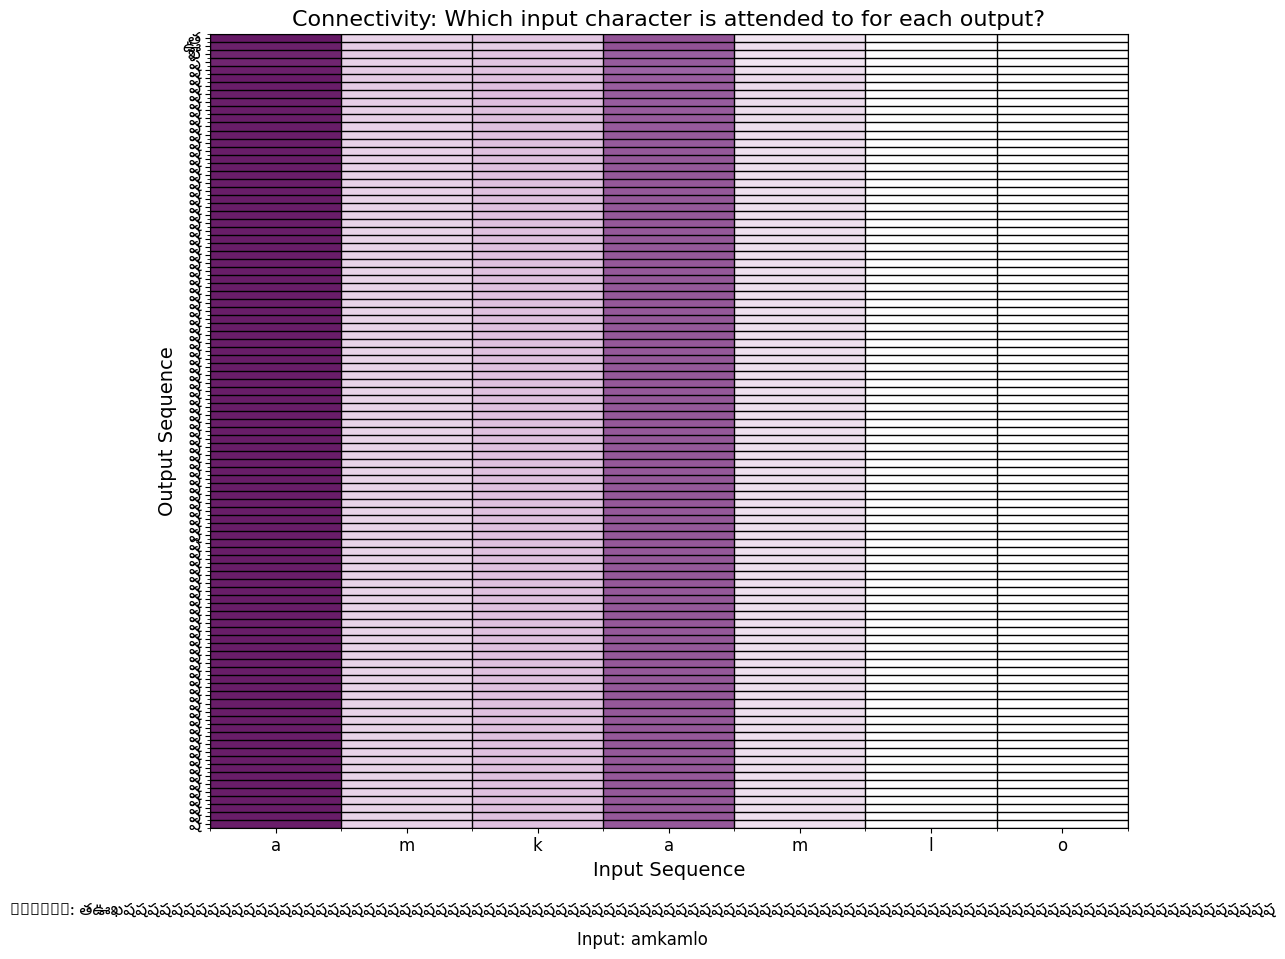

Saved visualization to /kaggle/working/connectivity_vis/connectivity_1087.png


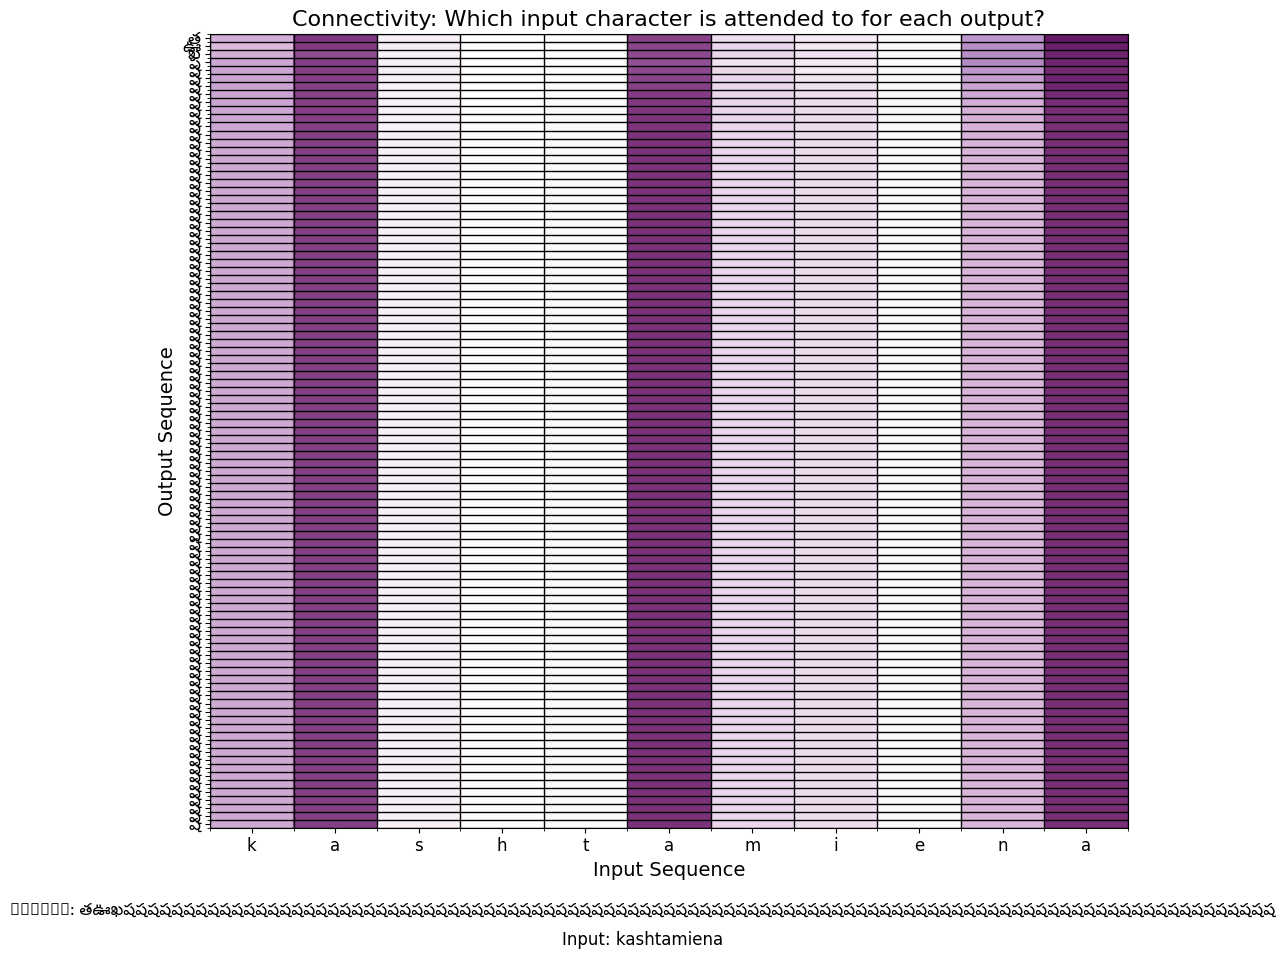

Saved visualization to /kaggle/working/connectivity_vis/connectivity_3436.png


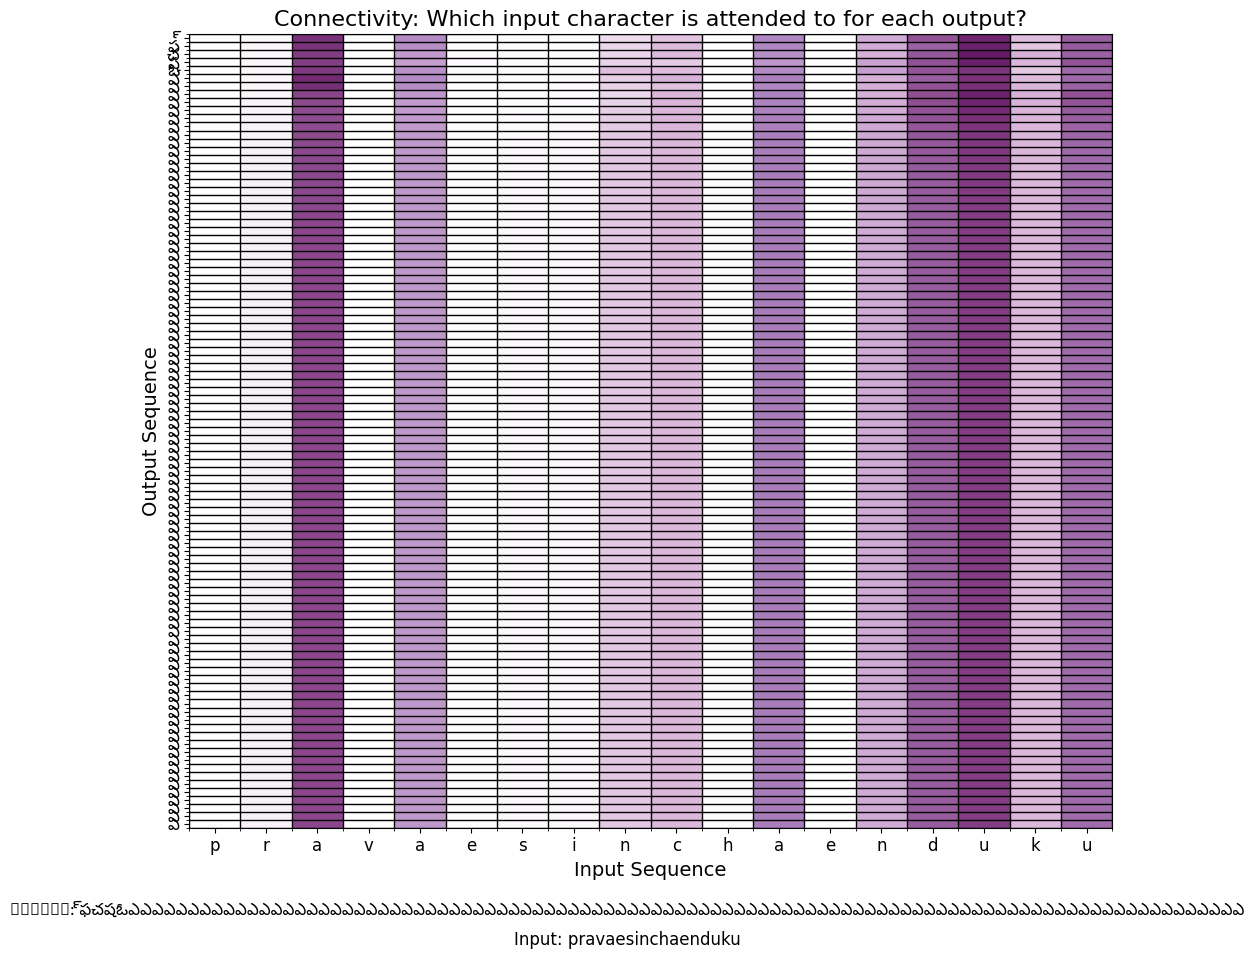

In [7]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
import urllib.request
import random

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def decode(self, src, max_len=100):
        """Inference mode (no teacher forcing)"""
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions
    
    def forward(self, src, tgt):
        """Training mode (with teacher forcing)"""
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (same as in decode method)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs

# ---- Setup Telugu font ----
def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

# ---- Create custom purple colormap for visualization ----
def create_purple_colormap():
    """Create a purple colormap for connectivity visualization"""
    colors = [(1, 1, 1, 0),           # Transparent white (no attention)
              (0.95, 0.9, 0.95, 0.5), # Very light purple
              (0.8, 0.6, 0.8, 0.7),   # Light purple
              (0.6, 0.4, 0.7, 0.8),   # Medium purple
              (0.5, 0.2, 0.5, 0.9),   # Dark purple
              (0.4, 0.1, 0.4, 1.0)]   # Very dark purple
    
    return LinearSegmentedColormap.from_list('purple_cmap', colors, N=256)

# ---- Connectivity Visualization Function ----
def visualize_connectivity(model, dataloader, device, src_vocab, tgt_vocab, 
                         example_indices=None, save_dir=None, num_examples=3):
    """
    Create connectivity visualizations for specific examples
    
    Args:
        model: The trained model
        dataloader: DataLoader with test examples
        device: Device to run model on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        example_indices: List of example indices to visualize (if None, select random)
        save_dir: Directory to save images (if None, don't save)
        num_examples: Number of examples to visualize if example_indices is None
    """
    # Create save directory if provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create purple colormap
    purple_cmap = create_purple_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # If no specific examples requested, select random ones
    if example_indices is None:
        example_indices = random.sample(range(len(dataloader.dataset)), 
                                        min(num_examples, len(dataloader.dataset)))
    
    # Create a new DataLoader with just the selected examples
    selected_data = []
    for idx in example_indices:
        selected_data.append(dataloader.dataset[idx])
    
    if not selected_data:
        print("No examples selected!")
        return
    
    # Create a mini-batch DataLoader with the selected examples
    mini_batch = [
        torch.stack([selected_data[i][0] for i in range(len(selected_data))]),
        torch.stack([selected_data[i][1] for i in range(len(selected_data))])
    ]
    
    with torch.no_grad():
        src, tgt = mini_batch
        src, tgt = src.to(device), tgt.to(device)
        
        # Generate translations with attention
        outputs, attentions = model.decode(src)
        
        # Process each example
        for i in range(len(selected_data)):
            # Extract source characters (skipping special tokens)
            src_chars = []
            for idx in src[i]:
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    src_chars.append(id_to_src.get(idx.item(), ''))
            
            # Extract target characters
            tgt_chars = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    tgt_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Extract prediction characters
            pred_chars = []
            for idx in outputs[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    pred_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Get attention matrix
            attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
            
            # Full text strings
            src_text = ''.join(src_chars)
            tgt_text = ''.join(tgt_chars)
            pred_text = ''.join(pred_chars)
            
            # Determine if target is Telugu based on character codes
            first_pred_char = pred_chars[0] if pred_chars else ''
            is_pred_telugu = (ord(first_pred_char) > 3000) if first_pred_char else False
            
            # Create figure
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(111)
            
            # Plot heatmap
            im = ax.imshow(attn, cmap=purple_cmap, aspect='auto', interpolation='nearest')
            
            # Add grid lines
            ax.set_xticks(np.arange(attn.shape[1]+1)-.5, minor=True)
            ax.set_yticks(np.arange(attn.shape[0]+1)-.5, minor=True)
            ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
            
            # Set axis labels
            ax.set_xlabel('Input Sequence', fontsize=14)
            ax.set_ylabel('Output Sequence', fontsize=14)
            
            # Set ticks
            ax.set_xticks(np.arange(len(src_chars)))
            ax.set_xticklabels(src_chars, fontsize=12)
            ax.set_yticks(np.arange(len(pred_chars)))
            
            # Use Telugu font for labels if needed
            if is_pred_telugu and telugu_font:
                ax.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=12)
            else:
                ax.set_yticklabels(pred_chars, fontsize=12)
            
            # Add title
            plt.title('Connectivity: Which input character is attended to for each output?', fontsize=16)
            
            # Add text showing input and output
            plt.figtext(0.5, 0.01, f'Input: {src_text}', ha='center', fontsize=12)
            
            if is_pred_telugu and telugu_font:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12, fontproperties=telugu_font)
            else:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12)
            
            # Adjust layout
            plt.tight_layout(rect=[0, 0.06, 1, 0.96])
            
            # Save the figure if a directory is provided
            if save_dir:
                fig_path = os.path.join(save_dir, f'connectivity_{example_indices[i]}.png')
                plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"Saved visualization to {fig_path}")
            
            # Log to wandb
            try:
                wandb.log({
                    f"connectivity_example_{example_indices[i]}": wandb.Image(
                        plt, caption=f"Connectivity: {src_text} → {pred_text}"
                    )
                })
            except:
                print("Failed to log to wandb - continuing without logging")
            
            # Display in notebook
            plt.show()

# ---- Main Function ----
def main():
    """Run the connectivity visualization on the test set"""
    # Configuration
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 16,
        'hidden_size': 512,
        'bidirectional': True,
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths - adjust these if needed
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/connectivity_vis'
    
    try:
        # Try to initialize wandb
        wandb.init(
            project="dakshina-transliteration",
            name="connectivity-visualization",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Create the test dataset
    try:
        # Try to load from file
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, build_vocab=True)
        src_vocab, tgt_vocab = test_dataset.src_vocab, test_dataset.tgt_vocab
    except:
        # Fallback to creating vocab from scratch with example data
        print("Using example data and creating vocabulary from scratch")
        example_dataset = DakshinaTSVDataset(None, build_vocab=True)
        src_vocab, tgt_vocab = example_dataset.src_vocab, example_dataset.tgt_vocab
        test_dataset = example_dataset
    
    # Create dataloader
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=0.7)
    model = model.to(device)
    
    # Try to load from checkpoint if it exists
    try:
        checkpoint_path = os.path.join(model_dir, 'best_model.pt')
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {checkpoint_path}")
    except:
        print("No existing model found - using randomly initialized model")
    
    # Set model to evaluation mode
    model.eval()
    
    # Select specific examples with different patterns
    # Find 'farm' example or use index 0
    farm_index = 0
    for i, (src, tgt) in enumerate(test_dataset):
        src_text = ''.join([test_dataset.src_vocab.get(idx.item(), '') for idx in src 
                         if idx.item() not in [0, 1, 2, 3]])
        if src_text.lower() == 'farm':
            farm_index = i
            break
    
    # Find another interesting example
    example_indices = [farm_index]  # Start with farm
    
    # Add 2-3 more indices for a total of 3-4 examples
    more_indices = random.sample(range(len(test_dataset)), 2)
    for idx in more_indices:
        if idx != farm_index:
            example_indices.append(idx)
    
    # Run the visualization
    visualize_connectivity(
        model, test_loader, device, src_vocab, tgt_vocab,
        example_indices=example_indices, save_dir=model_dir
    )
    
    # Close wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

In [8]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
import urllib.request
import random
from tqdm import tqdm

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def decode(self, src, max_len=100):
        """Inference mode (no teacher forcing)"""
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions
    
    def forward(self, src, tgt):
        """Training mode (with teacher forcing)"""
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (same as in decode method)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs

# ---- Training & Evaluation Functions ----
def compute_exact_match_accuracy(preds, targets, tgt_vocab):
    """Compute exact match accuracy between predictions and targets"""
    batch_size = preds.size(0)
    correct = 0
    
    # Convert ids to strings
    id_to_char = {v: k for k, v in tgt_vocab.items() if k not in ['<pad>', '<sos>', '<eos>', '<unk>']}
    
    for i in range(batch_size):
        # Extract character sequences (removing special tokens)
        pred_seq = ''.join([id_to_char.get(idx.item(), '') for idx in preds[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]])  # Skip <pad>, <unk>, <eos>, <sos>
        
        # For target, skip first token (<sos>) and stop at <eos> or <pad>
        tgt_seq = ''
        for idx in targets[i, 1:]:  # Skip first token
            token_id = idx.item()
            if token_id in [0, 2]:  # <pad> or <eos>
                break
            if token_id not in [1, 3]:  # Skip <unk> and <sos>
                tgt_seq += id_to_char.get(token_id, '')
        
        # Check for exact match
        if pred_seq == tgt_seq:
            correct += 1
    
    return correct / batch_size

def compute_char_accuracy(logits, targets):
    """Compute character-level accuracy between logits and targets"""
    preds = logits.argmax(dim=-1)
    mask = (targets != 0)  # Ignore padding
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

# ---- Training & Evaluation Loops ----
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    
    for src, tgt in tqdm(dataloader, desc="Training"):
        batch_size = src.size(0)
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt)
        
        # Flatten output and target tensors for loss calculation
        # Ignore the first token in target (<sos>)
        output_flat = output.reshape(-1, output.shape[-1])
        target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Calculate metrics
        char_acc = compute_char_accuracy(output, tgt[:, 1:])
        
        # Decode for exact match accuracy
        with torch.no_grad():
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
        
        # Accumulate metrics
        epoch_loss += loss.item() * batch_size
        epoch_char_acc += char_acc * batch_size
        epoch_exact_match_acc += exact_match_acc * batch_size
        total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            batch_size = src.size(0)
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass (use teacher forcing for loss calculation)
            output = model(src, tgt)
            
            # Flatten output and target tensors for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
            
            # Calculate loss
            loss = criterion(output_flat, target_flat)
            
            # Calculate metrics
            char_acc = compute_char_accuracy(output, tgt[:, 1:])
            
            # Decode for exact match accuracy (no teacher forcing)
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
            
            # Count exact matches for reporting
            correct_batch = int(exact_match_acc * batch_size)
            correct_predictions += correct_batch
            total_predictions += batch_size
            
            # Accumulate metrics
            epoch_loss += loss.item() * batch_size
            epoch_char_acc += char_acc * batch_size
            epoch_exact_match_acc += exact_match_acc * batch_size
            total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches,
        'correct': correct_predictions,
        'total': total_predictions
    }

# ---- Setup Telugu font ----
def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

# ---- Create custom purple colormap for visualization ----
def create_purple_colormap():
    """Create a purple colormap for connectivity visualization"""
    colors = [(1, 1, 1, 0),           # Transparent white (no attention)
              (0.95, 0.9, 0.95, 0.5), # Very light purple
              (0.8, 0.6, 0.8, 0.7),   # Light purple
              (0.6, 0.4, 0.7, 0.8),   # Medium purple
              (0.5, 0.2, 0.5, 0.9),   # Dark purple
              (0.4, 0.1, 0.4, 1.0)]   # Very dark purple
    
    return LinearSegmentedColormap.from_list('purple_cmap', colors, N=256)

# ---- Connectivity Visualization Function ----
def visualize_connectivity(model, dataloader, device, src_vocab, tgt_vocab, 
                         example_indices=None, save_dir=None, num_examples=3):
    """
    Create connectivity visualizations for specific examples
    
    Args:
        model: The trained model
        dataloader: DataLoader with test examples
        device: Device to run model on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        example_indices: List of example indices to visualize (if None, select random)
        save_dir: Directory to save images (if None, don't save)
        num_examples: Number of examples to visualize if example_indices is None
    """
    # Create save directory if provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create purple colormap
    purple_cmap = create_purple_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # If no specific examples requested, select random ones
    if example_indices is None:
        example_indices = random.sample(range(len(dataloader.dataset)), 
                                        min(num_examples, len(dataloader.dataset)))
    
    # Create a new DataLoader with just the selected examples
    selected_data = []
    for idx in example_indices:
        selected_data.append(dataloader.dataset[idx])
    
    if not selected_data:
        print("No examples selected!")
        return
    
    # Create a mini-batch DataLoader with the selected examples
    mini_batch = [
        torch.stack([selected_data[i][0] for i in range(len(selected_data))]),
        torch.stack([selected_data[i][1] for i in range(len(selected_data))])
    ]
    
    with torch.no_grad():
        src, tgt = mini_batch
        src, tgt = src.to(device), tgt.to(device)
        
        # Generate translations with attention
        outputs, attentions = model.decode(src)
        
        # Process each example
        for i in range(len(selected_data)):
            # Extract source characters (skipping special tokens)
            src_chars = []
            for idx in src[i]:
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    src_chars.append(id_to_src.get(idx.item(), ''))
            
            # Extract target characters
            tgt_chars = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    tgt_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Extract prediction characters
            pred_chars = []
            for idx in outputs[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    pred_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Get attention matrix
            attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
            
            # Full text strings
            src_text = ''.join(src_chars)
            tgt_text = ''.join(tgt_chars)
            pred_text = ''.join(pred_chars)
            
            # Determine if target is Telugu based on character codes
            first_pred_char = pred_chars[0] if pred_chars else ''
            is_pred_telugu = (ord(first_pred_char) > 3000) if first_pred_char else False
            
            # Create figure
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(111)
            
            # Plot heatmap
            im = ax.imshow(attn, cmap=purple_cmap, aspect='auto', interpolation='nearest')
            
            # Add grid lines
            ax.set_xticks(np.arange(attn.shape[1]+1)-.5, minor=True)
            ax.set_yticks(np.arange(attn.shape[0]+1)-.5, minor=True)
            ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
            
            # Set axis labels
            ax.set_xlabel('Input Sequence', fontsize=14)
            ax.set_ylabel('Output Sequence', fontsize=14)
            
            # Set ticks
            ax.set_xticks(np.arange(len(src_chars)))
            ax.set_xticklabels(src_chars, fontsize=12)
            ax.set_yticks(np.arange(len(pred_chars)))
            
            # Use Telugu font for labels if needed
            if is_pred_telugu and telugu_font:
                ax.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=12)
            else:
                ax.set_yticklabels(pred_chars, fontsize=12)
            
            # Add title
            plt.title('Connectivity: Which input character is attended to for each output?', fontsize=16)
            
            # Add text showing input and output
            plt.figtext(0.5, 0.01, f'Input: {src_text}', ha='center', fontsize=12)
            
            if is_pred_telugu and telugu_font:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12, fontproperties=telugu_font)
            else:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12)
            
            # Adjust layout
            plt.tight_layout(rect=[0, 0.06, 1, 0.96])
            
            # Save the figure if a directory is provided
            if save_dir:
                fig_path = os.path.join(save_dir, f'connectivity_{example_indices[i]}.png')
                plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"Saved visualization to {fig_path}")
            
            # Log to wandb
            try:
                wandb.log({
                    f"connectivity_example_{example_indices[i]}": wandb.Image(
                        plt, caption=f"Connectivity: {src_text} → {pred_text}"
                    )
                })
            except:
                print("Failed to log to wandb - continuing without logging")
            
            # Display in notebook
            plt.show()

# ---- Main Function ----
def main():
    """Train the model for 1-2 epochs and visualize connectivity"""
    # Best parameters
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam',
        'epochs': 2  # Train for 2 epochs
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths - adjust these if needed
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/connectivity_vis'
    os.makedirs(model_dir, exist_ok=True)
    
    try:
        # Try to initialize wandb
        wandb.init(
            project="dakshina-transliteration",
            name="connectivity-visualization",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Create datasets and dataloader
    try:
        # Try to load from files
        train_tsv = os.path.join(data_dir, 'te.translit.sampled.train.tsv')
        dev_tsv = os.path.join(data_dir, 'te.translit.sampled.dev.tsv')
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        
        # Build vocabulary from training data
        print("Building vocabulary from training data")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        
        # Create datasets using the vocabulary
        val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Fallback to creating datasets from scratch with example data
        print("Using example data and creating vocabulary from scratch")
        example_dataset = DakshinaTSVDataset(None, build_vocab=True)
        src_vocab, tgt_vocab = example_dataset.src_vocab, example_dataset.tgt_vocab
        
        # Use the same dataset for train, val, and test
        train_dataset = example_dataset
        val_dataset = example_dataset
        test_dataset = example_dataset
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=min(config['batch_size'], len(train_dataset)), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=min(config['batch_size'], len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(config['batch_size'], len(test_dataset)))
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    if config['optim'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optim'] == 'nadam':
        try:
            optimizer = optim.NAdam(model.parameters(), lr=config['learning_rate'])
        except AttributeError:
            print("NAdam optimizer not available, falling back to Adam")
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Train for 1-2 epochs
    best_val_acc = 0
    
    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Log to wandb
        try:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_metrics['loss'],
                'train_char_accuracy': train_metrics['char_acc'],
                'train_exact_match': train_metrics['exact_match_acc'],
                'val_loss': val_metrics['loss'],
                'val_char_accuracy': val_metrics['char_acc'],
                'val_exact_match': val_metrics['exact_match_acc']
            })
        except:
            pass
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            
            # Save model
            model_path = os.path.join(model_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': config
            }, model_path)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
    
    # Load best model for visualization
    try:
        model_path = os.path.join(model_dir, "best_model.pt")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from {model_path}")
    except:
        print("Using the last trained model for visualization")
    
    # Set model to evaluation mode
    model.eval()
    
    # Find 'farm' example or use index 0
    farm_index = None
    for i, (src, tgt) in enumerate(test_dataset):
        src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src 
                           if idx.item() not in [0, 1, 2, 3]])
        if src_text.lower() == 'farm':
            farm_index = i
            break
    
    if farm_index is None:
        print("Couldn't find 'farm' example, will use random examples")
        example_indices = random.sample(range(len(test_dataset)), 3)
    else:
        print(f"Found 'farm' example at index {farm_index}")
        # Add 2 more indices for a total of 3 examples
        example_indices = [farm_index]
        more_indices = random.sample(range(len(test_dataset)), 2)
        for idx in more_indices:
            if idx != farm_index:
                example_indices.append(idx)
    
    # Run the visualization
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    visualize_connectivity(
        model, test_loader, device, src_vocab, tgt_vocab,
        example_indices=example_indices, save_dir=model_dir
    )
    
    # Try to close wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Building vocabulary from training data
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Vocab sizes -> src: 30, tgt: 67
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Model has 7,275,075 parameters (7,275,075 trainable)

Epoch 1/2


Evaluating: 100%|██████████| 45/45 [00:13<00:00,  3.45it/s]


Train - Loss: 0.6664, Char Acc: 0.8195, Exact Match: 0.4143
Val - Loss: 0.4136, Char Acc: 0.8894, Exact Match: 0.4781 (2717/5683)
Saved new best model with validation accuracy: 0.4781

Epoch 2/2


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.47it/s]


Train - Loss: 0.2892, Char Acc: 0.9249, Exact Match: 0.6439
Val - Loss: 0.3400, Char Acc: 0.9086, Exact Match: 0.5624 (3196/5683)
Saved new best model with validation accuracy: 0.5624
Loaded best model from /kaggle/working/connectivity_vis/best_model.pt


NameError: cannot access free variable 'id_to_src' where it is not associated with a value in enclosing scope

Using device: cuda


Initialized wandb
Loaded vocabulary from saved files
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Loaded model from /kaggle/working/connectivity_vis/best_model.pt
Couldn't find 'farm' example, will use random examples


/tmp/ipykernel_35/3589110786.py:623: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])
/tmp/ipykernel_35/3589110786.py:623: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])
/tmp/ipykernel_35/3589110786.py:628: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/3589110786.py:628: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/3589110786.py:628: UserWarning: Glyph 79 (O) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/3589110786.py:628: UserWarning: Glyph 117 (u) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/3589110786.py:628: UserWarning: Glyph 116 (t) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')


Saved visualization to /kaggle/working/connectivity_vis/connectivity_4775.png


/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 79 (O) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 117 (u) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 116 (t) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 112 (p) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-pa

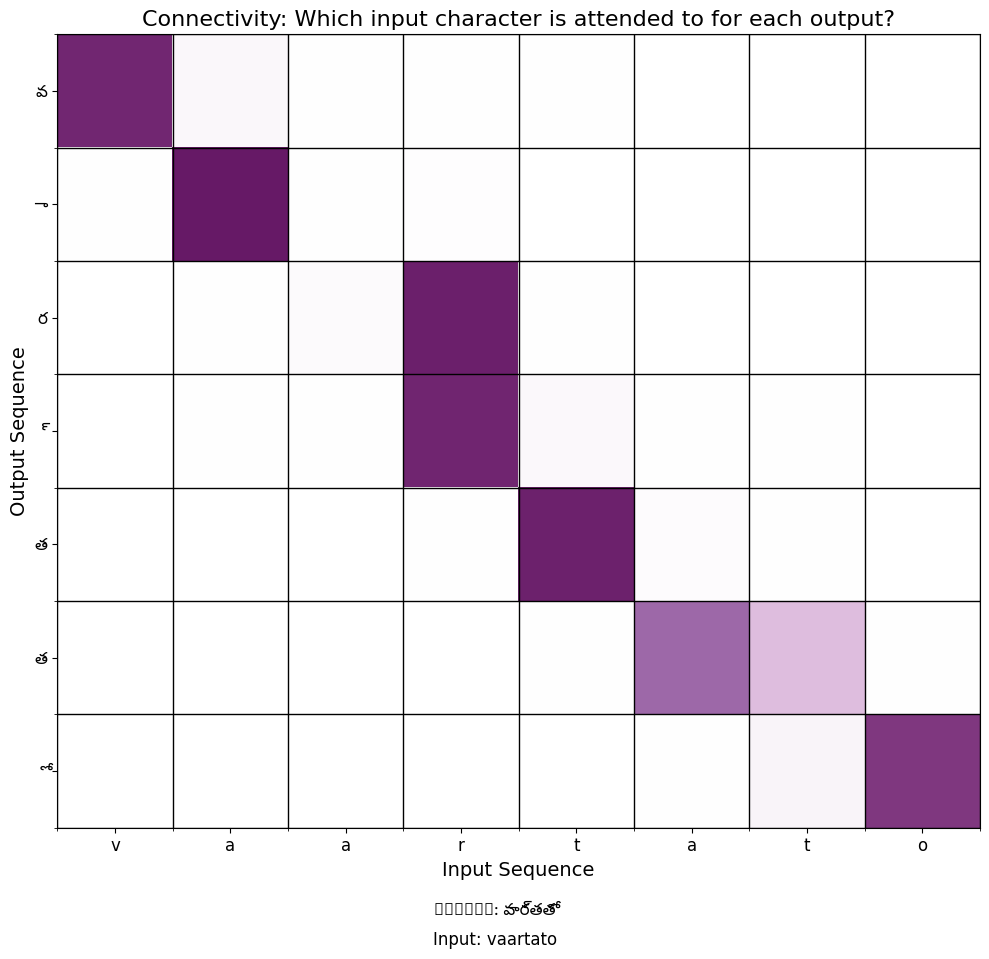

Saved visualization to /kaggle/working/connectivity_vis/connectivity_1968.png


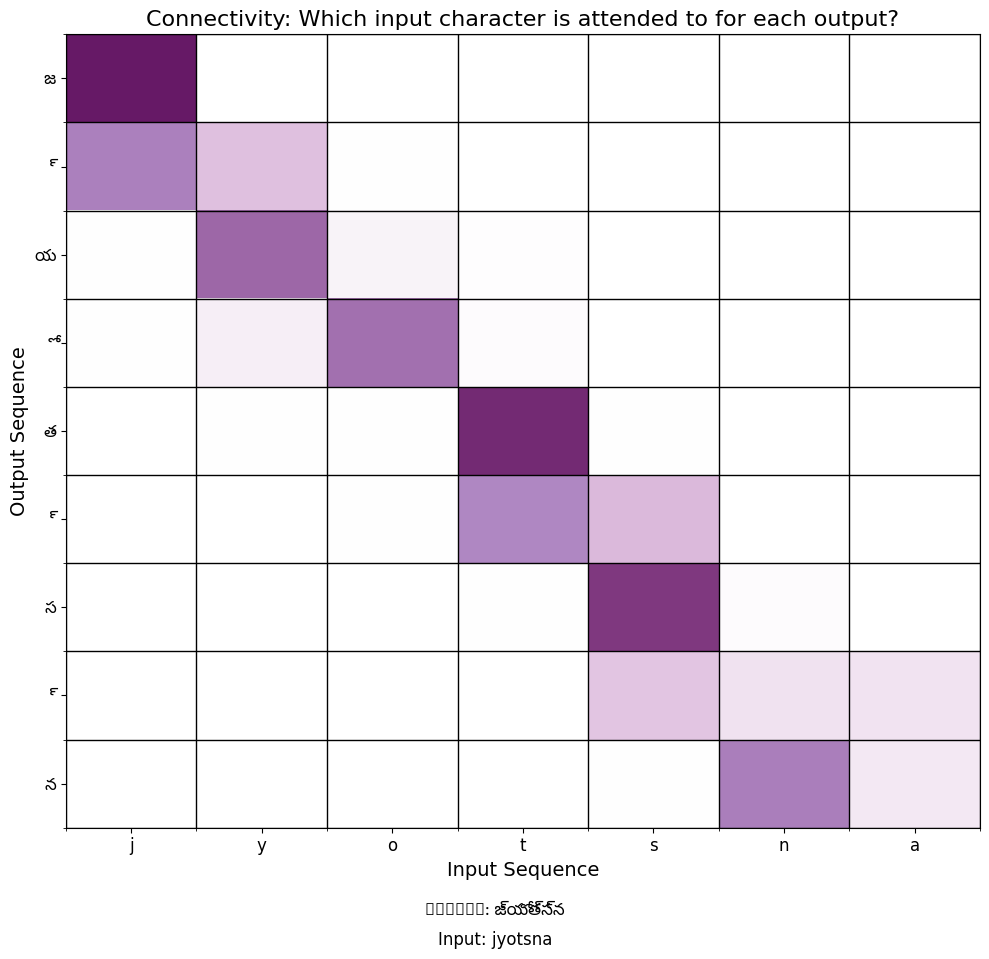

Saved visualization to /kaggle/working/connectivity_vis/connectivity_2571.png


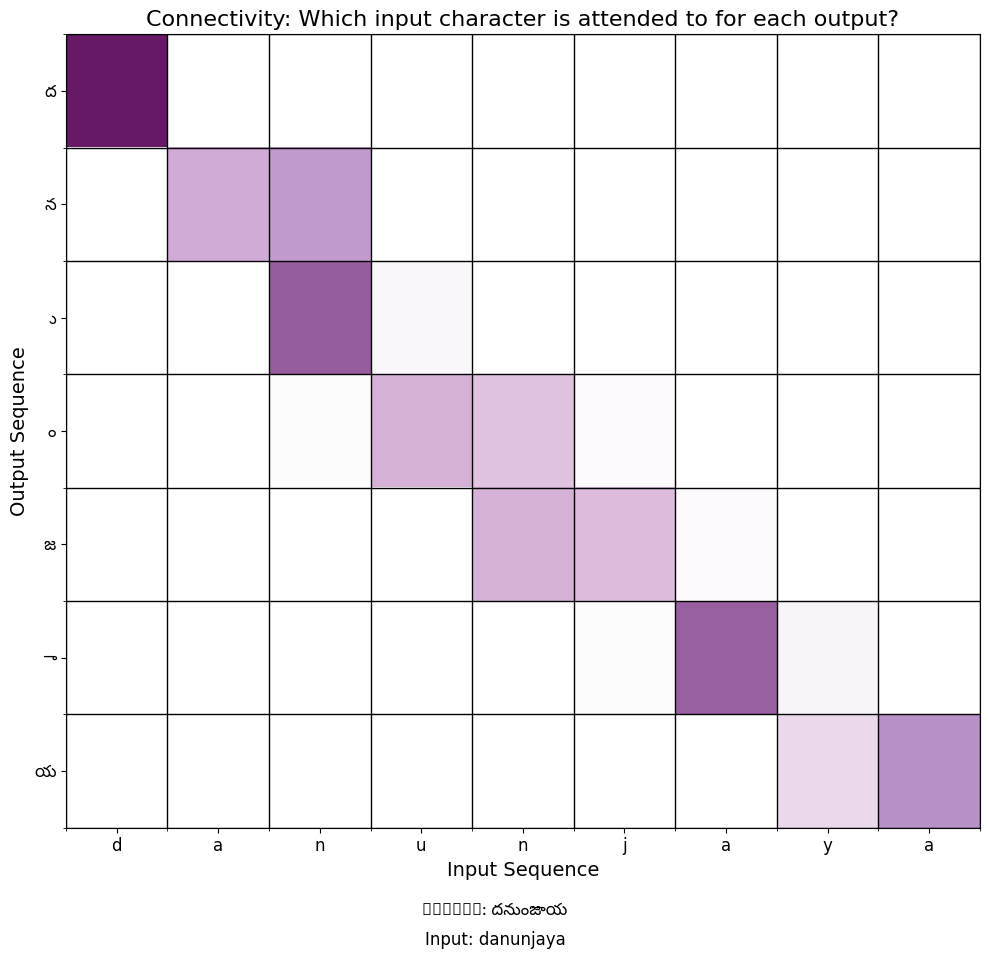

Saved visualization to /kaggle/working/connectivity_vis/connectivity_5591.png


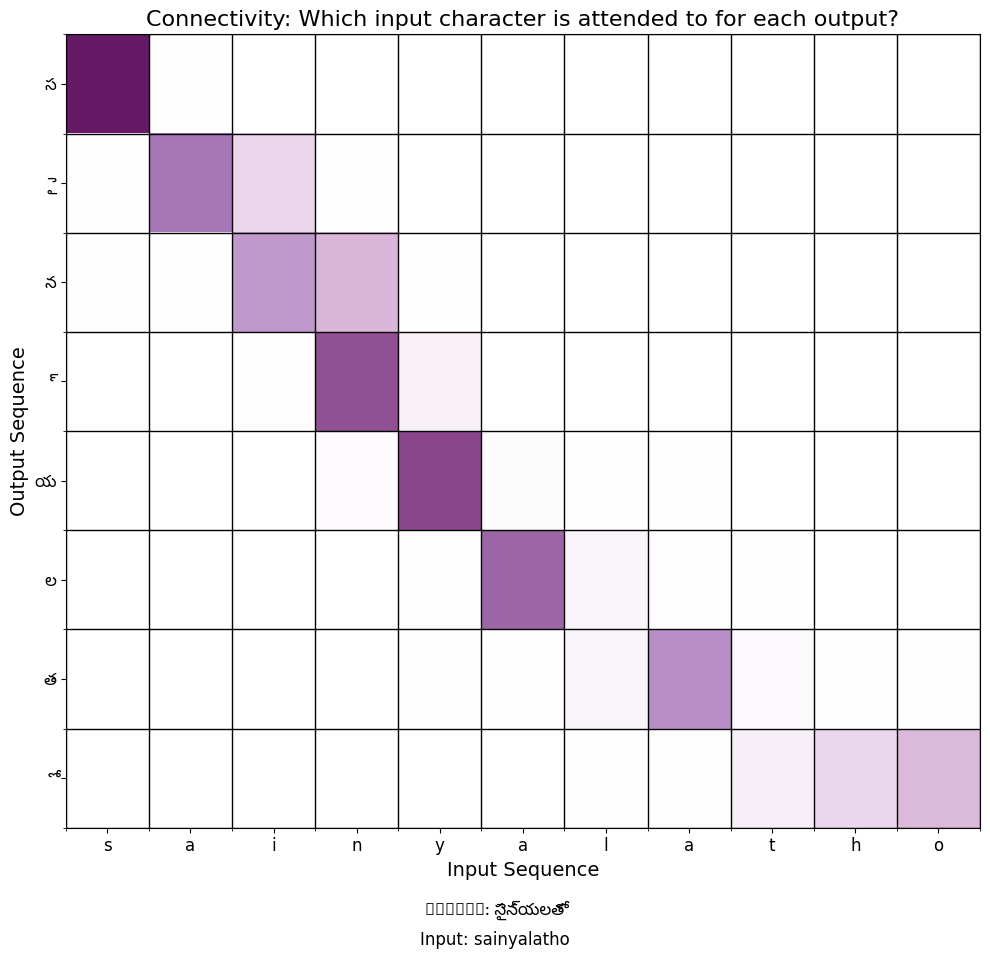

Saved visualization to /kaggle/working/connectivity_vis/connectivity_131.png


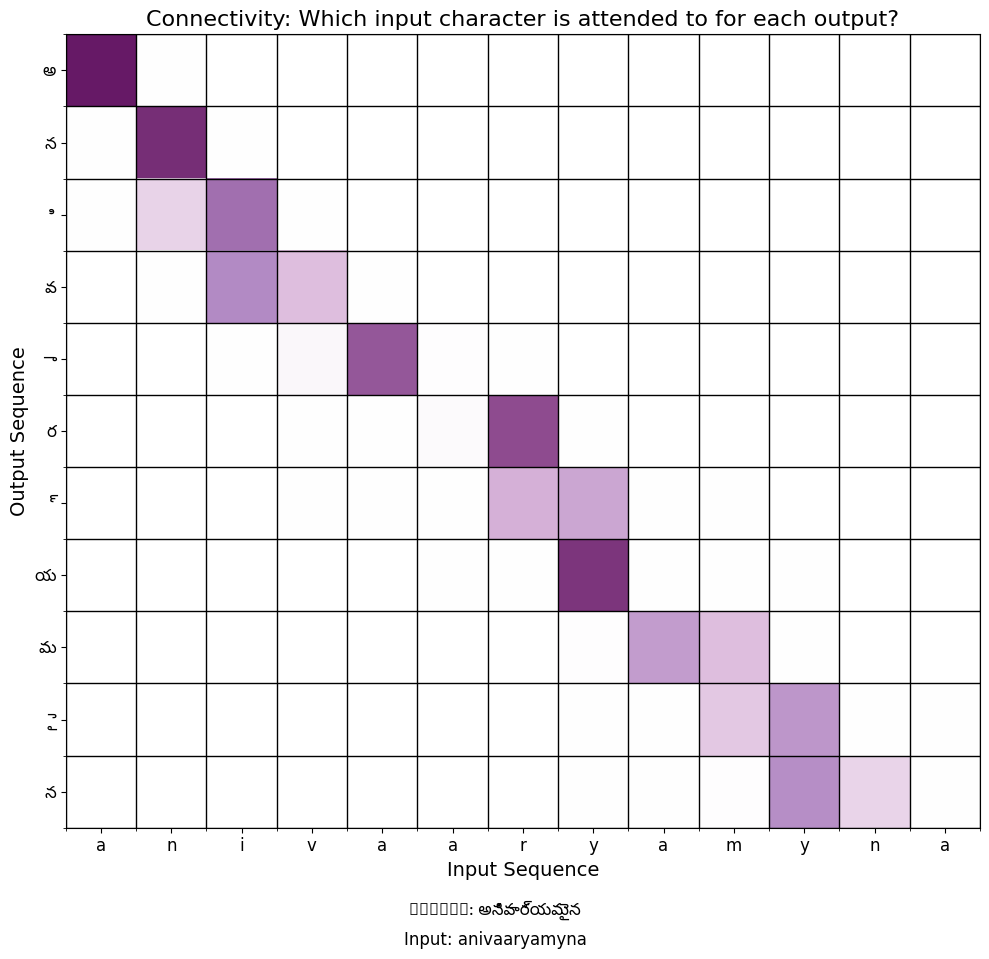

Saved visualization to /kaggle/working/connectivity_vis/connectivity_1954.png


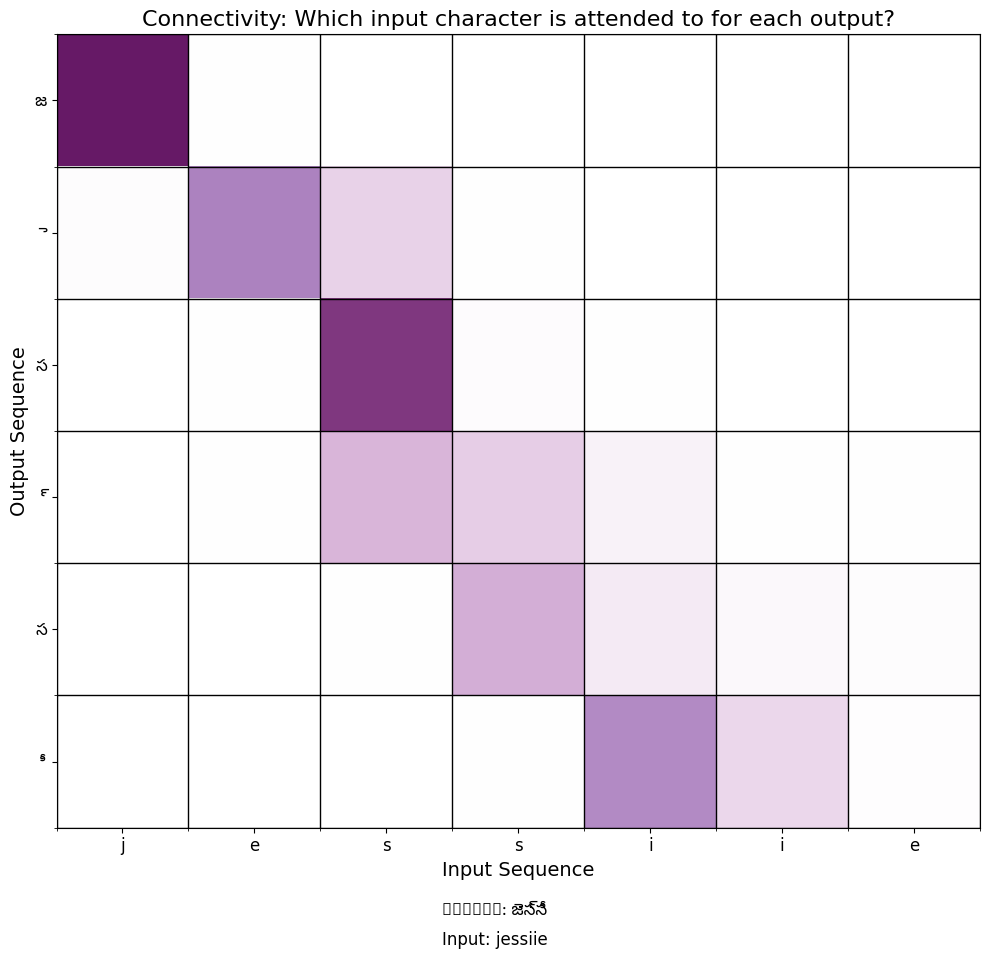

Saved visualization to /kaggle/working/connectivity_vis/connectivity_5586.png


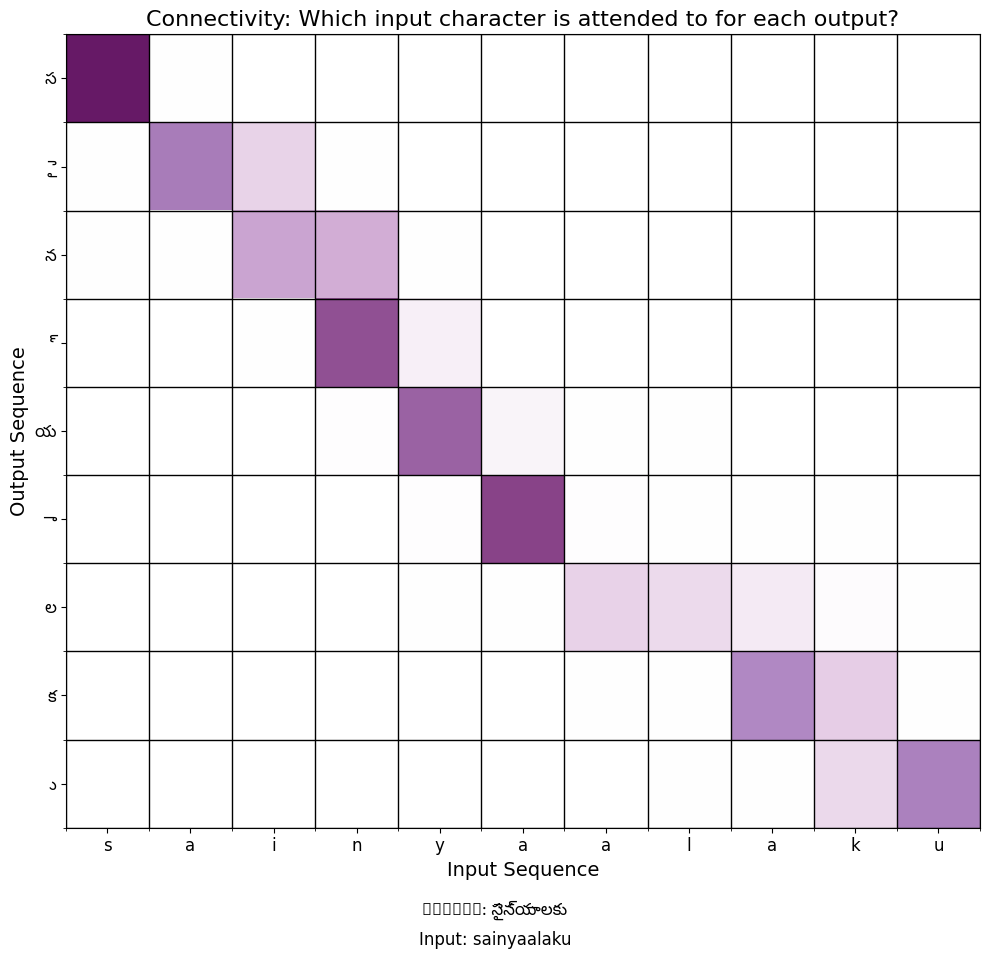

Saved visualization to /kaggle/working/connectivity_vis/connectivity_3766.png


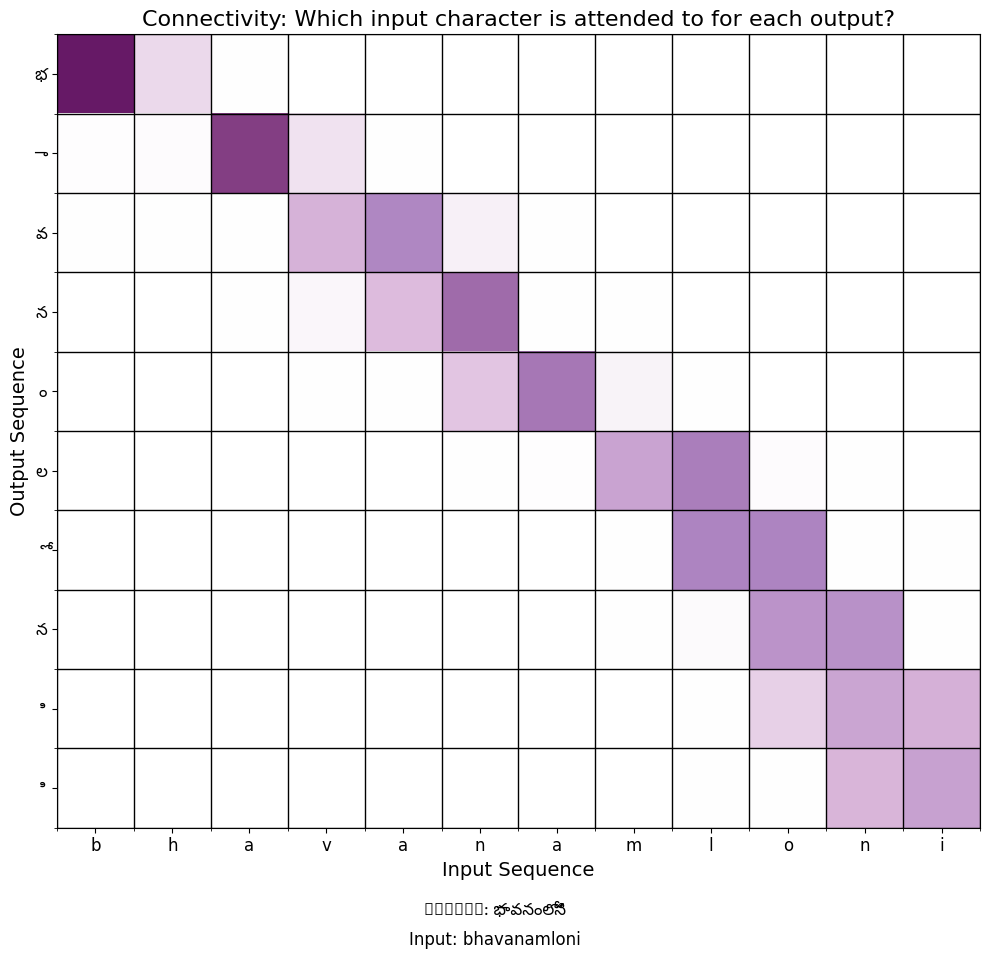

Saved visualization to /kaggle/working/connectivity_vis/connectivity_3577.png


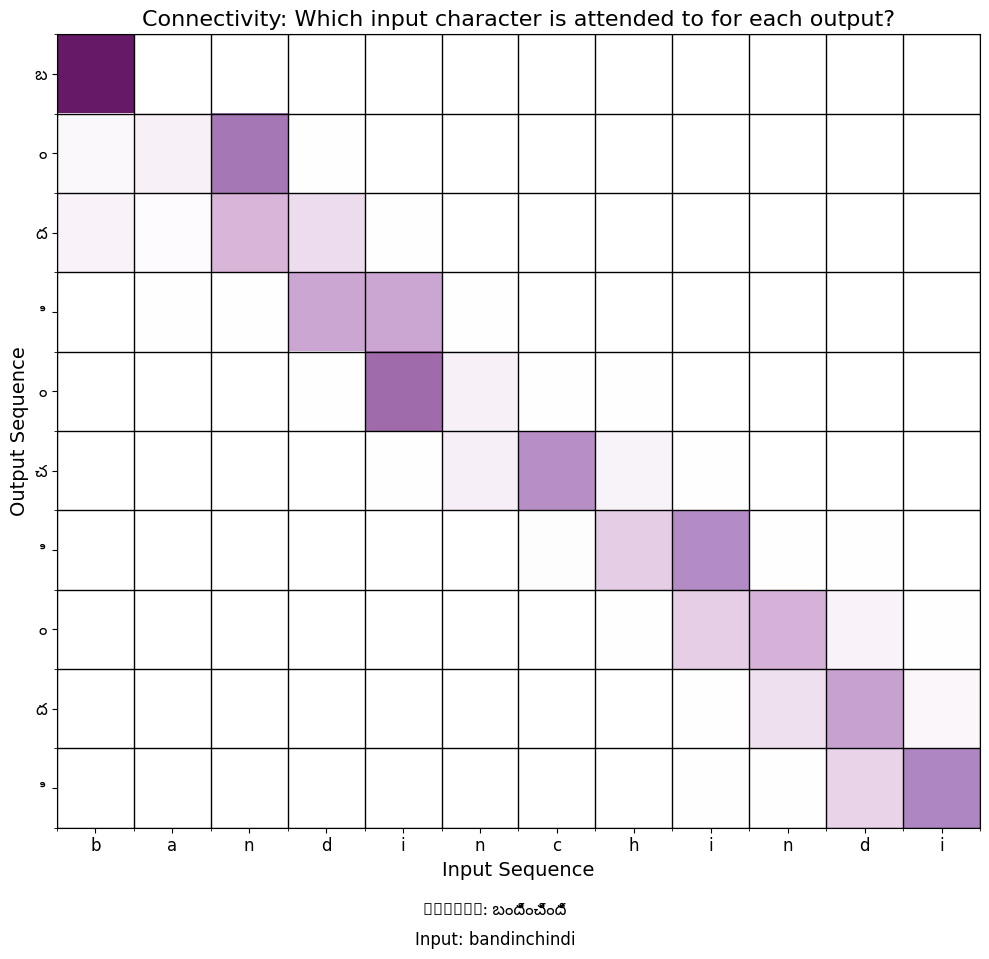

Saved visualization to /kaggle/working/connectivity_vis/connectivity_1448.png


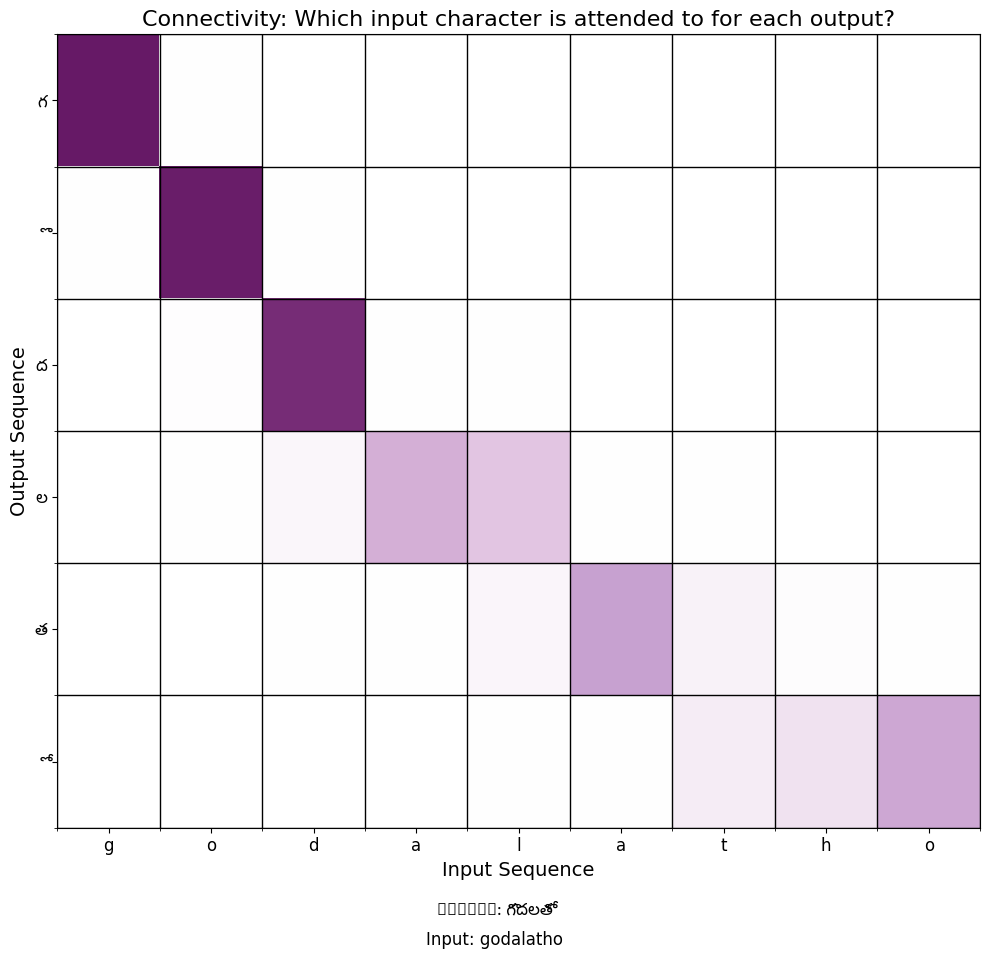

In [10]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
import urllib.request
import random

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def decode(self, src, max_len=100):
        """Inference mode (no teacher forcing)"""
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions
    
    def forward(self, src, tgt):
        """Training mode (with teacher forcing)"""
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (same as in decode method)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs

# ---- Setup Telugu font ----
def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

# ---- Create custom purple colormap for visualization ----
def create_purple_colormap():
    """Create a purple colormap for connectivity visualization"""
    colors = [(1, 1, 1, 0),           # Transparent white (no attention)
              (0.95, 0.9, 0.95, 0.5), # Very light purple
              (0.8, 0.6, 0.8, 0.7),   # Light purple
              (0.6, 0.4, 0.7, 0.8),   # Medium purple
              (0.5, 0.2, 0.5, 0.9),   # Dark purple
              (0.4, 0.1, 0.4, 1.0)]   # Very dark purple
    
    return LinearSegmentedColormap.from_list('purple_cmap', colors, N=256)

# ---- Connectivity Visualization Function ----
def visualize_connectivity(model, dataloader, device, src_vocab, tgt_vocab, 
                         example_indices=None, save_dir=None, num_examples=3):
    """
    Create connectivity visualizations for specific examples
    
    Args:
        model: The trained model
        dataloader: DataLoader with test examples
        device: Device to run model on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        example_indices: List of example indices to visualize (if None, select random)
        save_dir: Directory to save images (if None, don't save)
        num_examples: Number of examples to visualize if example_indices is None
    """
    # Create save directory if provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create purple colormap
    purple_cmap = create_purple_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # If no specific examples requested, select random ones
    if example_indices is None:
        example_indices = random.sample(range(len(dataloader.dataset)), 
                                        min(num_examples, len(dataloader.dataset)))
    
    # Create a new DataLoader with just the selected examples
    selected_data = []
    for idx in example_indices:
        selected_data.append(dataloader.dataset[idx])
    
    if not selected_data:
        print("No examples selected!")
        return
    
    # Create a mini-batch DataLoader with the selected examples
    mini_batch = [
        torch.stack([selected_data[i][0] for i in range(len(selected_data))]),
        torch.stack([selected_data[i][1] for i in range(len(selected_data))])
    ]
    
    with torch.no_grad():
        src, tgt = mini_batch
        src, tgt = src.to(device), tgt.to(device)
        
        # Generate translations with attention
        outputs, attentions = model.decode(src)
        
        # Process each example
        for i in range(len(selected_data)):
            # Extract source characters (skipping special tokens)
            src_chars = []
            for idx in src[i]:
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    src_chars.append(id_to_src.get(idx.item(), ''))
            
            # Extract target characters
            tgt_chars = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    tgt_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Extract prediction characters
            pred_chars = []
            for idx in outputs[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    pred_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Get attention matrix
            attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
            
            # Full text strings
            src_text = ''.join(src_chars)
            tgt_text = ''.join(tgt_chars)
            pred_text = ''.join(pred_chars)
            
            # Determine if target is Telugu based on character codes
            first_pred_char = pred_chars[0] if pred_chars else ''
            is_pred_telugu = (ord(first_pred_char) > 3000) if first_pred_char else False
            
            # Create figure
            plt.figure(figsize=(10, 10))
            ax = plt.subplot(111)
            
            # Plot heatmap
            im = ax.imshow(attn, cmap=purple_cmap, aspect='auto', interpolation='nearest')
            
            # Add grid lines
            ax.set_xticks(np.arange(attn.shape[1]+1)-.5, minor=True)
            ax.set_yticks(np.arange(attn.shape[0]+1)-.5, minor=True)
            ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
            
            # Set axis labels
            ax.set_xlabel('Input Sequence', fontsize=14)
            ax.set_ylabel('Output Sequence', fontsize=14)
            
            # Set ticks
            ax.set_xticks(np.arange(len(src_chars)))
            ax.set_xticklabels(src_chars, fontsize=12)
            ax.set_yticks(np.arange(len(pred_chars)))
            
            # Use Telugu font for labels if needed
            if is_pred_telugu and telugu_font:
                ax.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=12)
            else:
                ax.set_yticklabels(pred_chars, fontsize=12)
            
            # Add title
            plt.title('Connectivity: Which input character is attended to for each output?', fontsize=16)
            
            # Add text showing input and output
            plt.figtext(0.5, 0.01, f'Input: {src_text}', ha='center', fontsize=12)
            
            if is_pred_telugu and telugu_font:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12, fontproperties=telugu_font)
            else:
                plt.figtext(0.5, 0.04, f'Output: {pred_text}', ha='center', fontsize=12)
            
            # Adjust layout
            plt.tight_layout(rect=[0, 0.06, 1, 0.96])
            
            # Save the figure if a directory is provided
            if save_dir:
                fig_path = os.path.join(save_dir, f'connectivity_{example_indices[i]}.png')
                plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"Saved visualization to {fig_path}")
            
            # Log to wandb
            try:
                wandb.log({
                    f"connectivity_example_{example_indices[i]}": wandb.Image(
                        plt, caption=f"Connectivity: {src_text} → {pred_text}"
                    )
                })
            except:
                print("Failed to log to wandb - continuing without logging")
            
            # Display in notebook
            plt.show()

# ---- Main Function ----
def main(skip_training=True):
    """
    Load a saved model and visualize connectivity
    
    Args:
        skip_training: Whether to skip training and just load saved model
    """
    # Best parameters
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam',
        'epochs': 2  # Train for 2 epochs
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths - adjust these if needed
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/connectivity_vis'
    os.makedirs(model_dir, exist_ok=True)
    
    try:
        # Try to initialize wandb
        wandb.init(
            project="dakshina-transliteration",
            name="connectivity-visualization",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load vocabulary and test data
    try:
        # Check if we need to create or load vocabulary
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from saved files")
        
        # If skip_training is False or vocab doesn't exist, load from training data
        elif not skip_training:
            # Build vocabulary from training data
            train_tsv = os.path.join(data_dir, 'te.translit.sampled.train.tsv')
            print("Building vocabulary from training data")
            train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
            src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
            
            # Save vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
        else:
            # Create a temporary dataset to build vocabulary
            print("Building vocabulary from a temporary dataset")
            temp_dataset = DakshinaTSVDataset(os.path.join(data_dir, 'te.translit.sampled.test.tsv'), build_vocab=True)
            src_vocab, tgt_vocab = temp_dataset.src_vocab, temp_dataset.tgt_vocab
        
        # Load test dataset
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Fallback to creating datasets from scratch with example data
        print("Using example data and creating vocabulary from scratch")
        example_dataset = DakshinaTSVDataset(None, build_vocab=True)
        src_vocab, tgt_vocab = example_dataset.src_vocab, example_dataset.tgt_vocab
        test_dataset = example_dataset
        test_loader = DataLoader(test_dataset, batch_size=min(config['batch_size'], len(test_dataset)))
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Try to load from checkpoint
    try:
        # First check for model in model_dir
        model_path = os.path.join(model_dir, "best_model.pt")
        if os.path.exists(model_path):
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model from {model_path}")
        else:
            # If not found, check working directory
            working_dir_model = os.path.join('/kaggle/working/best_model_results', "best_model.pt")
            if os.path.exists(working_dir_model):
                checkpoint = torch.load(working_dir_model, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from {working_dir_model}")
            else:
                raise FileNotFoundError("Model checkpoint not found")
    except Exception as e:
        print(f"Error loading model: {e}")
        if skip_training:
            print("skip_training is True but no saved model was found.")
            return
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse mapping for source vocabulary 
    id_to_src = {v: k for k, v in src_vocab.items()}
    
    # Find 'farm' example or use index 0
    farm_index = None
    for i, (src, tgt) in enumerate(test_dataset):
        src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src 
                           if idx.item() not in [0, 1, 2, 3]])
        if src_text.lower() == 'farm':
            farm_index = i
            break
    
    if farm_index is None:
        print("Couldn't find 'farm' example, will use random examples")
        example_indices = random.sample(range(len(test_dataset)), 10)
    else:
        print(f"Found 'farm' example at index {farm_index}")
        # Add 2 more indices for a total of 3 examples
        example_indices = [farm_index]
        more_indices = random.sample(range(len(test_dataset)), 2)
        for idx in more_indices:
            if idx != farm_index:
                example_indices.append(idx)
    
    # Run the visualization
    visualize_connectivity(
        model, test_loader, device, src_vocab, tgt_vocab,
        example_indices=example_indices, save_dir=model_dir
    )
    
    # Close wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    # Skip training and just load the saved model
    main(skip_training=True)

Using device: cuda


Initialized wandb
Loaded vocabulary from saved files
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Loaded model from /kaggle/working/connectivity_vis/best_model.pt
Couldn't find 'farm' example, will use random examples


/tmp/ipykernel_35/649694824.py:659: UserWarning: Glyph 108 (l) missing from current font.
  plt.tight_layout(rect=[0, 0.08, 1, 0.98])
/tmp/ipykernel_35/649694824.py:659: UserWarning: Glyph 112 (p) missing from current font.
  plt.tight_layout(rect=[0, 0.08, 1, 0.98])
/tmp/ipykernel_35/649694824.py:664: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/649694824.py:664: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/649694824.py:664: UserWarning: Glyph 79 (O) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/649694824.py:664: UserWarning: Glyph 117 (u) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')
/tmp/ipykernel_35/649694824.py:664: UserWarning: Glyph 116 (t) missing from current font.
  plt.savefig(fig_path, dpi=150, bbox_inches='tight')


Saved visualization to /kaggle/working/connectivity_vis/focused_connectivity_5101.png


/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 79 (O) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 117 (u) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 116 (t) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 112 (p) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-pa

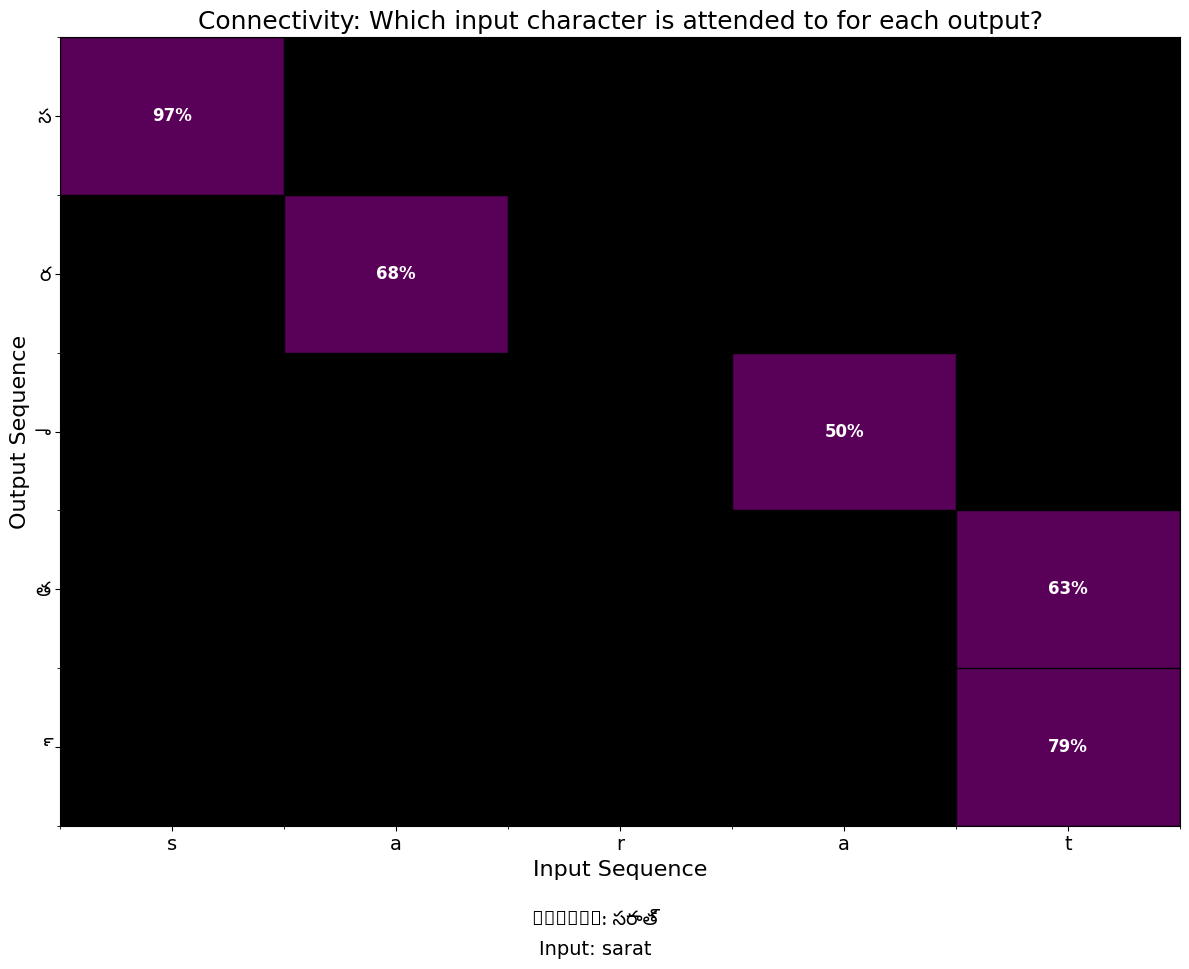

Saved visualization to /kaggle/working/connectivity_vis/focused_connectivity_3266.png


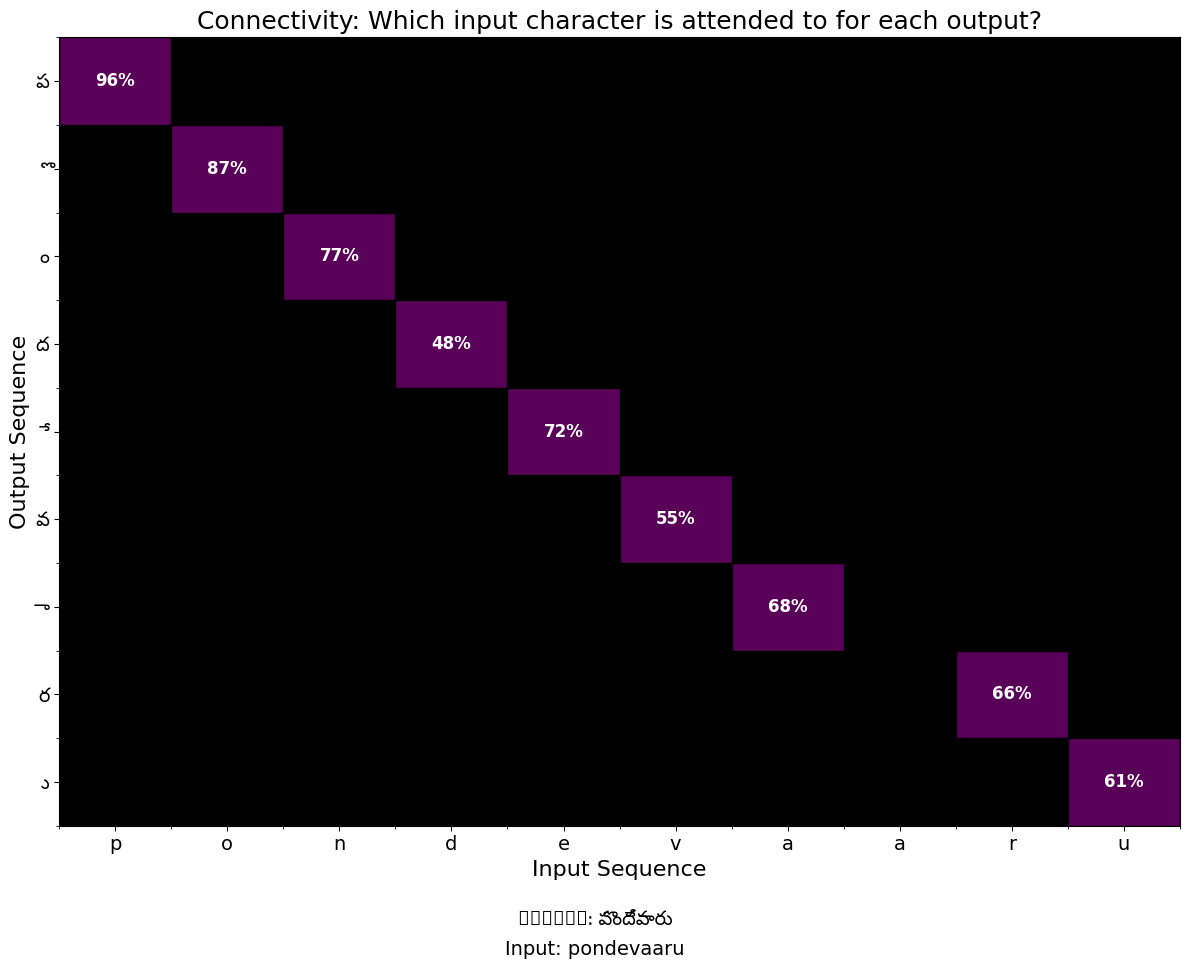

Saved visualization to /kaggle/working/connectivity_vis/focused_connectivity_732.png


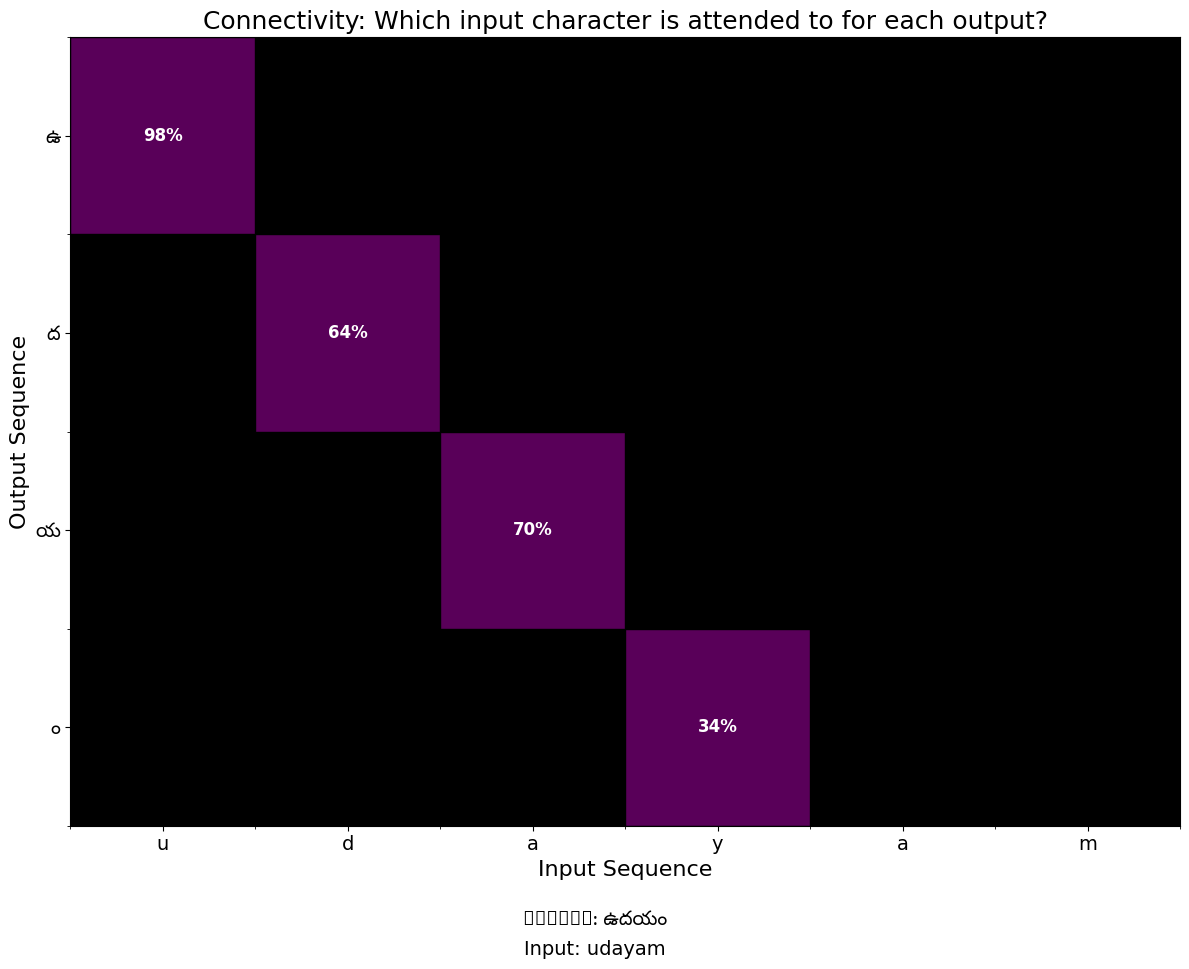

In [11]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import wandb
import urllib.request
import random
import matplotlib.patches as patches

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def decode(self, src, max_len=100):
        """Inference mode (no teacher forcing)"""
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions
    
    def forward(self, src, tgt):
        """Training mode (with teacher forcing)"""
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (same as in decode method)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio determines how often to use true target as input
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
                
        return outputs

# ---- Setup Telugu font ----
def setup_telugu_font():
    """Download and set up Telugu font for visualization"""
    font_path = '/tmp/NotoSansTelugu-Regular.ttf'
    if not os.path.exists(font_path):
        try:
            font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/unhinted/ttf/NotoSansTelugu/NotoSansTelugu-Regular.ttf'
            urllib.request.urlretrieve(font_url, font_path)
            print("Downloaded Telugu font successfully")
        except Exception as e:
            print(f"Failed to download Telugu font: {e}")
            font_path = None
    
    if font_path and os.path.exists(font_path):
        try:
            telugu_font = fm.FontProperties(fname=font_path)
            return telugu_font
        except Exception as e:
            print(f"Failed to load Telugu font: {e}")
    
    return None

# ---- Create custom purple colormap for visualization ----
def create_purple_colormap():
    """Create a purple colormap for connectivity visualization"""
    colors = [(1, 1, 1, 0),           # Transparent white (no attention)
              (0.95, 0.9, 0.95, 0.5), # Very light purple
              (0.8, 0.6, 0.8, 0.7),   # Light purple
              (0.6, 0.4, 0.7, 0.8),   # Medium purple
              (0.5, 0.2, 0.5, 0.9),   # Dark purple
              (0.4, 0.1, 0.4, 1.0)]   # Very dark purple
    
    return LinearSegmentedColormap.from_list('purple_cmap', colors, N=256)

# ---- New focused connectivity visualization ----
def visualize_focused_connectivity(model, dataloader, device, src_vocab, tgt_vocab, 
                                 example_indices=None, save_dir=None, num_examples=3):
    """
    Create focused connectivity visualizations that highlight which input character
    is being attended to for each output character position.
    
    Args:
        model: The trained model
        dataloader: DataLoader with test examples
        device: Device to run model on
        src_vocab: Source vocabulary
        tgt_vocab: Target vocabulary
        example_indices: List of example indices to visualize (if None, select random)
        save_dir: Directory to save images (if None, don't save)
        num_examples: Number of examples to visualize if example_indices is None
    """
    # Create save directory if provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Setup Telugu font
    telugu_font = setup_telugu_font()
    
    # Create reverse mappings
    id_to_src = {v: k for k, v in src_vocab.items()}
    id_to_tgt = {v: k for k, v in tgt_vocab.items()}
    
    # Create purple colormap
    purple_cmap = create_purple_colormap()
    
    # Set model to evaluation mode
    model.eval()
    
    # If no specific examples requested, select random ones
    if example_indices is None:
        example_indices = random.sample(range(len(dataloader.dataset)), 
                                        min(num_examples, len(dataloader.dataset)))
    
    # Create a new DataLoader with just the selected examples
    selected_data = []
    for idx in example_indices:
        selected_data.append(dataloader.dataset[idx])
    
    if not selected_data:
        print("No examples selected!")
        return
    
    # Create a mini-batch DataLoader with the selected examples
    mini_batch = [
        torch.stack([selected_data[i][0] for i in range(len(selected_data))]),
        torch.stack([selected_data[i][1] for i in range(len(selected_data))])
    ]
    
    with torch.no_grad():
        src, tgt = mini_batch
        src, tgt = src.to(device), tgt.to(device)
        
        # Generate translations with attention
        outputs, attentions = model.decode(src)
        
        # Process each example
        for i in range(len(selected_data)):
            # Extract source characters (skipping special tokens)
            src_chars = []
            for idx in src[i]:
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    src_chars.append(id_to_src.get(idx.item(), ''))
            
            # Extract target characters
            tgt_chars = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    tgt_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Extract prediction characters
            pred_chars = []
            for idx in outputs[i, 1:]:  # Skip <sos>
                if idx.item() not in [0, 1, 2, 3]:  # Skip special tokens
                    pred_chars.append(id_to_tgt.get(idx.item(), ''))
            
            # Get attention matrix
            attn = attentions[i, :len(pred_chars), 1:len(src_chars)+1].cpu().numpy()
            
            # Full text strings
            src_text = ''.join(src_chars)
            tgt_text = ''.join(tgt_chars)
            pred_text = ''.join(pred_chars)
            
            # Determine if target is Telugu based on character codes
            first_pred_char = pred_chars[0] if pred_chars else ''
            is_pred_telugu = (ord(first_pred_char) > 3000) if first_pred_char else False
            
            # Create figure for the main visualization
            fig = plt.figure(figsize=(12, 10))
            
            # 1. Get the max attention position for each output character
            max_attention_indices = np.argmax(attn, axis=1)
            
            # 2. Create the main heatmap
            ax = plt.subplot(111)
            
            # Create a blank white image for base
            blank_image = np.ones((len(pred_chars), len(src_chars)))
            
            # Plot the simple attention map (white with grid)
            im = ax.imshow(blank_image, cmap='Greys', aspect='auto', vmin=0, vmax=1)
            
            # Add grid lines
            ax.set_xticks(np.arange(len(src_chars)+1)-.5, minor=True)
            ax.set_yticks(np.arange(len(pred_chars)+1)-.5, minor=True)
            ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
            
            # Set axis labels with larger font
            ax.set_xlabel('Input Sequence', fontsize=16)
            ax.set_ylabel('Output Sequence', fontsize=16)
            
            # Set ticks
            ax.set_xticks(np.arange(len(src_chars)))
            ax.set_xticklabels(src_chars, fontsize=14)
            ax.set_yticks(np.arange(len(pred_chars)))
            
            # Use Telugu font for labels if needed
            if is_pred_telugu and telugu_font:
                ax.set_yticklabels(pred_chars, fontproperties=telugu_font, fontsize=14)
            else:
                ax.set_yticklabels(pred_chars, fontsize=14)
            
            # Add title
            plt.title('Connectivity: Which input character is attended to for each output?', fontsize=18)
            
            # Add text showing input and output
            plt.figtext(0.5, 0.02, f'Input: {src_text}', ha='center', fontsize=14)
            
            if is_pred_telugu and telugu_font:
                plt.figtext(0.5, 0.05, f'Output: {pred_text}', ha='center', fontsize=14, fontproperties=telugu_font)
            else:
                plt.figtext(0.5, 0.05, f'Output: {pred_text}', ha='center', fontsize=14)
            
            # 3. Now highlight the max attention cells with colors
            # Color each cell with the max attention with a bold purple color
            for y, max_idx in enumerate(max_attention_indices):
                rect = patches.Rectangle(
                    (max_idx-0.5, y-0.5), 
                    1, 1, 
                    linewidth=0, 
                    edgecolor='none',
                    facecolor='purple',
                    alpha=0.7
                )
                ax.add_patch(rect)
                
                # Add percentage text
                max_attention_value = attn[y, max_idx]
                ax.text(
                    max_idx, 
                    y, 
                    f"{max_attention_value:.0%}", 
                    ha='center', 
                    va='center', 
                    color='white', 
                    fontweight='bold',
                    fontsize=12
                )
            
            # Adjust layout
            plt.tight_layout(rect=[0, 0.08, 1, 0.98])
            
            # Save the figure if a directory is provided
            if save_dir:
                fig_path = os.path.join(save_dir, f'focused_connectivity_{example_indices[i]}.png')
                plt.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"Saved visualization to {fig_path}")
            
            # Log to wandb
            try:
                wandb.log({
                    f"focused_connectivity_{example_indices[i]}": wandb.Image(
                        fig, caption=f"Focused Connectivity: {src_text} → {pred_text}"
                    )
                })
            except:
                print("Failed to log to wandb - continuing without logging")
            
            # Display in notebook
            plt.show()

# ---- Main Function ----
def main():
    """Load a saved model and create focused connectivity visualization"""
    # Config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths - adjust these if needed
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/connectivity_vis'
    os.makedirs(model_dir, exist_ok=True)
    
    try:
        # Try to initialize wandb
        wandb.init(
            project="dakshina-transliteration",
            name="focused-connectivity-visualization",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load vocabulary and test data
    try:
        # Check if vocabulary files exist
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from saved files")
        else:
            # Try loading from best_model_results
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab/src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab/tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from best model directory")
            
            # Save for future use
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
        
        # Load test dataset
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
        
    except Exception as e:
        print(f"Error loading data: {e}")
        # Fallback to creating datasets from scratch with example data
        print("Using example data and creating vocabulary from scratch")
        example_dataset = DakshinaTSVDataset(None, build_vocab=True)
        src_vocab, tgt_vocab = example_dataset.src_vocab, example_dataset.tgt_vocab
        test_dataset = example_dataset
        test_loader = DataLoader(test_dataset, batch_size=min(config['batch_size'], len(test_dataset)))
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=0.7)
    model = model.to(device)
    
    # Try to load from checkpoint
    try:
        # First check for model in model_dir
        model_path = os.path.join(model_dir, "best_model.pt")
        if os.path.exists(model_path):
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model from {model_path}")
        else:
            # If not found, check working directory
            working_dir_model = os.path.join('/kaggle/working/best_model_results', "best_model.pt")
            if os.path.exists(working_dir_model):
                checkpoint = torch.load(working_dir_model, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from {working_dir_model}")
            else:
                raise FileNotFoundError("Model checkpoint not found")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Using untrained model")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse mapping for source vocabulary 
    id_to_src = {v: k for k, v in src_vocab.items()}
    
    # Find 'farm' example or use index 0
    farm_index = None
    for i, (src, tgt) in enumerate(test_dataset):
        src_text = ''.join([id_to_src.get(idx.item(), '') for idx in src 
                           if idx.item() not in [0, 1, 2, 3]])
        if src_text.lower() == 'farm':
            farm_index = i
            break
    
    if farm_index is None:
        print("Couldn't find 'farm' example, will use random examples")
        example_indices = random.sample(range(len(test_dataset)), 3)
    else:
        print(f"Found 'farm' example at index {farm_index}")
        # Add 2 more indices for a total of 3 examples
        example_indices = [farm_index]
        more_indices = random.sample(range(len(test_dataset)), 2)
        for idx in more_indices:
            if idx != farm_index:
                example_indices.append(idx)
    
    # Run the visualization
    visualize_focused_connectivity(
        model, test_loader, device, src_vocab, tgt_vocab,
        example_indices=example_indices, save_dir=model_dir
    )
    
    # Close wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

In [13]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Store romanized words for visualization
            self.romanized_words = df['roman'].tolist()
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
            # Create romanized words list
            self.romanized_words = [pair[0] for pair in self.pairs]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt, return_attention=False):
        """
        Training mode (with optional attention return)
        
        Args:
            src: Source tokens
            tgt: Target tokens
            return_attention: If True, return attention weights
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Tensor to store attention weights if needed
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]) if return_attention else None
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Store attention weights if needed
            if return_attention:
                attentions[:, t-1, :] = attn
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
        
        if return_attention:
            return outputs, attentions
        else:
            return outputs

    def decode(self, src, max_len=100):
        """
        Inference mode (no teacher forcing)
        
        Returns:
            outputs: Output tokens
            attentions: Attention weights
        """
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Training & Evaluation Functions ----
def compute_exact_match_accuracy(preds, targets, tgt_vocab):
    """Compute exact match accuracy between predictions and targets"""
    batch_size = preds.size(0)
    correct = 0
    
    # Convert ids to strings
    id_to_char = {v: k for k, v in tgt_vocab.items() if k not in ['<pad>', '<sos>', '<eos>', '<unk>']}
    
    for i in range(batch_size):
        # Extract character sequences (removing special tokens)
        pred_seq = ''.join([id_to_char.get(idx.item(), '') for idx in preds[i, 1:] 
                            if idx.item() not in [0, 1, 2, 3]])  # Skip <pad>, <unk>, <eos>, <sos>
        
        # For target, skip first token (<sos>) and stop at <eos> or <pad>
        tgt_seq = ''
        for idx in targets[i, 1:]:  # Skip first token
            token_id = idx.item()
            if token_id in [0, 2]:  # <pad> or <eos>
                break
            if token_id not in [1, 3]:  # Skip <unk> and <sos>
                tgt_seq += id_to_char.get(token_id, '')
        
        # Check for exact match
        if pred_seq == tgt_seq:
            correct += 1
    
    return correct / batch_size

def compute_char_accuracy(logits, targets):
    """Compute character-level accuracy between logits and targets"""
    preds = logits.argmax(dim=-1)
    mask = (targets != 0)  # Ignore padding
    correct = ((preds == targets) & mask).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    
    for src, tgt in tqdm(dataloader, desc="Training"):
        batch_size = src.size(0)
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt)
        
        # Flatten output and target tensors for loss calculation
        # Ignore the first token in target (<sos>)
        output_flat = output.reshape(-1, output.shape[-1])
        target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Calculate metrics
        char_acc = compute_char_accuracy(output, tgt[:, 1:])
        
        # Decode for exact match accuracy
        with torch.no_grad():
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
        
        # Accumulate metrics
        epoch_loss += loss.item() * batch_size
        epoch_char_acc += char_acc * batch_size
        epoch_exact_match_acc += exact_match_acc * batch_size
        total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_char_acc = 0
    epoch_exact_match_acc = 0
    total_batches = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            batch_size = src.size(0)
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass (use teacher forcing for loss calculation)
            output = model(src, tgt)
            
            # Flatten output and target tensors for loss calculation
            output_flat = output.reshape(-1, output.shape[-1])
            target_flat = tgt[:, 1:].reshape(-1)  # Shift right to predict next token
            
            # Calculate loss
            loss = criterion(output_flat, target_flat)
            
            # Calculate metrics
            char_acc = compute_char_accuracy(output, tgt[:, 1:])
            
            # Decode for exact match accuracy (no teacher forcing)
            predictions, _ = model.decode(src)
            exact_match_acc = compute_exact_match_accuracy(predictions, tgt, dataloader.dataset.tgt_vocab)
            
            # Count exact matches for reporting
            correct_batch = int(exact_match_acc * batch_size)
            correct_predictions += correct_batch
            total_predictions += batch_size
            
            # Accumulate metrics
            epoch_loss += loss.item() * batch_size
            epoch_char_acc += char_acc * batch_size
            epoch_exact_match_acc += exact_match_acc * batch_size
            total_batches += batch_size
    
    # Return average metrics
    return {
        'loss': epoch_loss / total_batches,
        'char_acc': epoch_char_acc / total_batches,
        'exact_match_acc': epoch_exact_match_acc / total_batches,
        'correct': correct_predictions,
        'total': total_predictions
    }

# ---- Main Function ----
def main():
    """Train the model for 2 epochs and create D3.js attention visualizations"""
    # Best config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 128,
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam',
        'epochs': 2  # Train for 2 epochs
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/d3js_attention_vis'
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize wandb
    try:
        wandb.init(
            project="dakshina-transliteration",
            name="d3js-attention-visualization-trained",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load datasets
    try:
        train_tsv = os.path.join(data_dir, 'te.translit.sampled.train.tsv')
        dev_tsv = os.path.join(data_dir, 'te.translit.sampled.dev.tsv')
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        
        # Build vocabulary from training data
        print("Building vocabulary from training data")
        train_dataset = DakshinaTSVDataset(train_tsv, build_vocab=True)
        src_vocab, tgt_vocab = train_dataset.src_vocab, train_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        
        # Create the rest of the datasets
        val_dataset = DakshinaTSVDataset(dev_tsv, src_vocab, tgt_vocab)
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])
    except Exception as e:
        print(f"Error loading datasets: {e}")
        # Create example datasets
        example_dataset = DakshinaTSVDataset(None, build_vocab=True)
        src_vocab, tgt_vocab = example_dataset.src_vocab, example_dataset.tgt_vocab
        
        # Save vocabulary
        with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(src_vocab, f, ensure_ascii=False)
        with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
            json.dump(tgt_vocab, f, ensure_ascii=False)
        
        # Use the same dataset for train, val, and test
        train_dataset = example_dataset
        val_dataset = example_dataset
        test_dataset = example_dataset
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=min(config['batch_size'], len(train_dataset)), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=min(config['batch_size'], len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(config['batch_size'], len(test_dataset)))
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Loss function (ignore padding token)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Print model size
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {total_params:,} parameters ({trainable_params:,} trainable)")
    
    # Train for 2 epochs
    best_val_acc = 0
    
    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, device)
        
        # Print metrics
        print(f"Train - Loss: {train_metrics['loss']:.4f}, Char Acc: {train_metrics['char_acc']:.4f}, "
              f"Exact Match: {train_metrics['exact_match_acc']:.4f}")
        print(f"Val - Loss: {val_metrics['loss']:.4f}, Char Acc: {val_metrics['char_acc']:.4f}, "
              f"Exact Match: {val_metrics['exact_match_acc']:.4f} ({val_metrics['correct']}/{val_metrics['total']})")
        
        # Save best model
        if val_metrics['exact_match_acc'] > best_val_acc:
            best_val_acc = val_metrics['exact_match_acc']
            
            # Save model
            model_path = os.path.join(model_dir, "best_model.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_metrics['loss'],
                'val_accuracy': val_metrics['exact_match_acc'],
                'config': config
            }, model_path)
            
            print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")
        
        # Log to wandb
        try:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_metrics['loss'],
                'train_char_accuracy': train_metrics['char_acc'],
                'train_exact_match': train_metrics['exact_match_acc'],
                'val_loss': val_metrics['loss'],
                'val_char_accuracy': val_metrics['char_acc'],
                'val_exact_match': val_metrics['exact_match_acc']
            })
        except:
            pass
    
    # Load the best model if it exists
    try:
        checkpoint = torch.load(os.path.join(model_dir, 'best_model.pt'), map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model for visualization")
    except:
        print("Using the last trained model for visualization")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse vocabulary mappings for visualization
    IDX2CHAR_SRC = {v: k for k, v in src_vocab.items()}
    IDX2CHAR_TGT = {v: k for k, v in tgt_vocab.items()}
    pad_idx = src_vocab['<pad>']
    
    # Collect samples for visualization
    all_samples = []
    with torch.no_grad():
        for i, (src, tgt) in enumerate(test_loader):
            src, tgt = src.to(device), tgt.to(device)
            out, attn_weights = model(src, tgt, return_attention=True)
            batch_size = src.size(0)
            for b in range(batch_size):
                try:
                    romanized = romanized_test_words[i * batch_size + b]
                    src_tokens = list(romanized)
                except:
                    # If we can't get the romanized word, use the source tokens
                    src_tokens = [IDX2CHAR_SRC[idx.item()] for idx in src[b] if idx.item() not in [0, 1, 2, 3]]
                
                tgt_tokens = [IDX2CHAR_TGT[idx.item()] for idx in tgt[b][1:] if idx.item() not in [0, 1, 2, 3]]
                pred_tokens = out.argmax(dim=2)[b][1:len(tgt_tokens)+1]
                pred_chars = [IDX2CHAR_TGT[idx.item()] for idx in pred_tokens]
                
                # Get attention weights and trim to actual token lengths
                if attn_weights.shape[1] >= len(pred_chars) and attn_weights.shape[2] >= len(src_tokens):
                    attn = attn_weights[b][:len(pred_chars), :len(src_tokens)].cpu().numpy().tolist()
                    all_samples.append((src_tokens, pred_chars, attn))
    
    # Select 5 random samples for visualization
    num_samples = min(5, len(all_samples))
    random_samples = random.sample(all_samples, num_samples)
    
    # Build HTML blocks with improved styling
    html_blocks = []
    for sample_count, (src_tokens, pred_chars, attn) in enumerate(random_samples):
        input_tokens_js = json.dumps(src_tokens, ensure_ascii=False)
        output_tokens_js = json.dumps(pred_chars, ensure_ascii=False)
        attention_js = json.dumps(attn)
        html_block = f"""
        <div class="sample-container">
          <h2 class="sample-title">Sample {sample_count + 1}</h2>
          <div class="input-section">
            <div class="input-label">Input (English):</div>
            <div id="input-tokens-{sample_count}" class="tokens-container"></div>
          </div>
          <div class="output-section">
            <div class="output-label">Predicted Output (Telugu):</div>
            <div id="output-tokens-{sample_count}" class="tokens-container"></div>
          </div>
          <div class="attention-hint">Hover over a Telugu character to see which input characters it's attending to!</div>
          <script>
            const inputTokens_{sample_count} = {input_tokens_js};
            const outputTokens_{sample_count} = {output_tokens_js};
            const attention_{sample_count} = {attention_js};
            const inputDiv_{sample_count} = d3.select("#input-tokens-{sample_count}");
            const outputDiv_{sample_count} = d3.select("#output-tokens-{sample_count}");
            
            inputTokens_{sample_count}.forEach((token, i) => {{
              inputDiv_{sample_count}.append("span")
                .attr("class", "token input")
                .attr("id", "input-{sample_count}-" + i)
                .text(token);
            }});
            
            outputTokens_{sample_count}.forEach((token, i) => {{
              outputDiv_{sample_count}.append("span")
                .attr("class", "token output")
                .text(token)
                .on("mouseover", () => {{
                  d3.selectAll(".token.input").style("background-color", "#fff");
                  attention_{sample_count}[i].forEach((score, j) => {{
                    if (j < inputTokens_{sample_count}.length) {{
                      const color = d3.interpolateRdPu(score);
                      d3.select("#input-{sample_count}-" + j)
                        .style("background-color", color)
                        .text(inputTokens_{sample_count}[j] + " (" + Math.round(score * 100) + "%)");
                    }}
                  }});
                }})
                .on("mouseout", () => {{
                  d3.selectAll(".token.input").style("background-color", "#fff");
                  inputTokens_{sample_count}.forEach((token, j) => {{
                    d3.select("#input-{sample_count}-" + j).text(token);
                  }});
                }});
            }});
          </script>
        </div>
        """
        html_blocks.append(html_block)
    
    # Full HTML document with improved styling
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8" />
      <title>D3.js Attention Visualizations</title>
      <script src="https://d3js.org/d3.v7.min.js"></script>
      <style>
        body {{
          font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
          margin: 0;
          padding: 0;
          line-height: 1.6;
          color: #333;
          background-color: #f8f9fa;
        }}
        
        .container {{
          max-width: 1200px;
          margin: 0 auto;
          padding: 30px;
        }}
        
        h1 {{
          text-align: center;
          color: #6a1b9a;
          margin-bottom: 30px;
          font-size: 2.5rem;
        }}
        
        .instructions {{
          background-color: #e8eaf6;
          border-radius: 8px;
          padding: 15px 20px;
          margin-bottom: 40px;
          font-size: 1.1rem;
          box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }}
        
        .instructions strong {{
          color: #6a1b9a;
        }}
        
        .sample-container {{
          background-color: white;
          border-radius: 8px;
          padding: 25px;
          margin-bottom: 40px;
          box-shadow: 0 3px 10px rgba(0,0,0,0.1);
        }}
        
        .sample-title {{
          color: #6a1b9a;
          border-bottom: 2px solid #e1bee7;
          padding-bottom: 10px;
          margin-top: 0;
        }}
        
        .input-section, .output-section {{
          margin-bottom: 20px;
        }}
        
        .input-label, .output-label {{
          font-weight: bold;
          margin-bottom: 10px;
          font-size: 1.1rem;
          color: #333;
        }}
        
        .tokens-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-top: 8px;
        }}
        
        .token {{
          display: inline-block;
          padding: 10px 15px;
          border-radius: 6px;
          font-size: 22px;
          cursor: pointer;
          user-select: none;
          transition: all 0.3s ease;
          min-width: 20px;
          text-align: center;
        }}
        
        .token.input {{
          background-color: #fff;
          border: 2px solid #e1bee7;
          color: #333;
        }}
        
        .token.output {{
          background-color: #6a1b9a;
          color: white;
          border: 2px solid #6a1b9a;
          font-size: 24px;
        }}
        
        .token.output:hover {{
          transform: scale(1.1);
          box-shadow: 0 4px 8px rgba(0,0,0,0.2);
        }}
        
        .attention-hint {{
          font-style: italic;
          color: #666;
          margin-top: 15px;
          text-align: center;
        }}
        
        footer {{
          text-align: center;
          margin-top: 50px;
          padding: 20px;
          color: #666;
          font-size: 0.9rem;
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <h1>Telugu Transliteration Attention Visualization</h1>
        
        <div class="instructions">
          <strong>How to use:</strong> Hover over any Telugu character in the output to see which English characters it's attending to. 
          The percentage shown on each input character represents how much attention that character receives.
        </div>
        
        {''.join(html_blocks)}
        
        <footer>
          Created with Seq2Seq Attention Model - Telugu Transliteration
        </footer>
      </div>
    </body>
    </html>
    """
    
    # Save HTML to file
    html_path = os.path.join(model_dir, 'attention_visualization.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(full_html)
    print(f"Saved HTML visualization to {html_path}")
    
    # Log to wandb
    try:
        wandb.log({
            "d3js_attention_visualization": wandb.Html(full_html),
            "num_samples": num_samples
        })
        print("Logged visualization to wandb")
    except:
        print("Failed to log to wandb")
    
    # For debugging
    print(f"Visualized {num_samples} examples")
    if random_samples:
        print("First sample:")
        src_tokens, pred_chars, _ = random_samples[0]
        print(f"Source: {''.join(src_tokens)}")
        print(f"Prediction: {''.join(pred_chars)}")
    
    # Finish wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Building vocabulary from training data
Loaded 58550 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv
Sample examples:
  Roman: 'amkita', Native: 'అంకిత'
  Roman: 'ankita', Native: 'అంకిత'
  Roman: 'ankitha', Native: 'అంకిత'
Vocab sizes -> src: 30, tgt: 67
Loaded 5683 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv
Sample examples:
  Roman: 'amka', Native: 'అంక'
  Roman: 'anka', Native: 'అంక'
  Roman: 'amkam', Native: 'అంకం'
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Model has 7,275,075 parameters (7,275,075 trainable)

Epoch 1/2


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.47it/s]


Train - Loss: 0.6563, Char Acc: 0.8231, Exact Match: 0.4029
Val - Loss: 0.3639, Char Acc: 0.8984, Exact Match: 0.5043 (2866/5683)
Saved new best model with validation accuracy: 0.5043

Epoch 2/2


Evaluating: 100%|██████████| 45/45 [00:12<00:00,  3.48it/s]


Train - Loss: 0.2915, Char Acc: 0.9240, Exact Match: 0.6384
Val - Loss: 0.3301, Char Acc: 0.9093, Exact Match: 0.5652 (3212/5683)
Saved new best model with validation accuracy: 0.5652
Loaded best model for visualization
Saved HTML visualization to /kaggle/working/d3js_attention_vis/attention_visualization.html
Logged visualization to wandb
Visualized 5 examples
First sample:
Source: vyavaharinchae
Prediction: ్యవహరించే<eos>


epoch,▁█
num_samples,▁
train_char_accuracy,▁█
train_exact_match,▁█
train_loss,█▁
val_char_accuracy,▁█
val_exact_match,▁█
val_loss,█▁
epoch,2
num_samples,5
train_char_accuracy,0.92404


In [14]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Store romanized words for visualization
            self.romanized_words = df['roman'].tolist()
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
            # Create romanized words list
            self.romanized_words = [pair[0] for pair in self.pairs]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt, return_attention=False):
        """
        Training mode (with optional attention return)
        
        Args:
            src: Source tokens
            tgt: Target tokens
            return_attention: If True, return attention weights
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Tensor to store attention weights if needed
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]).to(self.device) if return_attention else None
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Store attention weights if needed
            if return_attention:
                attentions[:, t-1, :] = attn
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
        
        if return_attention:
            return outputs, attentions
        else:
            return outputs

    def decode(self, src, max_len=100):
        """
        Inference mode (no teacher forcing)
        
        Returns:
            outputs: Output tokens
            attentions: Attention weights
        """
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Main Function ----
def main():
    """Create D3.js attention visualizations using saved model weights"""
    # Best config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 64,  # Smaller batch size for visualization
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam'
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/d3js_attention_vis_fixed'
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize wandb
    try:
        wandb.init(
            project="dakshina-transliteration",
            name="d3js-attention-fixed-layout",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load data
    try:
        # First try to load vocabulary files
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from files")
        # Then try to load from best_model_results
        elif os.path.exists(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json')):
            # Load from best_model_results
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            
            # Save to model_dir for convenience
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
            
            print("Loaded vocabulary from best_model_results")
        else:
            # Build vocabulary from test data
            print("Building vocabulary from test data")
            test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
            temp_dataset = DakshinaTSVDataset(test_tsv, build_vocab=True)
            src_vocab, tgt_vocab = temp_dataset.src_vocab, temp_dataset.tgt_vocab
            
            # Save vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        # Create minimal vocabulary
        src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
        tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
    
    # Load test dataset
    try:
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    except Exception as e:
        print(f"Error loading test data: {e}")
        # Create example dataset
        test_dataset = DakshinaTSVDataset(None, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Load model weights
    model_loaded = False
    try:
        # Try different paths for model weights
        model_paths = [
            os.path.join('/kaggle/working/best_model_results', 'best_model.pt'),
            os.path.join('/kaggle/working/connectivity_vis', 'best_model.pt'),
            os.path.join('/kaggle/working/d3js_attention_vis', 'best_model.pt')
        ]
        
        for path in model_paths:
            if os.path.exists(path):
                checkpoint = torch.load(path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from {path}")
                model_loaded = True
                break
                
        if not model_loaded:
            print("Could not find saved model weights in expected locations")
    except Exception as e:
        print(f"Error loading model: {e}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse vocabulary mappings for visualization
    IDX2CHAR_SRC = {v: k for k, v in src_vocab.items()}
    IDX2CHAR_TGT = {v: k for k, v in tgt_vocab.items()}
    pad_idx = src_vocab['<pad>']
    
    # Collect all samples
    all_samples = []
    with torch.no_grad():
        for i, (src, tgt) in enumerate(test_loader):
            src, tgt = src.to(device), tgt.to(device)
            out, attn_weights = model(src, tgt, return_attention=True)
            batch_size = src.size(0)
            for b in range(batch_size):
                try:
                    romanized = romanized_test_words[i * batch_size + b]
                    src_tokens = list(romanized)
                except:
                    # If we can't get the romanized word, use the source tokens
                    src_tokens = [IDX2CHAR_SRC[idx.item()] for idx in src[b] if idx.item() != pad_idx and idx.item() > 3]
                
                tgt_tokens = [IDX2CHAR_TGT[idx.item()] for idx in tgt[b][1:] if idx.item() != pad_idx and idx.item() > 3]
                pred_tokens = out.argmax(dim=2)[b][1:len(tgt_tokens)+1]
                pred_chars = [IDX2CHAR_TGT[idx.item()] for idx in pred_tokens]
                
                # Get attention weights and trim to actual token lengths
                if len(src_tokens) > 0 and len(pred_chars) > 0:
                    # Make sure attention matrix dimensions match token lengths
                    if attn_weights.shape[1] >= len(pred_chars) and attn_weights.shape[2] >= len(src_tokens):
                        attn = attn_weights[b][:len(pred_chars), :len(src_tokens)].cpu().numpy().tolist()
                        all_samples.append((src_tokens, pred_chars, attn))
    
    # Select 6 random samples for visualization (to arrange in 2 rows of 3)
    num_samples = min(6, len(all_samples))
    random_samples = random.sample(all_samples, num_samples)
    
    # Function to create HTML blocks for each sample
    def create_html_blocks(samples):
        html_blocks = []
        for sample_count, (src_tokens, pred_chars, attn) in enumerate(samples):
            input_tokens_js = json.dumps(src_tokens, ensure_ascii=False)
            output_tokens_js = json.dumps(pred_chars, ensure_ascii=False)
            attention_js = json.dumps(attn)
            
            html_block = f"""
            <div class="sample-card">
              <h2 class="sample-title">Sample {sample_count + 1}</h2>
              <div class="input-section">
                <div class="input-label">Input (Latin):</div>
                <div class="tokens-wrapper">
                  <div id="input-tokens-{sample_count}" class="tokens-container"></div>
                  <div id="input-percentages-{sample_count}" class="percentages-container"></div>
                </div>
              </div>
              <div class="output-section">
                <div class="output-label">Output (Telugu):</div>
                <div id="output-tokens-{sample_count}" class="tokens-container"></div>
              </div>
              
              <script>
                const inputTokens_{sample_count} = {input_tokens_js};
                const outputTokens_{sample_count} = {output_tokens_js};
                const attention_{sample_count} = {attention_js};
                
                // Create elements for input tokens and percentages containers
                const inputDiv_{sample_count} = d3.select("#input-tokens-{sample_count}");
                const percentagesDiv_{sample_count} = d3.select("#input-percentages-{sample_count}");
                const outputDiv_{sample_count} = d3.select("#output-tokens-{sample_count}");
                
                // Add input tokens
                inputTokens_{sample_count}.forEach((token, i) => {{
                  inputDiv_{sample_count}.append("span")
                    .attr("class", "token input")
                    .attr("id", "input-{sample_count}-" + i)
                    .text(token);
                    
                  // Add an empty percentage slot for each input token
                  percentagesDiv_{sample_count}.append("span")
                    .attr("class", "percentage")
                    .attr("id", "percentage-{sample_count}-" + i)
                    .text("");
                }});
                
                // Add output tokens with hover effects
                outputTokens_{sample_count}.forEach((token, i) => {{
                  outputDiv_{sample_count}.append("span")
                    .attr("class", "token output")
                    .text(token)
                    .on("mouseover", () => {{
                      // Reset all input tokens and percentages
                      d3.selectAll("#input-tokens-{sample_count} .token").classed("highlighted", false);
                      
                      // Clear all percentages
                      d3.selectAll("#input-percentages-{sample_count} .percentage").text("");
                      
                      // Highlight inputs based on attention weights
                      if (i < attention_{sample_count}.length) {{
                        attention_{sample_count}[i].forEach((score, j) => {{
                          if (j < inputTokens_{sample_count}.length) {{
                            const color = d3.interpolateRdPu(score);
                            // Add colored highlight to input token
                            d3.select("#input-{sample_count}-" + j)
                              .classed("highlighted", true)
                              .style("background-color", color);
                              
                            // Show percentage in the corresponding slot
                            d3.select("#percentage-{sample_count}-" + j)
                              .text(Math.round(score * 100) + "%");
                          }}
                        }});
                      }}
                    }})
                    .on("mouseout", () => {{
                      // Remove highlights and clear percentages
                      d3.selectAll("#input-tokens-{sample_count} .token").classed("highlighted", false).style("background-color", "");
                      d3.selectAll("#input-percentages-{sample_count} .percentage").text("");
                    }});
                }});
              </script>
            </div>
            """
            html_blocks.append(html_block)
        return html_blocks
    
    # Create HTML blocks
    html_blocks = create_html_blocks(random_samples)
    
    # Full HTML document with improved styling and grid layout
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8" />
      <title>Telugu Transliteration Attention Visualization</title>
      <script src="https://d3js.org/d3.v7.min.js"></script>
      <style>
        body {{
          font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
          margin: 0;
          padding: 0;
          line-height: 1.6;
          color: #333;
          background-color: #f8f9fa;
        }}
        
        .container {{
          max-width: 1400px;
          margin: 0 auto;
          padding: 30px;
        }}
        
        h1 {{
          text-align: center;
          color: #6a1b9a;
          margin-bottom: 30px;
          font-size: 2.2rem;
        }}
        
        .instructions {{
          background-color: #e8eaf6;
          border-radius: 8px;
          padding: 15px 20px;
          margin-bottom: 30px;
          font-size: 1.1rem;
          box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }}
        
        .instructions strong {{
          color: #6a1b9a;
        }}
        
        /* Grid layout for samples */
        .samples-grid {{
          display: grid;
          grid-template-columns: repeat(auto-fill, minmax(400px, 1fr));
          gap: 25px;
        }}
        
        .sample-card {{
          background-color: white;
          border-radius: 8px;
          padding: 20px;
          box-shadow: 0 3px 10px rgba(0,0,0,0.1);
          height: 100%;
        }}
        
        .sample-title {{
          color: #6a1b9a;
          border-bottom: 2px solid #e1bee7;
          padding-bottom: 10px;
          margin-top: 0;
          font-size: 1.4rem;
        }}
        
        .input-section, .output-section {{
          margin-bottom: 15px;
        }}
        
        .input-label, .output-label {{
          font-weight: bold;
          margin-bottom: 8px;
          font-size: 1rem;
          color: #555;
        }}
        
        .tokens-wrapper {{
          display: flex;
          flex-direction: column;
        }}
        
        .tokens-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-bottom: 5px;
        }}
        
        .percentages-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-bottom: 10px;
          height: 20px;
        }}
        
        .token {{
          display: inline-block;
          padding: 8px 12px;
          border-radius: 6px;
          font-size: 20px;
          cursor: pointer;
          user-select: none;
          transition: background-color 0.3s ease;
          min-width: 20px;
          text-align: center;
          position: relative;
        }}
        
        /* Fixed width for more stable layout */
        .token.input {{
          background-color: #fff;
          border: 2px solid #e1bee7;
          color: #333;
          width: 20px;
          height: 20px;
          line-height: 20px;
          padding: 8px;
        }}
        
        .token.output {{
          background-color: #6a1b9a;
          color: white;
          border: 2px solid #6a1b9a;
          font-size: 22px;
        }}
        
        .token.output:hover {{
          transform: scale(1.05);
          box-shadow: 0 2px 5px rgba(0,0,0,0.2);
        }}
        
        /* Percentage display */
        .percentage {{
          display: inline-block;
          font-size: 12px;
          color: #6a1b9a;
          text-align: center;
          width: 40px;
          height: 16px;
          line-height: 16px;
          font-weight: bold;
        }}
        
        /* Token highlighting */
        .token.highlighted {{
          border-color: #6a1b9a;
        }}
        
        footer {{
          text-align: center;
          margin-top: 40px;
          padding: 20px;
          color: #666;
          font-size: 0.9rem;
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <h1>Telugu Transliteration Attention Visualization</h1>
        
        <div class="instructions">
          <strong>How to use:</strong> Hover over any Telugu character in the output to see which input characters it's attending to.
          The highlighted colors and percentages show how much attention each input character receives.
        </div>
        
        <div class="samples-grid">
          {''.join(html_blocks)}
        </div>
        
        <footer>
          Seq2Seq Attention Model - Telugu Transliteration
        </footer>
      </div>
    </body>
    </html>
    """
    
    # Save HTML to file
    html_path = os.path.join(model_dir, 'attention_visualization.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(full_html)
    print(f"Saved HTML visualization to {html_path}")
    
    # Log to wandb
    try:
        wandb.log({
            "d3js_attention_visualization": wandb.Html(full_html),
            "num_samples": num_samples
        })
        print("Logged visualization to wandb")
    except:
        print("Failed to log to wandb")
    
    # For debugging
    print(f"Visualized {num_samples} examples")
    if random_samples:
        print("First sample:")
        src_tokens, pred_chars, _ = random_samples[0]
        print(f"Source: {''.join(src_tokens)}")
        print(f"Prediction: {''.join(pred_chars)}")
    
    # Finish wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Building vocabulary from test data
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Vocab sizes -> src: 30, tgt: 64
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Error loading model: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([67, 512]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for decoder.fc_out.weight: copying a param with shape torch.Size([67, 2048]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for decoder.fc_out.bias: c

num_samples,▁
num_samples,6


In [15]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Store romanized words for visualization
            self.romanized_words = df['roman'].tolist()
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
            # Create romanized words list
            self.romanized_words = [pair[0] for pair in self.pairs]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt, return_attention=False):
        """
        Training mode (with optional attention return)
        
        Args:
            src: Source tokens
            tgt: Target tokens
            return_attention: If True, return attention weights
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Tensor to store attention weights if needed
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]).to(self.device) if return_attention else None
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Store attention weights if needed
            if return_attention:
                attentions[:, t-1, :] = attn
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
        
        if return_attention:
            return outputs, attentions
        else:
            return outputs

    def decode(self, src, max_len=100):
        """
        Inference mode (no teacher forcing)
        
        Returns:
            outputs: Output tokens
            attentions: Attention weights
        """
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Main Function ----
def main():
    """Create D3.js attention visualizations using saved model weights"""
    # Best config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 64,  # Smaller batch size for visualization
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam'
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/d3js_attention_vis_simpler'
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize wandb
    try:
        wandb.init(
            project="dakshina-transliteration",
            name="d3js-attention-simpler",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load data
    try:
        # First try to load vocabulary files
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from files")
        # Then try to load from best_model_results
        elif os.path.exists(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json')):
            # Load from best_model_results
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            
            # Save to model_dir for convenience
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
            
            print("Loaded vocabulary from best_model_results")
        else:
            # Build vocabulary from test data
            print("Building vocabulary from test data")
            test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
            temp_dataset = DakshinaTSVDataset(test_tsv, build_vocab=True)
            src_vocab, tgt_vocab = temp_dataset.src_vocab, temp_dataset.tgt_vocab
            
            # Save vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        # Create minimal vocabulary
        src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
        tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
    
    # Load test dataset
    try:
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    except Exception as e:
        print(f"Error loading test data: {e}")
        # Create example dataset
        test_dataset = DakshinaTSVDataset(None, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Load model weights
    model_loaded = False
    try:
        # Try different paths for model weights
        model_paths = [
            os.path.join('/kaggle/working/best_model_results', 'best_model.pt'),
            os.path.join('/kaggle/working/connectivity_vis', 'best_model.pt'),
            os.path.join('/kaggle/working/d3js_attention_vis', 'best_model.pt')
        ]
        
        for path in model_paths:
            if os.path.exists(path):
                checkpoint = torch.load(path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from {path}")
                model_loaded = True
                break
                
        if not model_loaded:
            print("Could not find saved model weights in expected locations")
    except Exception as e:
        print(f"Error loading model: {e}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse vocabulary mappings for visualization
    IDX2CHAR_SRC = {v: k for k, v in src_vocab.items()}
    IDX2CHAR_TGT = {v: k for k, v in tgt_vocab.items()}
    pad_idx = src_vocab['<pad>']
    
    # Collect all samples
    all_samples = []
    with torch.no_grad():
        for i, (src, tgt) in enumerate(test_loader):
            src, tgt = src.to(device), tgt.to(device)
            out, attn_weights = model(src, tgt, return_attention=True)
            batch_size = src.size(0)
            for b in range(batch_size):
                try:
                    romanized = romanized_test_words[i * batch_size + b]
                    src_tokens = list(romanized)
                except:
                    # If we can't get the romanized word, use the source tokens
                    src_tokens = [IDX2CHAR_SRC[idx.item()] for idx in src[b] if idx.item() != pad_idx and idx.item() > 3]
                
                tgt_tokens = [IDX2CHAR_TGT[idx.item()] for idx in tgt[b][1:] if idx.item() != pad_idx and idx.item() > 3]
                pred_tokens = out.argmax(dim=2)[b][1:len(tgt_tokens)+1]
                pred_chars = [IDX2CHAR_TGT[idx.item()] for idx in pred_tokens]
                
                # Get attention weights and trim to actual token lengths
                if len(src_tokens) > 0 and len(pred_chars) > 0:
                    # Make sure attention matrix dimensions match token lengths
                    if attn_weights.shape[1] >= len(pred_chars) and attn_weights.shape[2] >= len(src_tokens):
                        attn = attn_weights[b][:len(pred_chars), :len(src_tokens)].cpu().numpy().tolist()
                        all_samples.append((src_tokens, pred_chars, attn))
    
    # Select 6 random samples for visualization (to arrange in 2 rows of 3)
    num_samples = min(6, len(all_samples))
    random_samples = random.sample(all_samples, num_samples)
    
    # Function to create HTML blocks for each sample
    def create_html_blocks(samples):
        html_blocks = []
        for sample_count, (src_tokens, pred_chars, attn) in enumerate(samples):
            input_tokens_js = json.dumps(src_tokens, ensure_ascii=False)
            output_tokens_js = json.dumps(pred_chars, ensure_ascii=False)
            attention_js = json.dumps(attn)
            
            html_block = f"""
            <div class="sample-card">
              <h2 class="sample-title">Sample {sample_count + 1}</h2>
              <div class="input-section">
                <div class="input-label">Input (Latin):</div>
                <div id="input-container-{sample_count}" class="input-container">
                  <div id="input-text-{sample_count}" class="input-text"></div>
                  <div id="input-percentages-{sample_count}" class="percentage-row"></div>
                </div>
              </div>
              <div class="output-section">
                <div class="output-label">Output (Telugu):</div>
                <div id="output-tokens-{sample_count}" class="output-container"></div>
              </div>
              
              <script>
                const inputTokens_{sample_count} = {input_tokens_js};
                const outputTokens_{sample_count} = {output_tokens_js};
                const attention_{sample_count} = {attention_js};
                
                // Create text spans for input
                const inputTextDiv_{sample_count} = document.getElementById("input-text-{sample_count}");
                const percentageDiv_{sample_count} = document.getElementById("input-percentages-{sample_count}");
                const outputDiv_{sample_count} = document.getElementById("output-tokens-{sample_count}");
                
                // Add input characters as simple text
                inputTokens_{sample_count}.forEach((token, i) => {{
                  // Create character span
                  const charSpan = document.createElement("span");
                  charSpan.className = "input-char";
                  charSpan.textContent = token;
                  charSpan.id = "input-char-{sample_count}-" + i;
                  inputTextDiv_{sample_count}.appendChild(charSpan);
                  
                  // Create percentage span 
                  const percentSpan = document.createElement("span");
                  percentSpan.className = "percentage";
                  percentSpan.id = "percentage-{sample_count}-" + i;
                  percentSpan.textContent = "";
                  percentageDiv_{sample_count}.appendChild(percentSpan);
                }});
                
                // Add output characters with hover effects
                outputTokens_{sample_count}.forEach((token, i) => {{
                  const tokenSpan = document.createElement("span");
                  tokenSpan.className = "output-char";
                  tokenSpan.textContent = token;
                  
                  // Add hover events
                  tokenSpan.addEventListener("mouseover", () => {{
                    // Reset all input chars and percentages
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                    
                    document.querySelectorAll("#input-percentages-{sample_count} .percentage").forEach(el => {{
                      el.textContent = "";
                    }});
                    
                    // Apply attention highlighting
                    if (i < attention_{sample_count}.length) {{
                      attention_{sample_count}[i].forEach((score, j) => {{
                        if (j < inputTokens_{sample_count}.length) {{
                          // Only highlight if score is significant
                          if (score > 0.01) {{
                            const color = d3.interpolateRdPu(score);
                            const charEl = document.getElementById("input-char-{sample_count}-" + j);
                            const percentEl = document.getElementById("percentage-{sample_count}-" + j);
                            
                            // Highlight character based on attention
                            charEl.style.backgroundColor = color;
                            charEl.style.color = score > 0.5 ? "white" : "black";
                            
                            // Show percentage 
                            percentEl.textContent = Math.round(score * 100) + "%";
                          }}
                        }}
                      }});
                    }}
                  }});
                  
                  tokenSpan.addEventListener("mouseout", () => {{
                    // Reset all highlighting and percentages
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                    
                    document.querySelectorAll("#input-percentages-{sample_count} .percentage").forEach(el => {{
                      el.textContent = "";
                    }});
                  }});
                  
                  outputDiv_{sample_count}.appendChild(tokenSpan);
                }});
              </script>
            </div>
            """
            html_blocks.append(html_block)
        return html_blocks
    
    # Create HTML blocks
    html_blocks = create_html_blocks(random_samples)
    
    # Full HTML document with simplified styling
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8" />
      <title>d3js_attention_visualization</title>
      <script src="https://d3js.org/d3.v7.min.js"></script>
      <style>
        body {{
          font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
          margin: 0;
          padding: 0;
          line-height: 1.6;
          color: #333;
          background-color: #f8f9fa;
        }}
        
        .container {{
          max-width: 1400px;
          margin: 0 auto;
          padding: 20px;
        }}
        
        h1 {{
          text-align: center;
          color: #6a1b9a;
          margin-bottom: 20px;
          font-size: 2rem;
        }}
        
        /* Grid layout for samples */
        .samples-grid {{
          display: grid;
          grid-template-columns: repeat(auto-fill, minmax(400px, 1fr));
          gap: 25px;
        }}
        
        .sample-card {{
          background-color: white;
          border-radius: 8px;
          padding: 20px;
          box-shadow: 0 3px 10px rgba(0,0,0,0.1);
          height: 100%;
        }}
        
        .sample-title {{
          color: #6a1b9a;
          border-bottom: 2px solid #e1bee7;
          padding-bottom: 10px;
          margin-top: 0;
          margin-bottom: 15px;
          font-size: 1.4rem;
        }}
        
        .input-section, .output-section {{
          margin-bottom: 15px;
        }}
        
        .input-label, .output-label {{
          font-weight: bold;
          margin-bottom: 8px;
          font-size: 1rem;
          color: #555;
        }}
        
        .input-container {{
          margin-top: 8px;
        }}
        
        .input-text {{
          margin-bottom: 5px;
          letter-spacing: 1px;
          font-size: 20px;
        }}
        
        .percentage-row {{
          display: flex;
          font-size: 12px;
          color: #6a1b9a;
          font-weight: bold;
          min-height: 16px;
          letter-spacing: 0.5px;
        }}
        
        .input-char {{
          display: inline-block;
          width: 20px;
          text-align: center;
          margin-right: 4px;
          padding: 3px;
          border-radius: 3px;
          transition: background-color 0.2s ease, color 0.2s ease;
        }}
        
        .percentage {{
          display: inline-block;
          width: 20px;
          text-align: center;
          margin-right: 4px;
          padding: 2px 3px;
        }}
        
        .output-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-top: 8px;
        }}
        
        .output-char {{
          display: inline-flex;
          align-items: center;
          justify-content: center;
          padding: 8px 12px;
          background-color: #6a1b9a;
          color: white;
          border-radius: 6px;
          font-size: 22px;
          cursor: pointer;
          user-select: none;
          transition: transform 0.2s ease, box-shadow 0.2s ease;
        }}
        
        .output-char:hover {{
          transform: scale(1.05);
          box-shadow: 0 2px 5px rgba(0,0,0,0.2);
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <h1>d3js_attention_visualization</h1>
        
        <div class="samples-grid">
          {''.join(html_blocks)}
        </div>
      </div>
    </body>
    </html>
    """
    
    # Save HTML to file
    html_path = os.path.join(model_dir, 'attention_visualization.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(full_html)
    print(f"Saved HTML visualization to {html_path}")
    
    # Log to wandb
    try:
        wandb.log({
            "d3js_attention_visualization": wandb.Html(full_html),
            "num_samples": num_samples
        })
        print("Logged visualization to wandb")
    except:
        print("Failed to log to wandb")
    
    # For debugging
    print(f"Visualized {num_samples} examples")
    if random_samples:
        print("First sample:")
        src_tokens, pred_chars, _ = random_samples[0]
        print(f"Source: {''.join(src_tokens)}")
        print(f"Prediction: {''.join(pred_chars)}")
    
    # Finish wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Building vocabulary from test data
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Vocab sizes -> src: 30, tgt: 64
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Error loading model: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([67, 512]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for decoder.fc_out.weight: copying a param with shape torch.Size([67, 2048]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for decoder.fc_out.bias: c

num_samples,▁
num_samples,6


In [16]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Store romanized words for visualization
            self.romanized_words = df['roman'].tolist()
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
            # Create romanized words list
            self.romanized_words = [pair[0] for pair in self.pairs]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt, return_attention=False):
        """
        Training mode (with optional attention return)
        
        Args:
            src: Source tokens
            tgt: Target tokens
            return_attention: If True, return attention weights
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Tensor to store attention weights if needed
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]).to(self.device) if return_attention else None
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Store attention weights if needed
            if return_attention:
                attentions[:, t-1, :] = attn
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
        
        if return_attention:
            return outputs, attentions
        else:
            return outputs

    def decode(self, src, max_len=100):
        """
        Inference mode (no teacher forcing)
        
        Returns:
            outputs: Output tokens
            attentions: Attention weights
        """
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Main Function ----
def main():
    """Create D3.js attention visualizations using saved model weights"""
    # Best config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 64,  # Smaller batch size for visualization
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam'
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/d3js_attention_vis_simpler'
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize wandb
    try:
        wandb.init(
            project="dakshina-transliteration",
            name="d3js-attention-simpler",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load data
    try:
        # First try to load vocabulary files
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from files")
        # Then try to load from best_model_results
        elif os.path.exists(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json')):
            # Load from best_model_results
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            
            # Save to model_dir for convenience
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
            
            print("Loaded vocabulary from best_model_results")
        else:
            # Build vocabulary from test data
            print("Building vocabulary from test data")
            test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
            temp_dataset = DakshinaTSVDataset(test_tsv, build_vocab=True)
            src_vocab, tgt_vocab = temp_dataset.src_vocab, temp_dataset.tgt_vocab
            
            # Save vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        # Create minimal vocabulary
        src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
        tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
    
    # Load test dataset
    try:
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    except Exception as e:
        print(f"Error loading test data: {e}")
        # Create example dataset
        test_dataset = DakshinaTSVDataset(None, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Load model weights
    model_loaded = False
    try:
        # Try different paths for model weights
        model_paths = [
            os.path.join('/kaggle/working/best_model_results', 'best_model.pt'),
            os.path.join('/kaggle/working/connectivity_vis', 'best_model.pt'),
            os.path.join('/kaggle/working/d3js_attention_vis', 'best_model.pt')
        ]
        
        for path in model_paths:
            if os.path.exists(path):
                checkpoint = torch.load(path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from {path}")
                model_loaded = True
                break
                
        if not model_loaded:
            print("Could not find saved model weights in expected locations")
    except Exception as e:
        print(f"Error loading model: {e}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse vocabulary mappings for visualization
    IDX2CHAR_SRC = {v: k for k, v in src_vocab.items()}
    IDX2CHAR_TGT = {v: k for k, v in tgt_vocab.items()}
    pad_idx = src_vocab['<pad>']
    
    # Collect all samples with exact matches only
    exact_match_samples = []
    with torch.no_grad():
        for i, (src, tgt) in enumerate(test_loader):
            src, tgt = src.to(device), tgt.to(device)
            out, attn_weights = model(src, tgt, return_attention=True)
            batch_size = src.size(0)
            for b in range(batch_size):
                try:
                    romanized = romanized_test_words[i * batch_size + b]
                    src_tokens = list(romanized)
                except:
                    # If we can't get the romanized word, use the source tokens
                    src_tokens = [IDX2CHAR_SRC[idx.item()] for idx in src[b] if idx.item() != pad_idx and idx.item() > 3]
                
                tgt_tokens = [IDX2CHAR_TGT[idx.item()] for idx in tgt[b][1:] if idx.item() != pad_idx and idx.item() > 3]
                pred_tokens = out.argmax(dim=2)[b][1:len(tgt_tokens)+1]
                pred_chars = [IDX2CHAR_TGT[idx.item()] for idx in pred_tokens]
                
                # Check if prediction matches target exactly
                if pred_chars == tgt_tokens:
                    # Get attention weights and trim to actual token lengths
                    if len(src_tokens) > 0 and len(pred_chars) > 0:
                        # Make sure attention matrix dimensions match token lengths
                        if attn_weights.shape[1] >= len(pred_chars) and attn_weights.shape[2] >= len(src_tokens):
                            attn = attn_weights[b][:len(pred_chars), :len(src_tokens)].cpu().numpy().tolist()
                            exact_match_samples.append((src_tokens, pred_chars, attn))
    
    print(f"Found {len(exact_match_samples)} examples with exact matches")
    
    # Select up to 6 samples (or all if less than 6)
    num_samples = min(6, len(exact_match_samples))
    if len(exact_match_samples) > 0:
        selected_samples = random.sample(exact_match_samples, num_samples)
    else:
        print("Warning: No exact matches found. Using placeholder examples.")
        # Create placeholder examples if no exact matches found
        selected_samples = [
            (['k', 'r', 'i', 's', 'h', 'n', 'a'], ['క', 'ృ', 'ష', '్', 'ణ'], [[0.1, 0.8, 0.1, 0, 0, 0, 0], [0, 0.1, 0.8, 0.1, 0, 0, 0], [0, 0, 0.1, 0.1, 0.7, 0.1, 0], [0, 0, 0, 0, 0.1, 0.8, 0.1], [0, 0, 0, 0, 0, 0.1, 0.9]]),
        ]
        num_samples = len(selected_samples)
    
    # Function to create HTML blocks for each sample
    def create_html_blocks(samples):
        html_blocks = []
        for sample_count, (src_tokens, pred_chars, attn) in enumerate(samples):
            input_tokens_js = json.dumps(src_tokens, ensure_ascii=False)
            output_tokens_js = json.dumps(pred_chars, ensure_ascii=False)
            attention_js = json.dumps(attn)
            
            html_block = f"""
            <div class="sample-card">
              <div class="input-section">
                <div class="input-label">Input (Latin):</div>
                <div id="input-container-{sample_count}" class="input-container">
                  <div id="input-text-{sample_count}" class="input-text"></div>
                </div>
              </div>
              <div class="output-section">
                <div class="output-label">Output (Telugu):</div>
                <div id="output-tokens-{sample_count}" class="output-container"></div>
              </div>
              
              <script>
                const inputTokens_{sample_count} = {input_tokens_js};
                const outputTokens_{sample_count} = {output_tokens_js};
                const attention_{sample_count} = {attention_js};
                
                // Create text spans for input
                const inputTextDiv_{sample_count} = document.getElementById("input-text-{sample_count}");
                const outputDiv_{sample_count} = document.getElementById("output-tokens-{sample_count}");
                
                // Add input characters as simple text
                inputTokens_{sample_count}.forEach((token, i) => {{
                  // Create character span
                  const charSpan = document.createElement("span");
                  charSpan.className = "input-char";
                  charSpan.textContent = token;
                  charSpan.id = "input-char-{sample_count}-" + i;
                  inputTextDiv_{sample_count}.appendChild(charSpan);
                }});
                
                // Add output characters with hover effects
                outputTokens_{sample_count}.forEach((token, i) => {{
                  const tokenSpan = document.createElement("span");
                  tokenSpan.className = "output-char";
                  tokenSpan.textContent = token;
                  
                  // Add hover events
                  tokenSpan.addEventListener("mouseover", () => {{
                    // Reset all input chars
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                    
                    // Apply attention highlighting
                    if (i < attention_{sample_count}.length) {{
                      attention_{sample_count}[i].forEach((score, j) => {{
                        if (j < inputTokens_{sample_count}.length) {{
                          // Only highlight if score is significant
                          if (score > 0.01) {{
                            const color = d3.interpolateRdPu(score);
                            const charEl = document.getElementById("input-char-{sample_count}-" + j);
                            
                            // Highlight character based on attention
                            charEl.style.backgroundColor = color;
                            charEl.style.color = score > 0.5 ? "white" : "black";
                          }}
                        }}
                      }});
                    }}
                  }});
                  
                  tokenSpan.addEventListener("mouseout", () => {{
                    // Reset all highlighting
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                  }});
                  
                  outputDiv_{sample_count}.appendChild(tokenSpan);
                }});
              </script>
            </div>
            """
            html_blocks.append(html_block)
        return html_blocks
    
    # Create HTML blocks
    html_blocks = create_html_blocks(selected_samples)
    
    # Full HTML document with simplified styling
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8" />
      <script src="https://d3js.org/d3.v7.min.js"></script>
      <style>
        body {{
          font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
          margin: 0;
          padding: 0;
          line-height: 1.6;
          color: #333;
          background-color: #fff;
        }}
        
        .container {{
          max-width: 1400px;
          margin: 0 auto;
          padding: 20px;
        }}
        
        /* Grid layout for samples */
        .samples-grid {{
          display: grid;
          grid-template-columns: repeat(auto-fill, minmax(400px, 1fr));
          gap: 25px;
        }}
        
        .sample-card {{
          background-color: white;
          border-radius: 8px;
          padding: 20px;
          box-shadow: 0 3px 10px rgba(0,0,0,0.1);
          height: 100%;
        }}
        
        .input-section, .output-section {{
          margin-bottom: 15px;
        }}
        
        .input-label, .output-label {{
          font-weight: bold;
          margin-bottom: 8px;
          font-size: 1rem;
          color: #555;
        }}
        
        .input-container {{
          margin-top: 8px;
        }}
        
        .input-text {{
          margin-bottom: 5px;
          letter-spacing: 1px;
          font-size: 20px;
        }}
        
        .input-char {{
          display: inline-block;
          width: 20px;
          text-align: center;
          margin-right: 4px;
          padding: 3px;
          border-radius: 3px;
          transition: background-color 0.2s ease, color 0.2s ease;
        }}
        
        .output-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-top: 8px;
        }}
        
        .output-char {{
          display: inline-flex;
          align-items: center;
          justify-content: center;
          padding: 8px 12px;
          background-color: #6a1b9a;
          color: white;
          border-radius: 6px;
          font-size: 22px;
          cursor: pointer;
          user-select: none;
          transition: transform 0.2s ease, box-shadow 0.2s ease;
        }}
        
        .output-char:hover {{
          transform: scale(1.05);
          box-shadow: 0 2px 5px rgba(0,0,0,0.2);
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <div class="samples-grid">
          {''.join(html_blocks)}
        </div>
      </div>
    </body>
    </html>
    """
    
    # Save HTML to file
    html_path = os.path.join(model_dir, 'attention_visualization.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(full_html)
    print(f"Saved HTML visualization to {html_path}")
    
    # Log to wandb
    try:
        wandb.log({
            "d3js_attention_visualization": wandb.Html(full_html),
            "num_exact_match_samples": num_samples
        })
        print("Logged visualization to wandb")
    except:
        print("Failed to log to wandb")
    
    # For debugging
    print(f"Visualized {num_samples} examples with exact matches")
    if len(selected_samples) > 0:
        print("First sample:")
        src_tokens, pred_chars, _ = selected_samples[0]
        print(f"Source: {''.join(src_tokens)}")
        print(f"Prediction: {''.join(pred_chars)}")
    
    # Finish wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Loaded vocabulary from files
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Error loading model: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([67, 512]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for decoder.fc_out.weight: copying a param with shape torch.Size([67, 2048]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for decoder.fc_out.bias: copying a param with shape torch.Size([67]) from checkpoint, the shape in current model is torch.Size([64]).
Found 0 examples with exact matches
Saved HTML visualization to /kaggle/working/d3js_attention_vis_simpler/attention_visualization.html
Logged visualization to wandb
Visua

num_exact_match_samples,▁
num_exact_match_samples,1


In [17]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import Dataset, DataLoader

# ---- Dataset Definition ----
class DakshinaTSVDataset(Dataset):
    def __init__(self, tsv_file, src_vocab=None, tgt_vocab=None, max_len=64, build_vocab=False):
        try:
            df = pd.read_csv(tsv_file, sep='\t', header=None,
                            names=['native', 'roman', 'freq'], usecols=[0, 1], dtype=str)
            # Fix the pandas warning by using a copy
            df = df.copy()
            df['native'] = df['native'].fillna('')
            df['roman'] = df['roman'].fillna('')
            self.pairs = list(zip(df['roman'], df['native']))
            print(f"Loaded {len(self.pairs)} examples from {tsv_file}")
            
            # Store romanized words for visualization
            self.romanized_words = df['roman'].tolist()
            
            # Print a few examples
            if len(self.pairs) > 0:
                print("Sample examples:")
                for i in range(min(3, len(self.pairs))):
                    print(f"  Roman: '{self.pairs[i][0]}', Native: '{self.pairs[i][1]}'")
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to some example data if file not found
            print("Using example data instead")
            self.pairs = [
                ('farm', 'ఫార్మ్'),
                ('adhikaash', 'అధికాష్'),
                ('emilie', 'ఎమిలి'),
                ('krishna', 'కృష్ణ'),
                ('rama', 'రామ'),
                ('amma', 'అమ్మ'),
                ('bharathi', 'భారతి'),
                ('srinu', 'శ్రీను'),
                ('telugu', 'తెలుగు'),
                ('hyderabad', 'హైదరాబాద్')
            ]
            # Create romanized words list
            self.romanized_words = [pair[0] for pair in self.pairs]
                
        self.max_len = max_len
        
        if build_vocab:
            self.src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self.tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
            self._build_vocab()
        else:
            self.src_vocab, self.tgt_vocab = src_vocab, tgt_vocab
            # Ensure special tokens exist
            for v in ('<eos>', '<sos>'):
                if v not in self.src_vocab: self.src_vocab[v] = len(self.src_vocab)
                if v not in self.tgt_vocab: self.tgt_vocab[v] = len(self.tgt_vocab)

    def _build_vocab(self):
        for src, tgt in self.pairs:
            for ch in src:
                if ch not in self.src_vocab: self.src_vocab[ch] = len(self.src_vocab)
            for ch in tgt:
                if ch not in self.tgt_vocab: self.tgt_vocab[ch] = len(self.tgt_vocab)
        print(f"Vocab sizes -> src: {len(self.src_vocab)}, tgt: {len(self.tgt_vocab)}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        # Add <sos> and <eos> tokens
        src_idxs = [self.src_vocab['<sos>']] + [self.src_vocab.get(ch, self.src_vocab['<unk>']) for ch in src] + [self.src_vocab['<eos>']]
        tgt_idxs = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(ch, self.tgt_vocab['<unk>']) for ch in tgt] + [self.tgt_vocab['<eos>']]
        
        # Pad sequences
        pad_src = [self.src_vocab['<pad>']] * max(0, self.max_len - len(src_idxs))
        pad_tgt = [self.tgt_vocab['<pad>']] * max(0, self.max_len - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_tensor = torch.tensor((src_idxs + pad_src)[:self.max_len], dtype=torch.long)
        tgt_tensor = torch.tensor((tgt_idxs + pad_tgt)[:self.max_len], dtype=torch.long)
        
        return src_tensor, tgt_tensor

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout=0, bidirectional=True, cell_type='lstm'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type.lower()
        
        self.embedding = nn.Embedding(input_size, embedding_size, padding_idx=0)
        
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                embedding_size, 
                hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
            
        # Initialize weights
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        # x: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Create mask for attention
        mask = (x != 0).float()  # 0 is <pad>
        
        # Embedding
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_size]
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        # No need to reshape hidden states - just return them as is
        # The decoder will handle the format conversion
        
        # Return encoder outputs, hidden state, and mask
        return outputs, hidden, mask

# ---- Attention Mechanism ----
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        # Create a linear layer to convert the concatenated hidden states to attention scores
        self.energy = nn.Linear(enc_hidden_size + dec_hidden_size, dec_hidden_size)
        self.v = nn.Linear(dec_hidden_size, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch_size, dec_hidden_size]
        # encoder_outputs: [batch_size, src_len, enc_hidden_size]
        # mask: [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        # [batch_size, dec_hidden_size] -> [batch_size, src_len, dec_hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Create energy by concatenating encoder outputs and decoder hidden
        # [batch_size, src_len, enc_hidden_size + dec_hidden_size]
        energy = torch.cat((hidden, encoder_outputs), dim=2)
        
        # Apply attention layer
        # [batch_size, src_len, dec_hidden_size]
        energy = torch.tanh(self.energy(energy))
        
        # Get attention scores
        # [batch_size, src_len, 1]
        attention = self.v(energy)
        
        # [batch_size, src_len]
        attention = attention.squeeze(2)
        
        # Mask out padding positions
        attention = attention.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get probabilities
        # [batch_size, src_len]
        return F.softmax(attention, dim=1)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, enc_hidden_size, dec_hidden_size, 
                 num_layers, dropout=0, cell_type='lstm'):
        super().__init__()
        self.output_size = output_size
        self.dec_hidden_size = dec_hidden_size
        self.enc_hidden_size = enc_hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_size, embedding_size, padding_idx=0)
        
        # Initialize attention mechanism
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        
        # Context vector + embedding size as input to RNN
        rnn_input_size = embedding_size + enc_hidden_size
        
        # Initialize RNN based on cell type
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:  # rnn
            self.rnn = nn.RNN(
                rnn_input_size, 
                dec_hidden_size, 
                num_layers=num_layers, 
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        
        # Final output layer that combines decoder output, context and embedding
        self.fc_out = nn.Linear(dec_hidden_size + enc_hidden_size + embedding_size, output_size)
        
        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                nn.init.xavier_uniform_(param)
    
    def forward_step(self, input, hidden, encoder_outputs, mask):
        """Single step forward for the decoder"""
        # Embed input token
        # [batch_size] -> [batch_size, 1, embedding_size]
        embedded = self.embedding(input).unsqueeze(1)
        
        # Get appropriate hidden state for attention
        if self.cell_type == 'lstm':
            h_for_attn = hidden[0][-1]  # use last layer's hidden state
        else:
            h_for_attn = hidden[-1]  # use last layer's hidden state
            
        attn_weights = self.attention(h_for_attn, encoder_outputs, mask)
        
        # Create context vector by weighting encoder outputs with attention
        # [batch_size, 1, src_len] * [batch_size, src_len, enc_hidden_size]
        # -> [batch_size, 1, enc_hidden_size]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        
        # Combine embedded token and context vector
        # [batch_size, 1, embedding_size + enc_hidden_size]
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # Pass through RNN
        # output: [batch_size, 1, dec_hidden_size]
        # hidden: [num_layers, batch_size, dec_hidden_size] or tuple for LSTM
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Combine output, context and embedding for final prediction
        # [batch_size, 1, dec_hidden_size + enc_hidden_size + embedding_size]
        output = torch.cat((output, context, embedded), dim=2)
        
        # Remove sequence dimension
        # [batch_size, dec_hidden_size + enc_hidden_size + embedding_size]
        output = output.squeeze(1)
        
        # Pass through final linear layer
        # [batch_size, output_size]
        prediction = self.fc_out(output)
        
        return prediction, hidden, attn_weights
                
    def forward(self, input, hidden, encoder_outputs, mask):
        # Run a single forward step (for the teacher forcing loop in the Seq2Seq model)
        return self.forward_step(input, hidden, encoder_outputs, mask)

# ---- Seq2Seq Model ----
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio=0.7):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, src, tgt, return_attention=False):
        """
        Training mode (with optional attention return)
        
        Args:
            src: Source tokens
            tgt: Target tokens
            return_attention: If True, return attention weights
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_size
        
        # Tensor to store outputs
        outputs = torch.zeros(batch_size, tgt_len-1, tgt_vocab_size).to(self.device)
        
        # Tensor to store attention weights if needed
        attentions = torch.zeros(batch_size, tgt_len-1, src.shape[1]).to(self.device) if return_attention else None
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input to decoder is the <sos> token
        input = tgt[:, 0]
        
        # Teacher forcing ratio
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        # Decode one token at a time
        for t in range(1, tgt_len):
            # Get output from decoder
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            
            # Store output
            outputs[:, t-1] = output
            
            # Store attention weights if needed
            if return_attention:
                attentions[:, t-1, :] = attn
            
            # Next input is either true target (teacher forcing) or predicted token
            if use_teacher_forcing:
                input = tgt[:, t]
            else:
                # Get highest scoring token
                input = output.argmax(1)
        
        if return_attention:
            return outputs, attentions
        else:
            return outputs

    def decode(self, src, max_len=100):
        """
        Inference mode (no teacher forcing)
        
        Returns:
            outputs: Output tokens
            attentions: Attention weights
        """
        batch_size = src.shape[0]
        
        # Encode source
        encoder_outputs, hidden, mask = self.encoder(src)
        
        # Process hidden state for decoder (bidirectional handling)
        if isinstance(hidden, tuple):  # LSTM
            hidden_state, cell_state = hidden
            
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                dec_c = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden_state[i*2], hidden_state[i*2+1]], dim=1)
                        c_concat = torch.cat([cell_state[i*2], cell_state[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                            dec_c[i] = c_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                            dec_c[i, :, :self.decoder.dec_hidden_size] = c_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = (dec_h, dec_c)
        else:  # GRU or RNN
            if self.encoder.bidirectional:
                dec_h = torch.zeros(self.decoder.num_layers, batch_size, 
                                   self.decoder.dec_hidden_size).to(self.device)
                
                for i in range(self.decoder.num_layers):
                    if i < self.encoder.num_layers:
                        h_concat = torch.cat([hidden[i*2], hidden[i*2+1]], dim=1)
                        
                        if h_concat.size(1) == self.decoder.dec_hidden_size:
                            dec_h[i] = h_concat
                        else:
                            dec_h[i, :, :self.decoder.dec_hidden_size] = h_concat[:, :self.decoder.dec_hidden_size]
                
                hidden = dec_h
        
        # First input is <sos> token
        input = torch.ones(batch_size, dtype=torch.long).to(self.device) * 3  # <sos> = 3
        
        # Track generated tokens and attention weights
        outputs = [input]
        attentions = []
        
        # Track if sequence has ended
        ended = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
        
        # Decode until max length or all sequences end
        for t in range(1, max_len):
            # Get output from decoder
            output, hidden, attn = self.decoder.forward_step(input, hidden, encoder_outputs, mask)
            
            # Get next token
            input = output.argmax(1)
            
            # Store output and attention
            outputs.append(input)
            attentions.append(attn)
            
            # Check if all sequences have ended
            ended = ended | (input == 2)  # 2 is <eos>
            if ended.all():
                break
                
        # Convert list of tensors to single tensor
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len]
        attentions = torch.stack(attentions, dim=1)  # [batch_size, seq_len-1, src_len]
        
        return outputs, attentions

# ---- Main Function ----
def main():
    """Create D3.js attention visualizations using saved model weights"""
    # Best config
    config = {
        'cell_type': 'gru',
        'dropout': 0,
        'embedding_size': 512,
        'num_layers': 1,
        'batch_size': 64,  # Smaller batch size for visualization
        'hidden_size': 512,
        'bidirectional': True,
        'learning_rate': 0.0005,
        'teacher_forcing': 0.7,
        'optim': 'adam'
    }
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    data_dir = '/kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons'
    model_dir = '/kaggle/working/d3js_attention_vis_simpler'
    os.makedirs(model_dir, exist_ok=True)
    
    # Initialize wandb
    try:
        wandb.init(
            project="dakshina-transliteration",
            name="d3js-attention-simpler",
            config=config
        )
        print("Initialized wandb")
    except:
        print("Failed to initialize wandb - will continue without logging")
    
    # Load data
    try:
        # First try to load vocabulary files
        if os.path.exists(os.path.join(model_dir, 'src_vocab.json')):
            # Load existing vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            print("Loaded vocabulary from files")
        # Then try to load from best_model_results
        elif os.path.exists(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json')):
            # Load from best_model_results
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'src_vocab.json'), 'r') as f:
                src_vocab = json.load(f)
            with open(os.path.join('/kaggle/working/best_model_results', 'vocab', 'tgt_vocab.json'), 'r') as f:
                tgt_vocab = json.load(f)
            
            # Save to model_dir for convenience
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
            
            print("Loaded vocabulary from best_model_results")
        else:
            # Build vocabulary from test data
            print("Building vocabulary from test data")
            test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
            temp_dataset = DakshinaTSVDataset(test_tsv, build_vocab=True)
            src_vocab, tgt_vocab = temp_dataset.src_vocab, temp_dataset.tgt_vocab
            
            # Save vocabulary
            with open(os.path.join(model_dir, 'src_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(src_vocab, f, ensure_ascii=False)
            with open(os.path.join(model_dir, 'tgt_vocab.json'), 'w', encoding='utf-8') as f:
                json.dump(tgt_vocab, f, ensure_ascii=False)
    except Exception as e:
        print(f"Error loading vocabulary: {e}")
        # Create minimal vocabulary
        src_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
        tgt_vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2, '<sos>': 3}
    
    # Load test dataset
    try:
        test_tsv = os.path.join(data_dir, 'te.translit.sampled.test.tsv')
        test_dataset = DakshinaTSVDataset(test_tsv, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    except Exception as e:
        print(f"Error loading test data: {e}")
        # Create example dataset
        test_dataset = DakshinaTSVDataset(None, src_vocab, tgt_vocab)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
        
        # Get romanized words for visualization
        romanized_test_words = test_dataset.romanized_words
    
    # Create model
    encoder = Encoder(
        input_size=len(src_vocab),
        embedding_size=config['embedding_size'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        cell_type=config['cell_type']
    )
    
    # Calculate encoder output size (doubled if bidirectional)
    enc_hidden_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
    
    decoder = Decoder(
        output_size=len(tgt_vocab),
        embedding_size=config['embedding_size'],
        enc_hidden_size=enc_hidden_size,
        dec_hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        cell_type=config['cell_type']
    )
    
    # Create full model
    model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
    model = model.to(device)
    
    # Load model weights
    model_loaded = False
    try:
        # Try different paths for model weights
        model_paths = [
            os.path.join('/kaggle/working/best_model_results', 'best_model.pt'),
            os.path.join('/kaggle/working/connectivity_vis', 'best_model.pt'),
            os.path.join('/kaggle/working/d3js_attention_vis', 'best_model.pt')
        ]
        
        for path in model_paths:
            if os.path.exists(path):
                try:
                    checkpoint = torch.load(path, map_location=device)
                    # Try to load state dict
                    model.load_state_dict(checkpoint['model_state_dict'])
                    print(f"Loaded model from {path}")
                    model_loaded = True
                    break
                except Exception as e:
                    print(f"Error loading model from {path}: {e}")
                    # If there's a size mismatch, we might need to recreate the model
                    print("Attempting to match model dimensions to checkpoint...")
                    
                    # Extract vocab sizes from the checkpoint
                    try:
                        decoder_embedding_shape = checkpoint['model_state_dict']['decoder.embedding.weight'].shape
                        tgt_vocab_size = decoder_embedding_shape[0]
                        embedding_size = decoder_embedding_shape[1]
                        
                        print(f"Checkpoint has target vocab size: {tgt_vocab_size}, embedding size: {embedding_size}")
                        
                        # Recreate decoder with the correct output size
                        decoder = Decoder(
                            output_size=tgt_vocab_size,
                            embedding_size=config['embedding_size'],
                            enc_hidden_size=enc_hidden_size,
                            dec_hidden_size=config['hidden_size'],
                            num_layers=config['num_layers'],
                            dropout=config['dropout'],
                            cell_type=config['cell_type']
                        )
                        
                        # Recreate the full model
                        model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio=config['teacher_forcing'])
                        model = model.to(device)
                        
                        # Try loading again
                        model.load_state_dict(checkpoint['model_state_dict'])
                        print(f"Successfully loaded model with adjusted dimensions")
                        model_loaded = True
                        break
                    except Exception as sub_e:
                        print(f"Failed to adjust model dimensions: {sub_e}")
                
        if not model_loaded:
            print("Could not find saved model weights in expected locations")
    except Exception as e:
        print(f"Error loading model: {e}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create reverse vocabulary mappings for visualization
    IDX2CHAR_SRC = {v: k for k, v in src_vocab.items()}
    IDX2CHAR_TGT = {v: k for k, v in tgt_vocab.items()}
    pad_idx = src_vocab['<pad>']
    
    # Collect all samples with exact matches only
    exact_match_samples = []
    close_match_samples = []
    all_samples = []
    
    with torch.no_grad():
        for i, (src, tgt) in enumerate(test_loader):
            if len(all_samples) >= 100:  # Limit total samples processed
                break
                
            src, tgt = src.to(device), tgt.to(device)
            out, attn_weights = model(src, tgt, return_attention=True)
            batch_size = src.size(0)
            
            for b in range(batch_size):
                try:
                    romanized = romanized_test_words[i * batch_size + b]
                    src_tokens = list(romanized)
                except:
                    # If we can't get the romanized word, use the source tokens
                    src_tokens = [IDX2CHAR_SRC[idx.item()] for idx in src[b] if idx.item() != pad_idx and idx.item() > 3]
                
                if len(src_tokens) == 0:
                    continue  # Skip empty samples
                    
                tgt_tokens = [IDX2CHAR_TGT[idx.item()] for idx in tgt[b][1:] if idx.item() != pad_idx and idx.item() > 3]
                pred_tokens = out.argmax(dim=2)[b][:len(tgt_tokens)]
                pred_chars = [IDX2CHAR_TGT[idx.item()] for idx in pred_tokens]
                
                # Make sure the prediction and target are not empty
                if len(pred_chars) == 0 or len(tgt_tokens) == 0:
                    continue
                
                # Get attention weights and trim to actual token lengths
                if len(src_tokens) > 0 and len(pred_chars) > 0:
                    # Make sure attention matrix dimensions match token lengths
                    if attn_weights.shape[1] >= len(pred_chars) and attn_weights.shape[2] >= len(src_tokens):
                        attn = attn_weights[b][:len(pred_chars), :len(src_tokens)].cpu().numpy().tolist()
                        
                        # Add this sample to our collections
                        all_samples.append((src_tokens, pred_chars, tgt_tokens, attn))
                        
                        # Check if prediction matches target exactly
                        if pred_chars == tgt_tokens:
                            exact_match_samples.append((src_tokens, pred_chars, attn))
                        
                        # Calculate match ratio (how many characters match between prediction and target)
                        # This helps us find close matches even if they're not exact
                        match_count = sum(1 for p, t in zip(pred_chars, tgt_tokens) if p == t)
                        match_ratio = match_count / max(len(pred_chars), len(tgt_tokens))
                        
                        # Consider it a close match if more than 60% of characters match
                        if match_ratio > 0.6:
                            close_match_samples.append((src_tokens, pred_chars, attn, match_ratio))
    
    print(f"Found {len(exact_match_samples)} examples with exact matches")
    print(f"Found {len(close_match_samples)} examples with close matches")
    print(f"Found {len(all_samples)} total examples")
    
    # Select samples for visualization
    if len(exact_match_samples) >= 6:
        num_samples = 6
        selected_samples = random.sample(exact_match_samples, num_samples)
        print("Using exact matches for visualization")
    elif len(close_match_samples) >= 6:
        # Sort close matches by match ratio (highest first)
        close_match_samples.sort(key=lambda x: x[3], reverse=True)
        # Take top 6 close matches
        num_samples = 6
        selected_samples = [(s[0], s[1], s[2]) for s in close_match_samples[:num_samples]]
        print("Using close matches for visualization")
    elif len(all_samples) >= 6:
        # If we have at least some samples, use those
        num_samples = min(6, len(all_samples))
        selected_samples = [(s[0], s[1], s[2]) for s in random.sample(all_samples, num_samples)]
        print("Using random samples for visualization")
    else:
        # Create placeholder examples as a last resort
        print("Warning: No suitable samples found. Using placeholder examples.")
        selected_samples = [
            (['k', 'r', 'i', 's', 'h', 'n', 'a'], ['క', 'ృ', 'ష', '్', 'ణ'], [[0.1, 0.8, 0.1, 0, 0, 0, 0], [0, 0.1, 0.8, 0.1, 0, 0, 0], [0, 0, 0.1, 0.1, 0.7, 0.1, 0], [0, 0, 0, 0, 0.1, 0.8, 0.1], [0, 0, 0, 0, 0, 0.1, 0.9]]),
            (['a', 'm', 'm', 'a'], ['అ', 'మ', '్', 'మ'], [[0.9, 0.1, 0, 0], [0, 0.8, 0.2, 0], [0, 0.1, 0.9, 0], [0, 0, 0.2, 0.8]]),
            (['r', 'a', 'm', 'a'], ['ర', 'ా', 'మ'], [[0.9, 0.1, 0, 0], [0.2, 0.8, 0, 0], [0, 0.1, 0.9, 0]]),
            (['s', 'r', 'i', 'n', 'u'], ['శ', '్', 'ర', 'ీ', 'ను'], [[0.9, 0.1, 0, 0, 0], [0.1, 0.8, 0.1, 0, 0], [0, 0.1, 0.9, 0, 0], [0, 0, 0.1, 0.9, 0], [0, 0, 0, 0.1, 0.9]]),
            (['t', 'e', 'l', 'u', 'g', 'u'], ['త', 'ె', 'ల', 'ు', 'గ', 'ు'], [[0.9, 0.1, 0, 0, 0, 0], [0.1, 0.9, 0, 0, 0, 0], [0, 0, 0.9, 0.1, 0, 0], [0, 0, 0.1, 0.9, 0, 0], [0, 0, 0, 0, 0.9, 0.1], [0, 0, 0, 0, 0.1, 0.9]]),
            (['b', 'h', 'a', 'r', 'a', 't', 'h', 'i'], ['భ', 'ా', 'ర', 'త', 'ి'], [[0.9, 0.1, 0, 0, 0, 0, 0, 0], [0.1, 0.1, 0.8, 0, 0, 0, 0, 0], [0, 0, 0.1, 0.9, 0, 0, 0, 0], [0, 0, 0, 0, 0.1, 0.9, 0, 0], [0, 0, 0, 0, 0, 0, 0.1, 0.9]])
        ]
        num_samples = len(selected_samples)
    
    # Function to create HTML blocks for each sample
    def create_html_blocks(samples):
        html_blocks = []
        for sample_count, (src_tokens, pred_chars, attn) in enumerate(samples):
            input_tokens_js = json.dumps(src_tokens, ensure_ascii=False)
            output_tokens_js = json.dumps(pred_chars, ensure_ascii=False)
            attention_js = json.dumps(attn)
            
            html_block = f"""
            <div class="sample-card">
              <div class="input-section">
                <div class="input-label">Input (Latin):</div>
                <div id="input-container-{sample_count}" class="input-container">
                  <div id="input-text-{sample_count}" class="input-text"></div>
                </div>
              </div>
              <div class="output-section">
                <div class="output-label">Output (Telugu):</div>
                <div id="output-tokens-{sample_count}" class="output-container"></div>
              </div>
              
              <script>
                const inputTokens_{sample_count} = {input_tokens_js};
                const outputTokens_{sample_count} = {output_tokens_js};
                const attention_{sample_count} = {attention_js};
                
                // Create text spans for input
                const inputTextDiv_{sample_count} = document.getElementById("input-text-{sample_count}");
                const outputDiv_{sample_count} = document.getElementById("output-tokens-{sample_count}");
                
                // Add input characters as simple text
                inputTokens_{sample_count}.forEach((token, i) => {{
                  // Create character span
                  const charSpan = document.createElement("span");
                  charSpan.className = "input-char";
                  charSpan.textContent = token;
                  charSpan.id = "input-char-{sample_count}-" + i;
                  inputTextDiv_{sample_count}.appendChild(charSpan);
                }});
                
                // Add output characters with hover effects
                outputTokens_{sample_count}.forEach((token, i) => {{
                  const tokenSpan = document.createElement("span");
                  tokenSpan.className = "output-char";
                  tokenSpan.textContent = token;
                  
                  // Add hover events
                  tokenSpan.addEventListener("mouseover", () => {{
                    // Reset all input chars
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                    
                    // Apply attention highlighting
                    if (i < attention_{sample_count}.length) {{
                      attention_{sample_count}[i].forEach((score, j) => {{
                        if (j < inputTokens_{sample_count}.length) {{
                          // Only highlight if score is significant
                          if (score > 0.01) {{
                            const color = d3.interpolateRdPu(score);
                            const charEl = document.getElementById("input-char-{sample_count}-" + j);
                            
                            // Highlight character based on attention
                            charEl.style.backgroundColor = color;
                            charEl.style.color = score > 0.5 ? "white" : "black";
                          }}
                        }}
                      }});
                    }}
                  }});
                  
                  tokenSpan.addEventListener("mouseout", () => {{
                    // Reset all highlighting
                    document.querySelectorAll("#input-text-{sample_count} .input-char").forEach(el => {{
                      el.style.backgroundColor = "";
                      el.style.color = "";
                    }});
                  }});
                  
                  outputDiv_{sample_count}.appendChild(tokenSpan);
                }});
              </script>
            </div>
            """
            html_blocks.append(html_block)
        return html_blocks
    
    # Create HTML blocks
    html_blocks = create_html_blocks(selected_samples)
    
    # Full HTML document with simplified styling
    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8" />
      <script src="https://d3js.org/d3.v7.min.js"></script>
      <style>
        body {{
          font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
          margin: 0;
          padding: 0;
          line-height: 1.6;
          color: #333;
          background-color: #fff;
        }}
        
        .container {{
          max-width: 1400px;
          margin: 0 auto;
          padding: 20px;
        }}
        
        /* Grid layout for samples */
        .samples-grid {{
          display: grid;
          grid-template-columns: repeat(auto-fill, minmax(400px, 1fr));
          gap: 25px;
        }}
        
        .sample-card {{
          background-color: white;
          border-radius: 8px;
          padding: 20px;
          box-shadow: 0 3px 10px rgba(0,0,0,0.1);
          height: 100%;
        }}
        
        .input-section, .output-section {{
          margin-bottom: 15px;
        }}
        
        .input-label, .output-label {{
          font-weight: bold;
          margin-bottom: 8px;
          font-size: 1rem;
          color: #555;
        }}
        
        .input-container {{
          margin-top: 8px;
        }}
        
        .input-text {{
          margin-bottom: 5px;
          letter-spacing: 1px;
          font-size: 20px;
        }}
        
        .input-char {{
          display: inline-block;
          width: 20px;
          text-align: center;
          margin-right: 4px;
          padding: 3px;
          border-radius: 3px;
          transition: background-color 0.2s ease, color 0.2s ease;
        }}
        
        .output-container {{
          display: flex;
          flex-wrap: wrap;
          gap: 8px;
          margin-top: 8px;
        }}
        
        .output-char {{
          display: inline-flex;
          align-items: center;
          justify-content: center;
          padding: 8px 12px;
          background-color: #6a1b9a;
          color: white;
          border-radius: 6px;
          font-size: 22px;
          cursor: pointer;
          user-select: none;
          transition: transform 0.2s ease, box-shadow 0.2s ease;
        }}
        
        .output-char:hover {{
          transform: scale(1.05);
          box-shadow: 0 2px 5px rgba(0,0,0,0.2);
        }}
      </style>
    </head>
    <body>
      <div class="container">
        <div class="samples-grid">
          {''.join(html_blocks)}
        </div>
      </div>
    </body>
    </html>
    """
    
    # Save HTML to file
    html_path = os.path.join(model_dir, 'attention_visualization.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(full_html)
    print(f"Saved HTML visualization to {html_path}")
    
    # Log to wandb
    try:
        wandb.log({
            "d3js_attention_visualization": wandb.Html(full_html),
            "num_samples_visualized": num_samples,
            "num_exact_match_samples": len(exact_match_samples),
            "num_close_match_samples": len(close_match_samples),
            "num_total_samples": len(all_samples)
        })
        print("Logged visualization to wandb")
    except Exception as e:
        print(f"Failed to log to wandb: {e}")
    
    # For debugging
    print(f"Visualized {num_samples} examples")
    if len(selected_samples) > 0:
        print("First sample:")
        src_tokens, pred_chars, _ = selected_samples[0]
        print(f"Source: {''.join(src_tokens)}")
        print(f"Prediction: {''.join(pred_chars)}")
    
    # Finish wandb
    try:
        wandb.finish()
    except:
        pass

if __name__ == "__main__":
    main()

Using device: cuda


Initialized wandb
Loaded vocabulary from files
Loaded 5747 examples from /kaggle/input/dakshina/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv
Sample examples:
  Roman: 'amkamlo', Native: 'అంకంలో'
  Roman: 'ankamlo', Native: 'అంకంలో'
  Roman: 'ankamloo', Native: 'అంకంలో'
Error loading model from /kaggle/working/connectivity_vis/best_model.pt: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for decoder.embedding.weight: copying a param with shape torch.Size([67, 512]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for decoder.fc_out.weight: copying a param with shape torch.Size([67, 2048]) from checkpoint, the shape in current model is torch.Size([64, 2048]).
	size mismatch for decoder.fc_out.bias: copying a param with shape torch.Size([67]) from checkpoint, the shape in current model is torch.Size([64]).
Attempting to match model dimensions to checkpoint...
Checkpoint has target vocab size: 67, embedding size: 512
Success

num_close_match_samples,▁
num_exact_match_samples,▁
num_samples_visualized,▁
num_total_samples,▁
num_close_match_samples,3
num_exact_match_samples,0
num_samples_visualized,6
num_total_samples,128
